# SED Plotting
2017-06-26 
MJ Rose, with scripts from Joe Callingham

In [ ]:
# this is terrible code– apologies to all

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import Javascript
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch
import pandas as pd
from mirpy import miriad 
# note: mirpy is a python2 module that I futurized
# so I could use it in python3


# Joe's SED plotting 
import seds_plot_func
import gpscssmodels

# my own
from reduction_funcs import *

In [106]:
class Survey(object):
    def __init__(self, name, freq, flux_id, flux_err_coeff, flux_scale):
        self.name = name
        self.freq = freq
        self.flux_id = flux_id
        self.flux_err_coeff = flux_err_coeff
        self.flux_scale = flux_scale
    def flux(self, raw_flux_value):
        return(raw_flux_value*self.flux_scale)
    def flux_err(self,raw_flux_value):
        if not isinstance(self.flux_err_coeff, float):
            return(['look in {0} and scale by {1}'.format(self.flux_err_coeff, self.flux_scale),self.flux_err_coeff, self.flux_scale] )
        else:
            return(raw_flux_value*self.flux_scale*self.flux_err_coeff)

        
# double check the scalings        
surveys = [Survey('VLSSr', 0.074, "PEAK INT_1", 0.1, 1), Survey('TGSS', 0.148, "Total_flux", 'E_Total_flux', 10**(-3)), 
           Survey('MRC', 0.408, 'S408', 0.1, 1), Survey('SUMSS', 0.843, "St", 0.05, 10**(-3)), 
           Survey('NVSS', 1.40, "PEAK INT_2", 0.05, 1), Survey('ATPMN', 4.85, "S5", 0.1, 10**(-3)),
           Survey('ATPMN', 8.64, 'S8', 0.1, 10**(-3))]

In [107]:
sedfile = 'sed_df.csv'


# check if sed file already exists
sed_loc = os.getcwd()+"/"+sedfile
if not os.path.exists(sed_loc):
    shutil.rmtree(sed_loc)

# path to ATCA reduced data
uvfmeas_paths = []
for p in ["/Volumes/mjrose/C3030/L/reduced_L","/Volumes/mjrose/C3030/CX/reduced_C","/Volumes/mjrose/C3030/CX/reduced_X"]:
    path = p
    regex = 'uvfmeaslog*'
    uvfmeas_paths.extend(recursive_glob(path, regex))

# path to matched gleam and friends table
gleam = "/Users/mmcintosh/Dropbox/ASTRON2017/gleam_and_friends.csv" #supermatched.csv"
df = pd.read_csv(gleam, sep=",")
# get rid of blank rows
df = df.dropna(0, 'all')
df = df.dropna(subset=['ID'])
for i in df.index.tolist():
    df.set_value(i,'ID',''.join(df.loc[i]['ID'].split()).lower())
    
    


for i in df.index.tolist():
    # find all rows that have similar IDs
    try:
        name = df.loc[i].ID
    except:
        continue

    possible_IDs = np.unique([name.split('pks')[-1], name.split('mwacsj')[-1], name])
    
    repeats = []
    for t in possible_IDs:
        repeats.extend([a for a,b in enumerate(df.ID) if t in b])
    
    repeats = np.unique(repeats)
    
    # from the repeated IDs, pick out the longest name to keep
    # ID_tokeep = max(df.loc[repeats].ID, key=len)
    # set ID to array of possible IDs

    # combine repeated rows into one new row
    new_entry = pd.concat([df.loc[j].dropna() for j in repeats])
    duplicate_entries = new_entry[new_entry.index.duplicated()].index
    for entry in duplicate_entries:
        dupes = new_entry[entry].values
        new_entry = new_entry.drop(entry)
        new_entry[entry] = dupes
    
    
    # remove old repeated rows
    df = df.drop(df.index[repeats])
    
    # add in the new combined row
    df = df.append(new_entry, ignore_index=True)

    

# get column names for gleam data
colnames = [s for s in list(df) if "err_int_flux" in s]
#print(colnames)
# ok, so all but the first and last
colnames = colnames[1:-1]
#print(colnames)

# new df to write results to 
sed_df = pd.DataFrame({'name' : df.ID.values, 'freq': '', 'freq_err' : '', 'flux':'', 'flux_err':''})



In [108]:

# for each name, make an array of freq, flux
counter = 0 
missing_uv = []
for i in df.index.tolist():
    
    # find uvfmeas data 
    uvfmeas_freq_arr = []
    uvfmeas_freq_err_arr = []
    uvfmeas_flux_arr = []
    uvfmeas_flux_err_arr = []
        
    name = df.loc[i].ID
    if not isinstance(name, str):
        name = name[0]
    
    # check a couple different versions of the name
    
    try:
        path = [s for s in uvfmeas_paths if name in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('pks')[-1] in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1] in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1].split('-')[0] in s]
        if path == []:
            missing_uv.append(df.loc[i].ID)
            counter +=1
            
            
        
        for p in sorted(path):
            temp = np.genfromtxt(p)
            temp = list(zip(*temp))
            temp_freq_arr = temp[0]
            temp_flux_arr = temp[1]
            temp_flux_err_arr = [f*0.05 for f in temp_flux_arr]
            temp_freq_err_arr = np.repeat(0, len(temp_freq_arr))
            #print(np.max(temp_freq_arr), np.min(temp_freq_arr))

            uvfmeas_freq_arr.extend(temp_freq_arr)
            uvfmeas_freq_err_arr.extend(temp_freq_err_arr)
            uvfmeas_flux_arr.extend(temp_flux_arr)
            uvfmeas_flux_err_arr.extend(temp_flux_err_arr)
        
    except:
        print('no ufvmeas data for {0}'.format(name))
        #sed_df.drop(i, inplace=True)
        #continue
        
        
    # find the singular survey points

    survey_flux_arr = []
    survey_flux_err_arr = []
    survey_freq_arr = []
    for survey in surveys: 
        rawflux = df.loc[i][survey.flux_id]
        if isinstance(rawflux, np.ndarray):
            print('duplicate error with {0}'.format(name))
            for j in np.arange(len(rawflux)):
                if not np.isnan(rawflux[j]):
                    flux = survey.flux(rawflux[j])
                    freq = survey.freq
                    flux_err = survey.flux_err(rawflux[j])
                    if not isinstance(flux_err, float):
                        flux_err = df.loc[i][flux_err[1]]*flux_err[2]
                    #print(survey.name + " with freq {1} has a flux of {0}".format(flux, freq))

                    survey_flux_arr.append(flux)
                    survey_flux_err_arr.append(flux_err)
                    survey_freq_arr.append(freq)    
                
        else:   
            if not np.isnan(rawflux):
                flux = survey.flux(rawflux)
                freq = survey.freq
                flux_err = survey.flux_err(rawflux)
                if not isinstance(flux_err, float):
                    flux_err = df.loc[i][flux_err[1]]*flux_err[2]
                #print(survey.name + " with freq {1} has a flux of {0}".format(flux, freq))

                survey_flux_arr.append(flux)
                survey_flux_err_arr.append(flux_err)
                survey_freq_arr.append(freq)    

    # find gleam catalog data

    gleam_freq_arr = []
    gleam_freq_err_arr = []
    gleam_flux_err_arr = []
    gleam_flux_arr = []


    for col in colnames: 

        # skip over data that is too noisy
        flux = df.loc[i][col.split('err_')[-1]]
        rms = df.loc[i]['local_rms_'+col.split('_')[-1]]
        if isinstance(flux, np.ndarray):
            for f in np.arange(len(flux)): 
                snr = f/r
                if snr >= 3.0:

                    gleam_freq_arr.append(float("0."+col.split("_")[-1]))
                    #gleam_freq_err_arr.append(0)

                    gleam_flux_arr.append(f)

                    err = np.sqrt((df.loc[i][col][f])**2 + \
                    (df.loc[i][col.split('err_')[-1]][f]* df.loc[i]['err_abs_flux_pct'][f]*10**(-2) ) **2 )
                    gleam_flux_err_arr.append(err) 
                
        else:
            snr = flux/rms
            if snr >= 3.0:

                gleam_freq_arr.append(float("0."+col.split("_")[-1]))
                #gleam_freq_err_arr.append(0)

                gleam_flux_arr.append(flux)

                err = np.sqrt((df.loc[i][col])**2 + \
                (df.loc[i][col.split('err_')[-1]]* df.loc[i]['err_abs_flux_pct']*10**(-2) ) **2 )
                gleam_flux_err_arr.append(err) 


    # append all

    '''freq_arr = np.concatenate([uvfmeas_freq_arr, survey_freq_arr, gleam_freq_arr[::-1]], axis=0)
    #freq_err_arr = np.concatenate([uvfmeas_freq_err_arr, gleam_freq_err_arr[::-1]], axis=0)
    flux_arr = np.concatenate([uvfmeas_flux_arr, survey_flux_arr, gleam_flux_arr[::-1]],axis=0)
    flux_err_arr = np.concatenate([uvfmeas_flux_err_arr, survey_flux_err_arr, gleam_flux_err_arr[::-1]],axis=0)'''


    
    # look up if it has already been added to the table under a similar name
    
    
    
    # only take every nth data point from ATCA data
    n = 100

    freq_arr = np.concatenate([uvfmeas_freq_arr[::n], survey_freq_arr, gleam_freq_arr], axis=0)
    flux_arr = np.concatenate([uvfmeas_flux_arr[::n], survey_flux_arr, gleam_flux_arr],axis=0)
    flux_err_arr = np.concatenate([uvfmeas_flux_err_arr[::n], survey_flux_err_arr, gleam_flux_err_arr],axis=0)

    # add to df
    sed_df.set_value(i, 'flux', flux_arr) 
    sed_df.set_value(i, 'flux_err', flux_err_arr) 
    sed_df.set_value(i, 'freq', freq_arr) 
    #sed_df.set_value(i, 'freq_err', freq_err_arr) 

    # save df for next time
    sed_df.to_csv(sedfile)
#else: 
#    sed_df = pd.DataFrame.from_csv(sedfile)

print('ufvmeas data found for {0}/{1} of your sources'.format(len(df) - counter, len(df)))

duplicate error with 1245-197
duplicate error with 1245-197
ufvmeas data found for 55/90 of your sources


2311-452


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


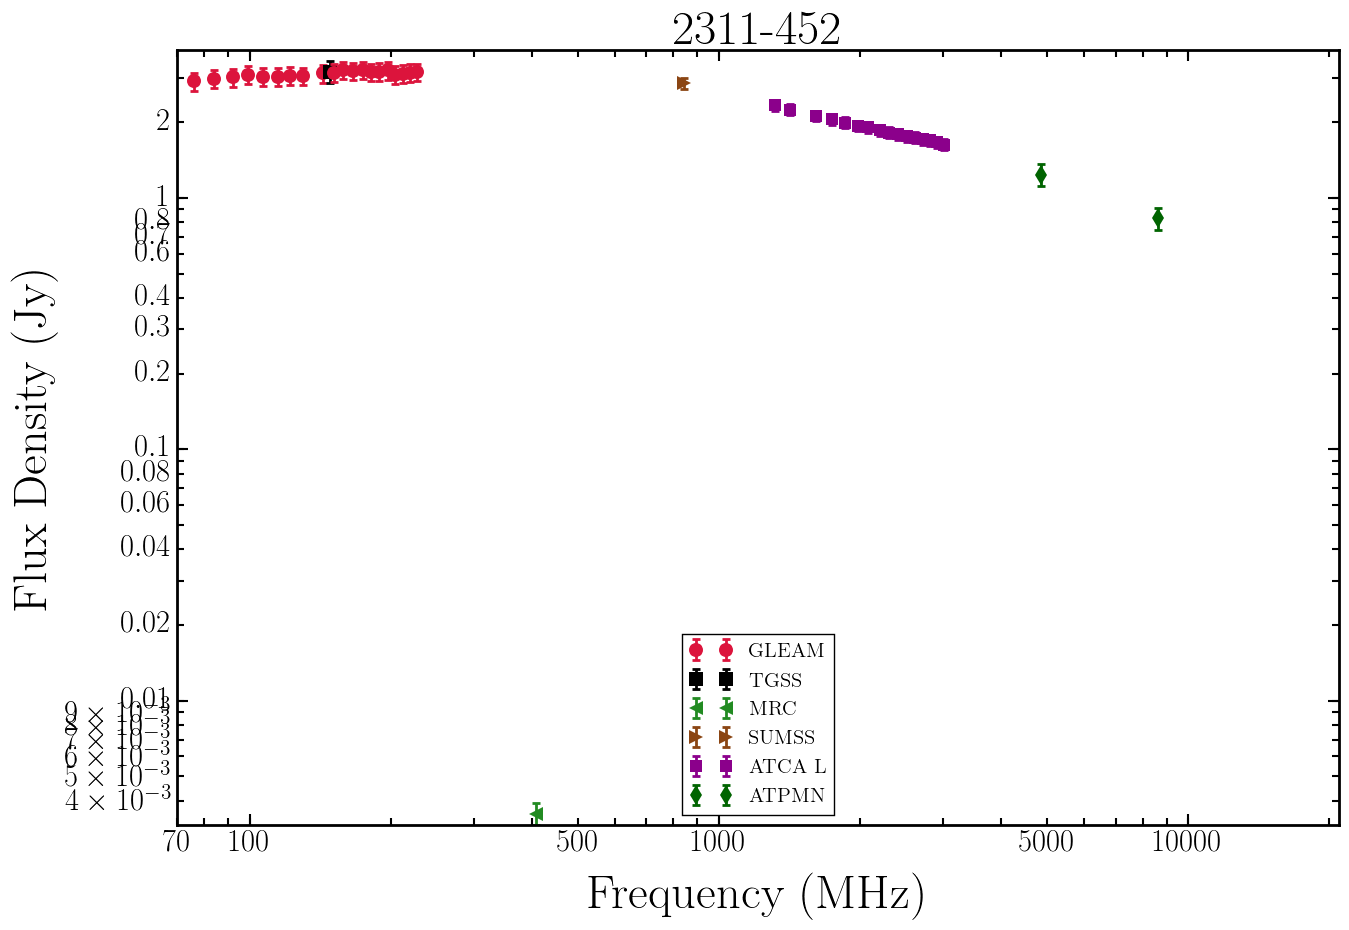

mwacsj2153.5-3445


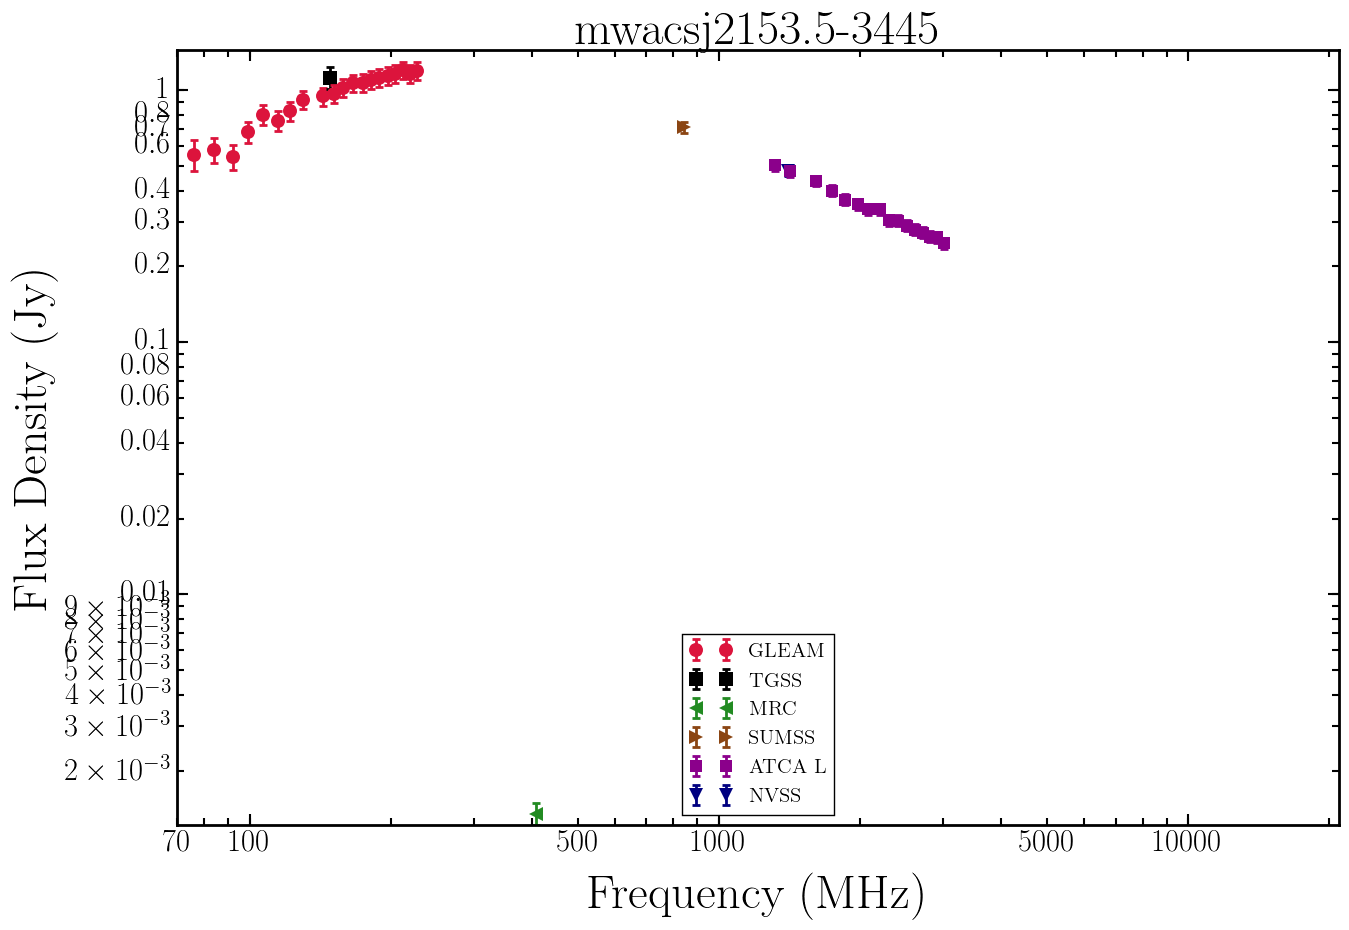

pks2149-28


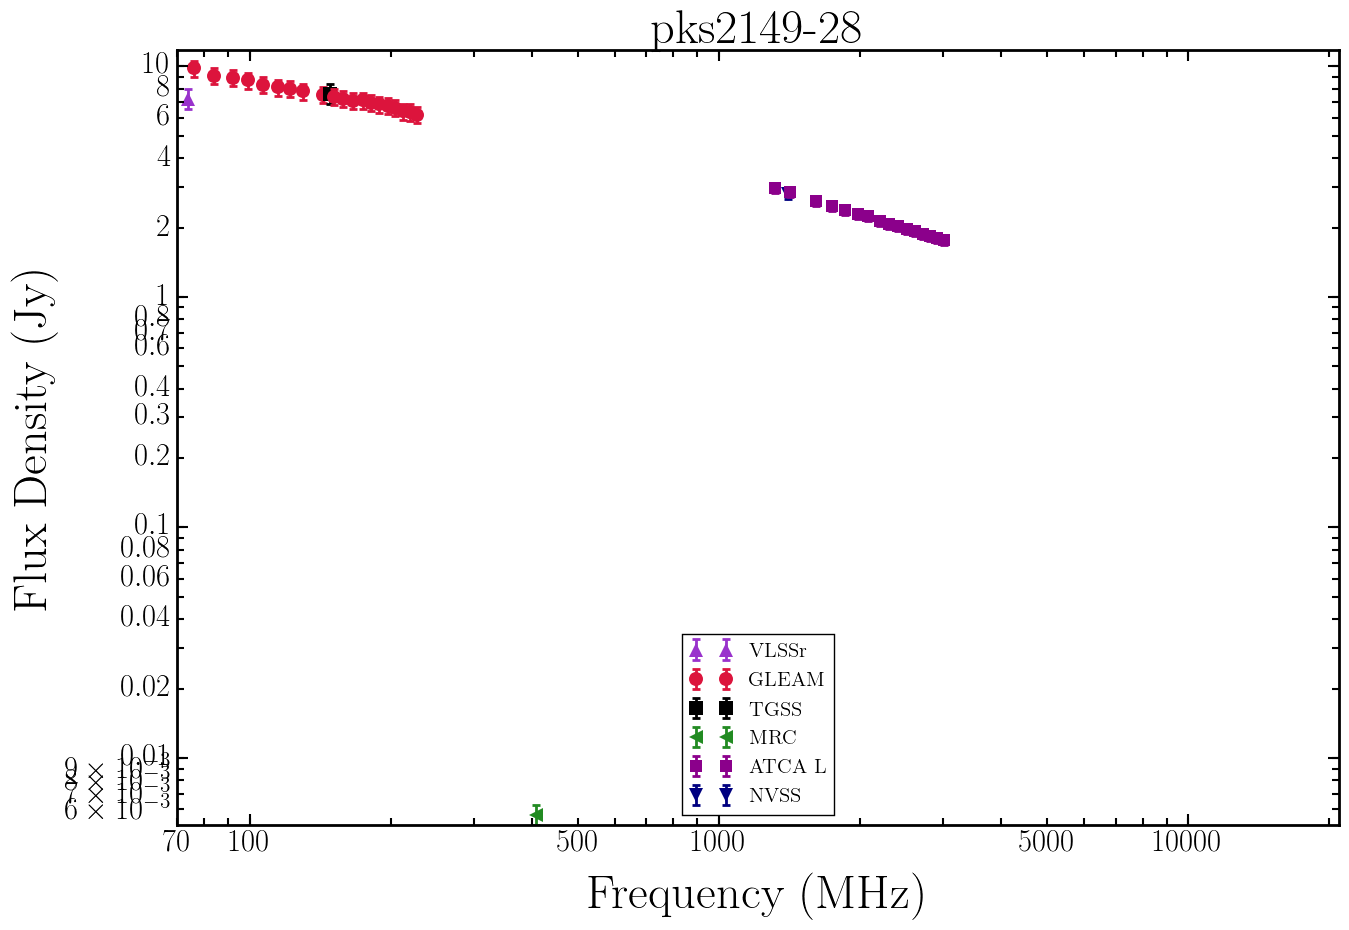

mwacsj2157.5-1807


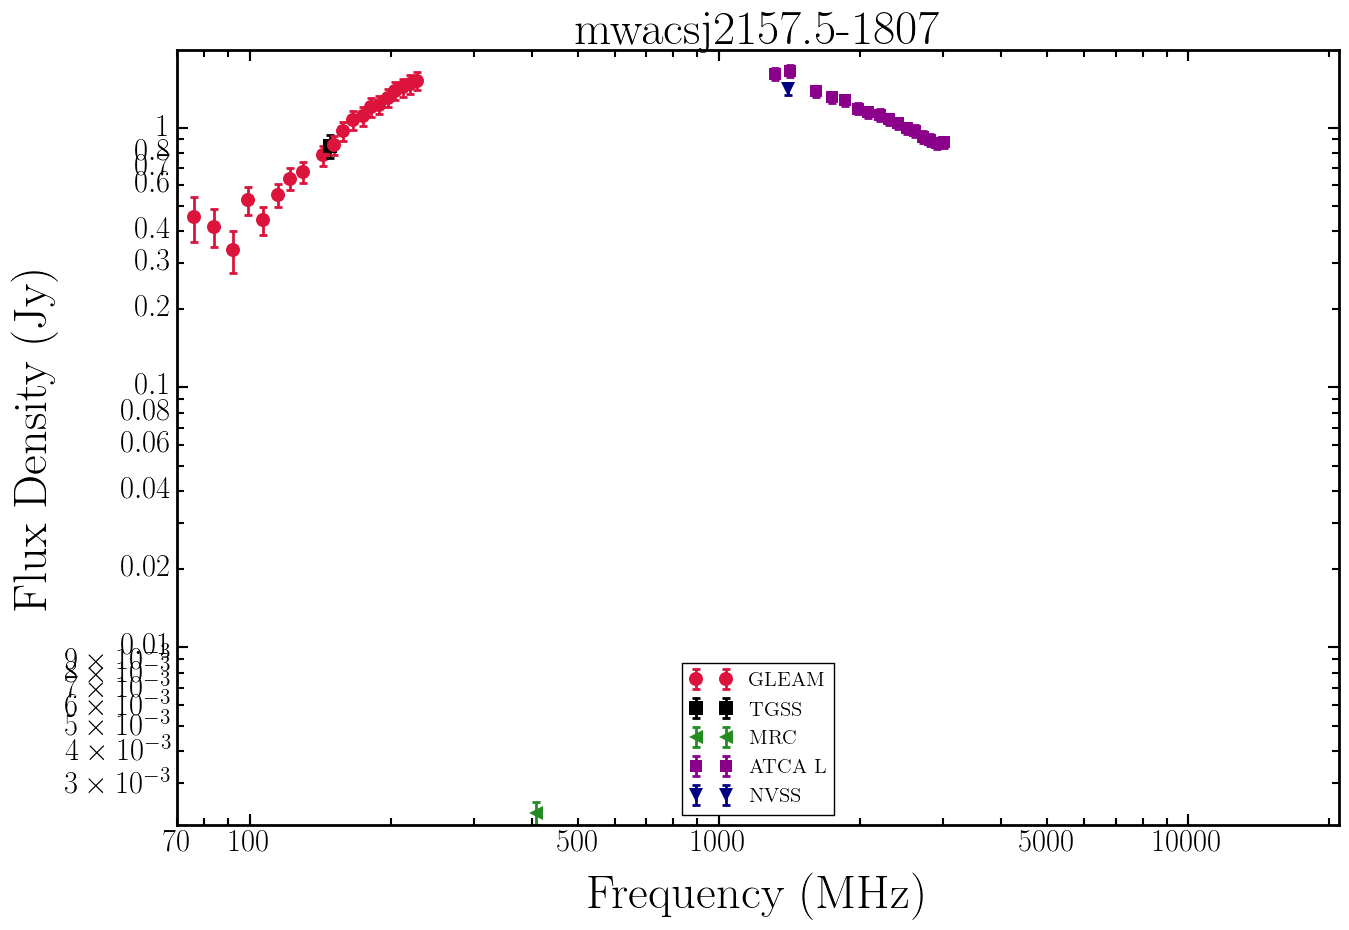

pksb2322-040


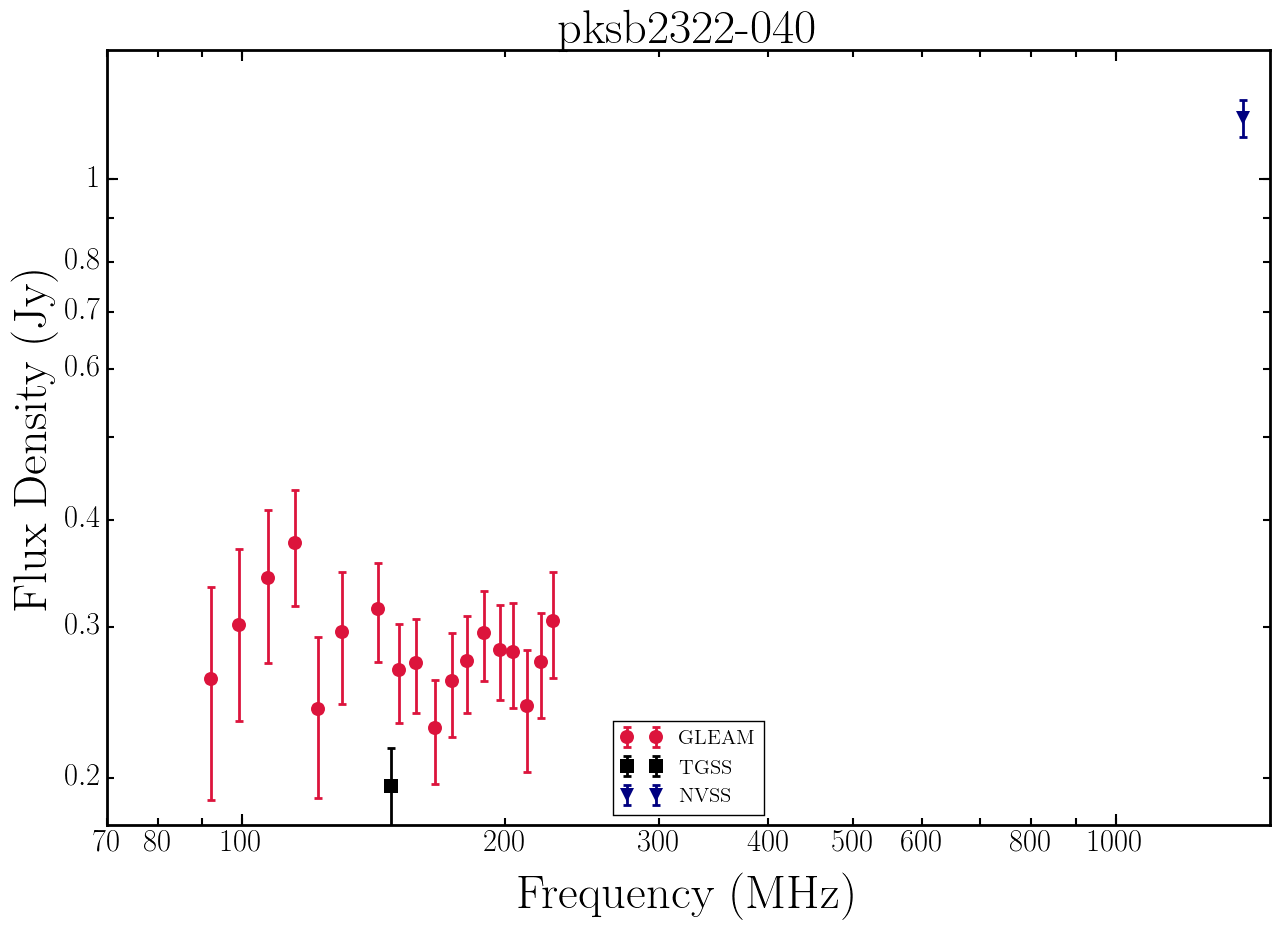

0743-673


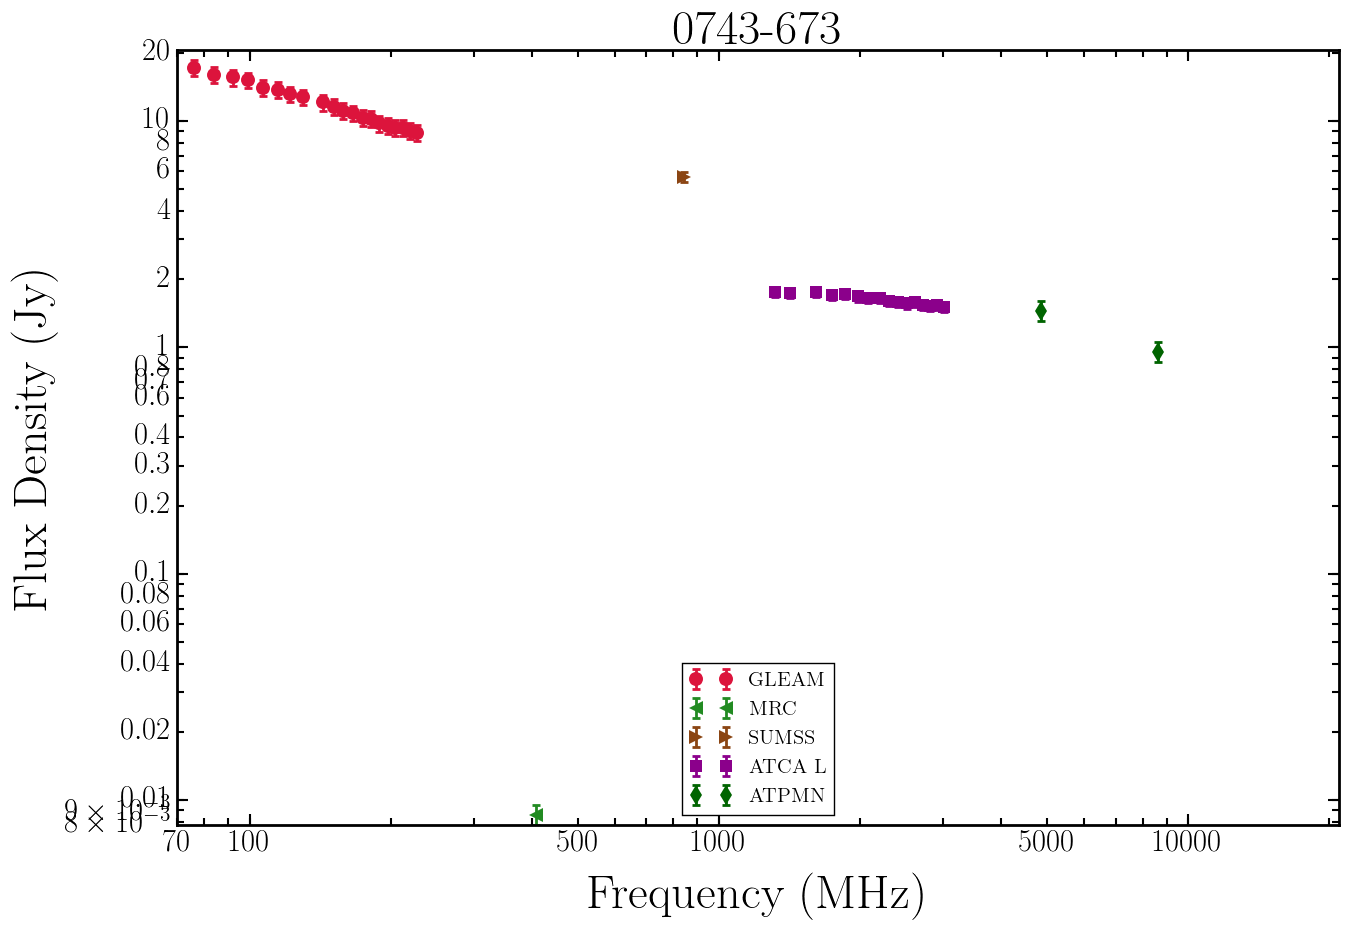

pks0420-62


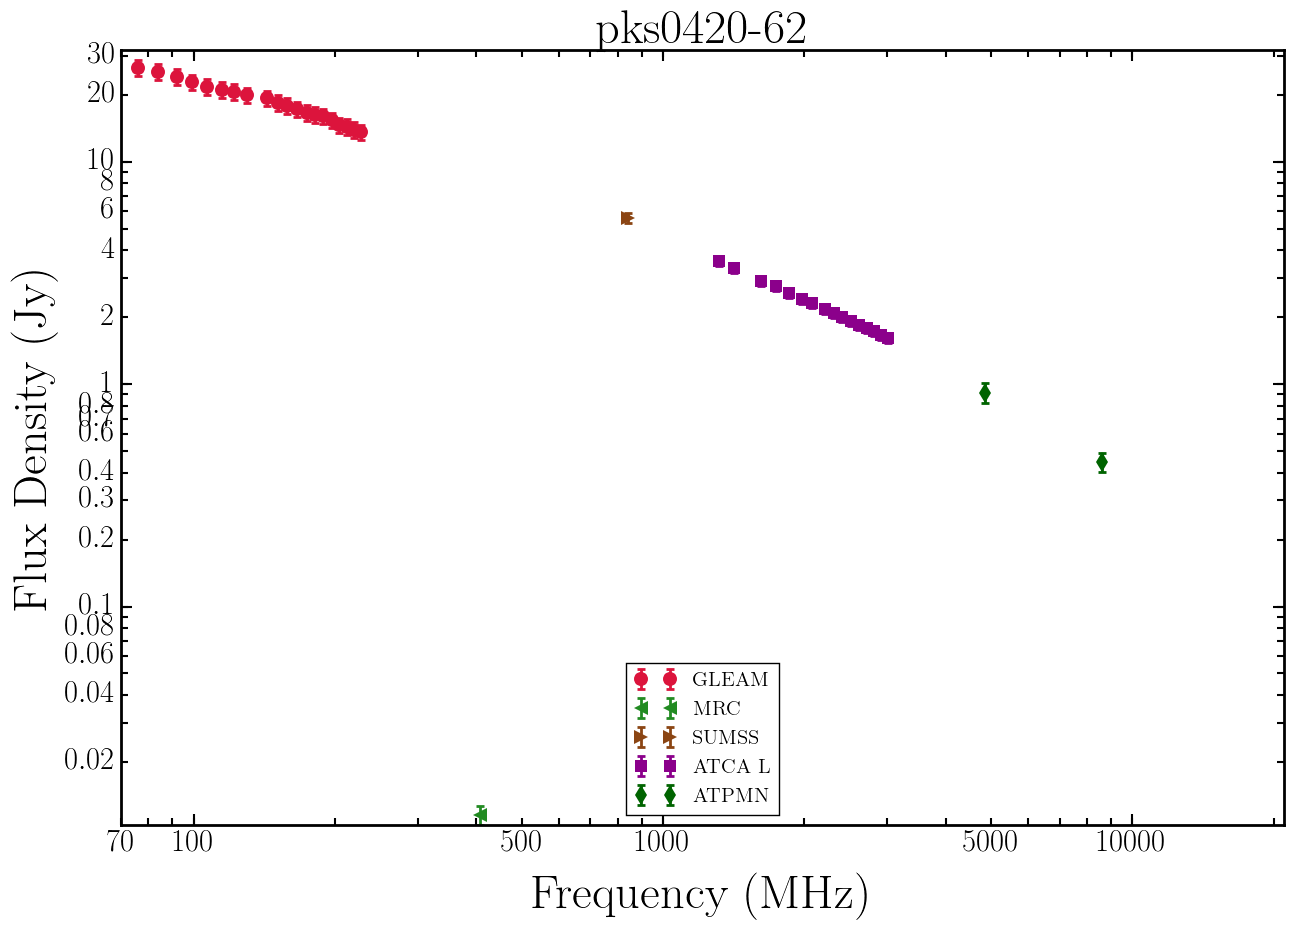

pks0201-44


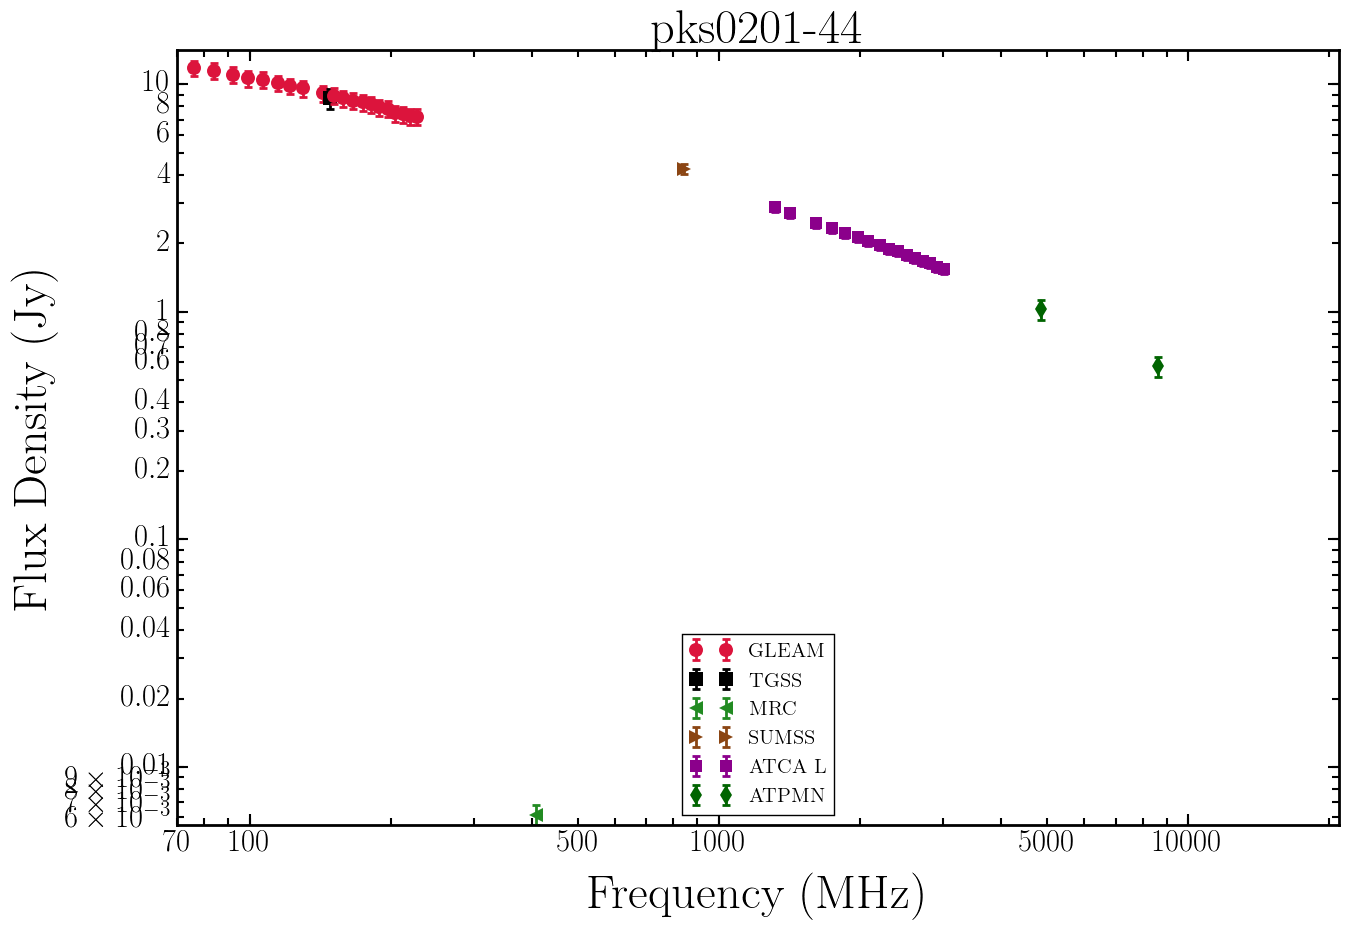

0023-263


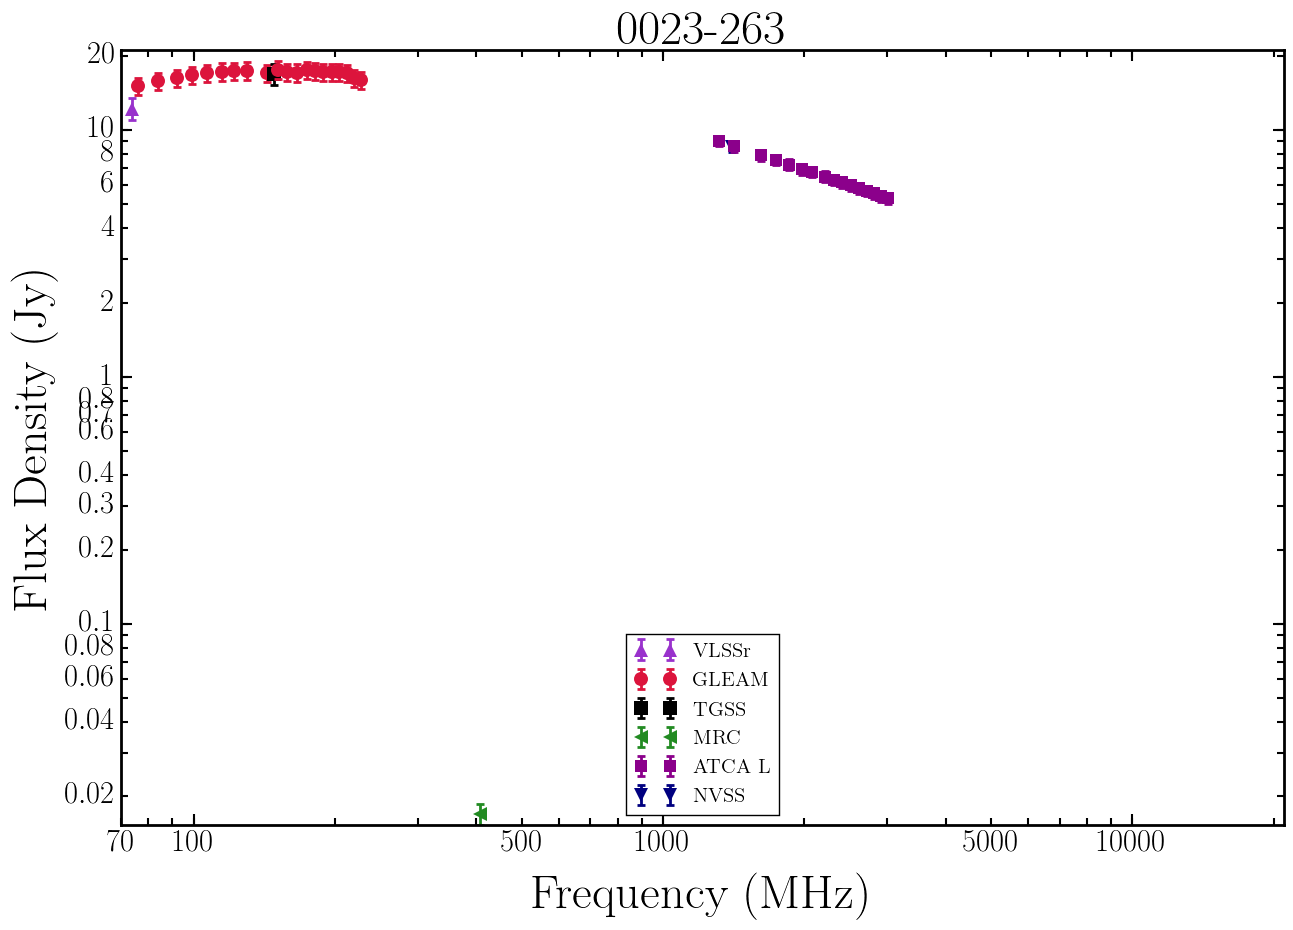

pks0204-306


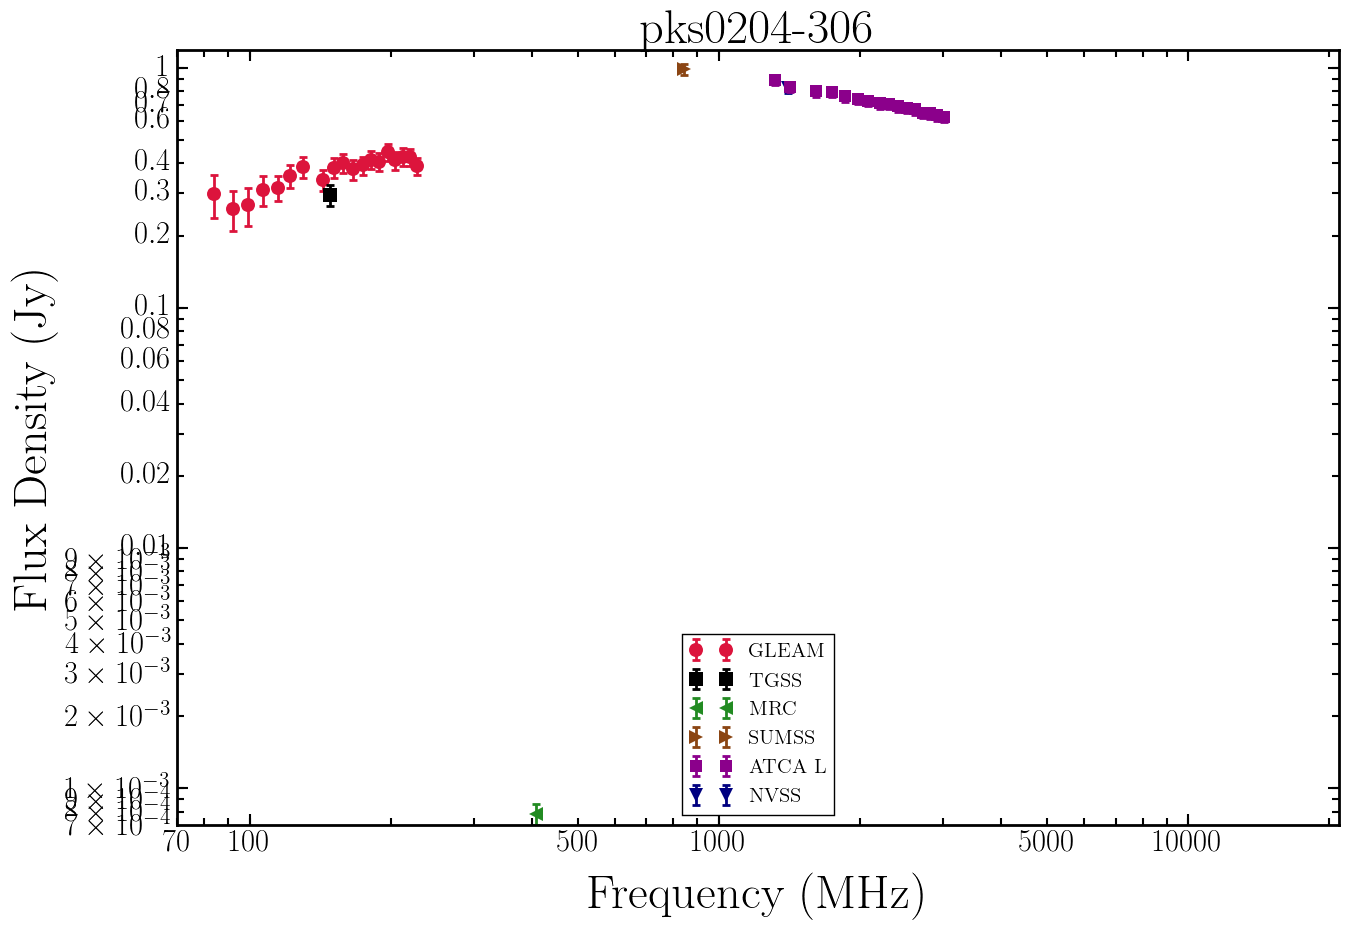

pks0359-294


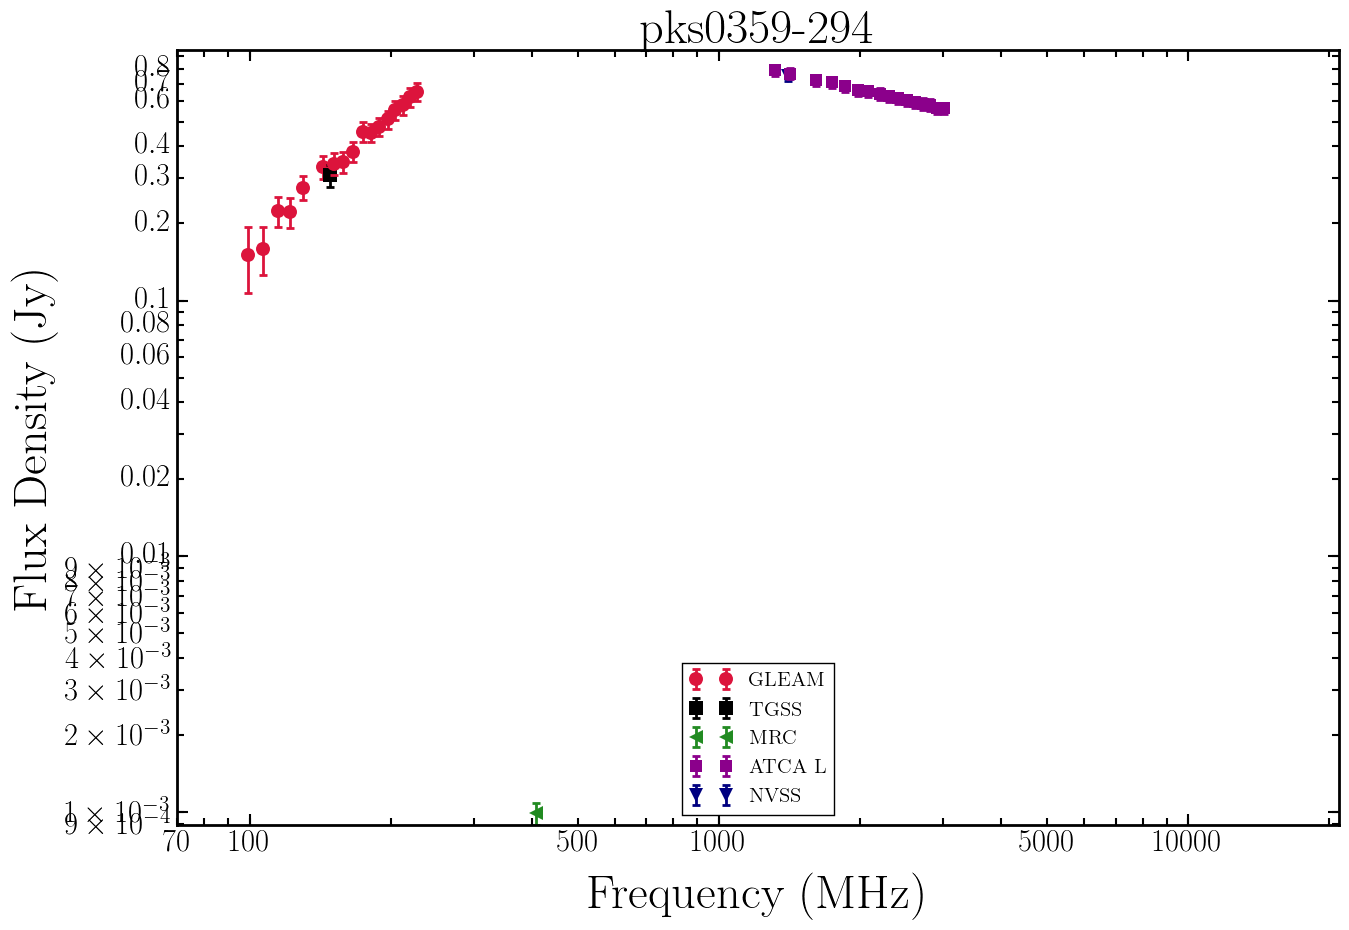

pks0207-224


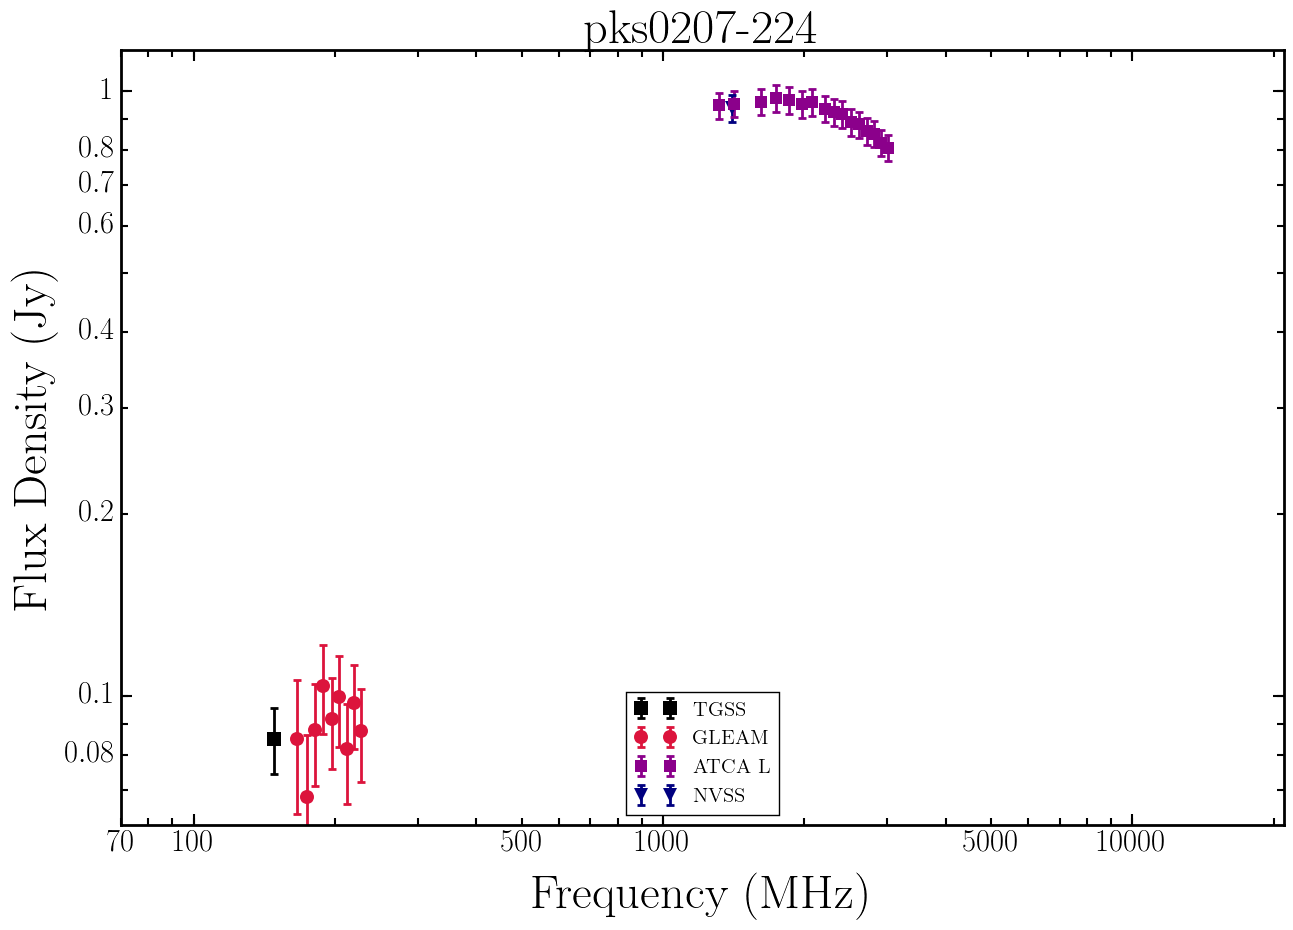

pks0240-217


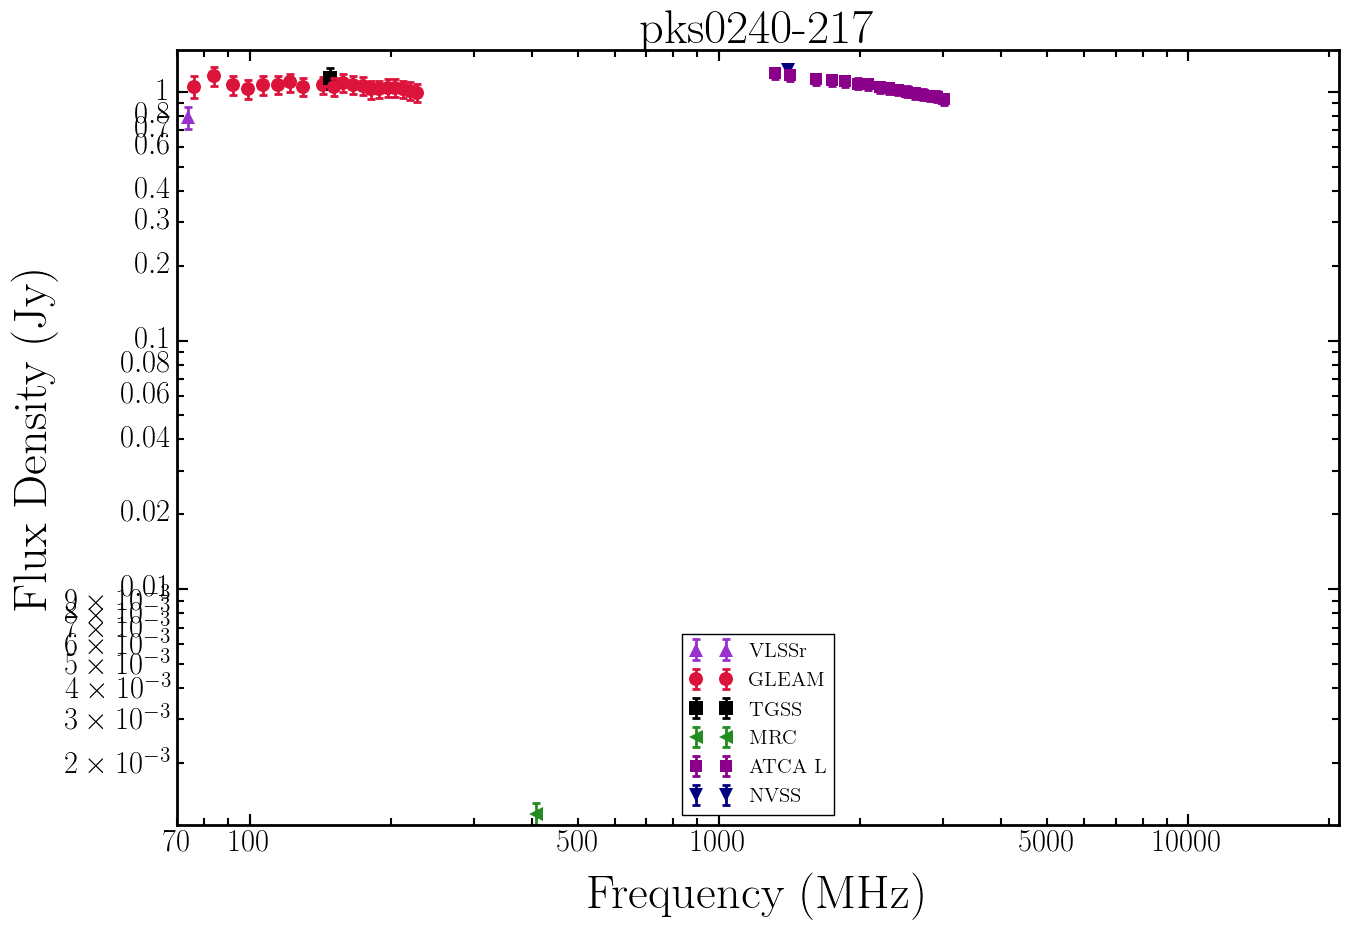

pks0454-088


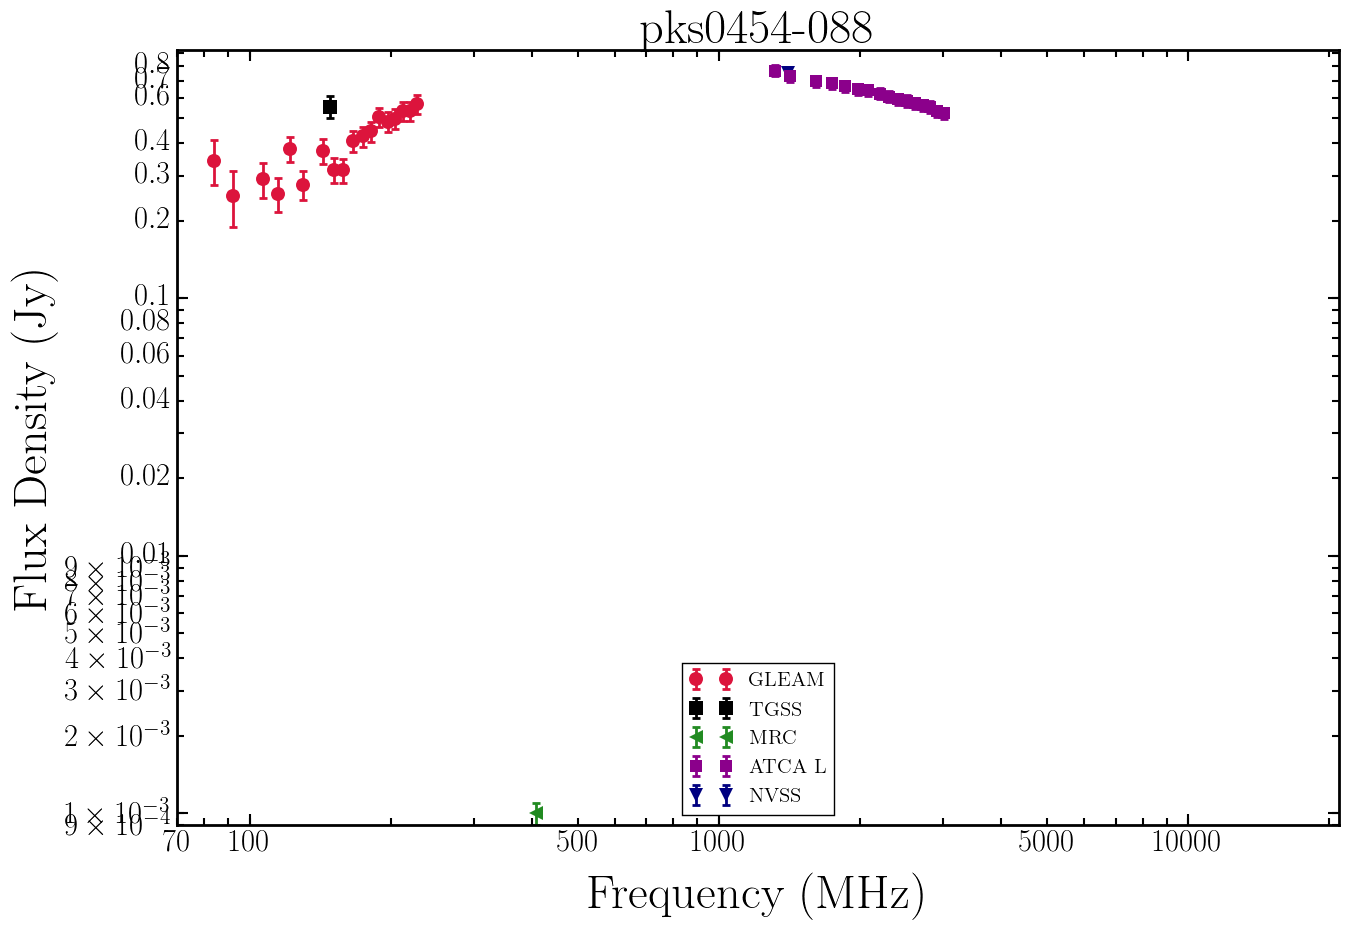

4c-02.17


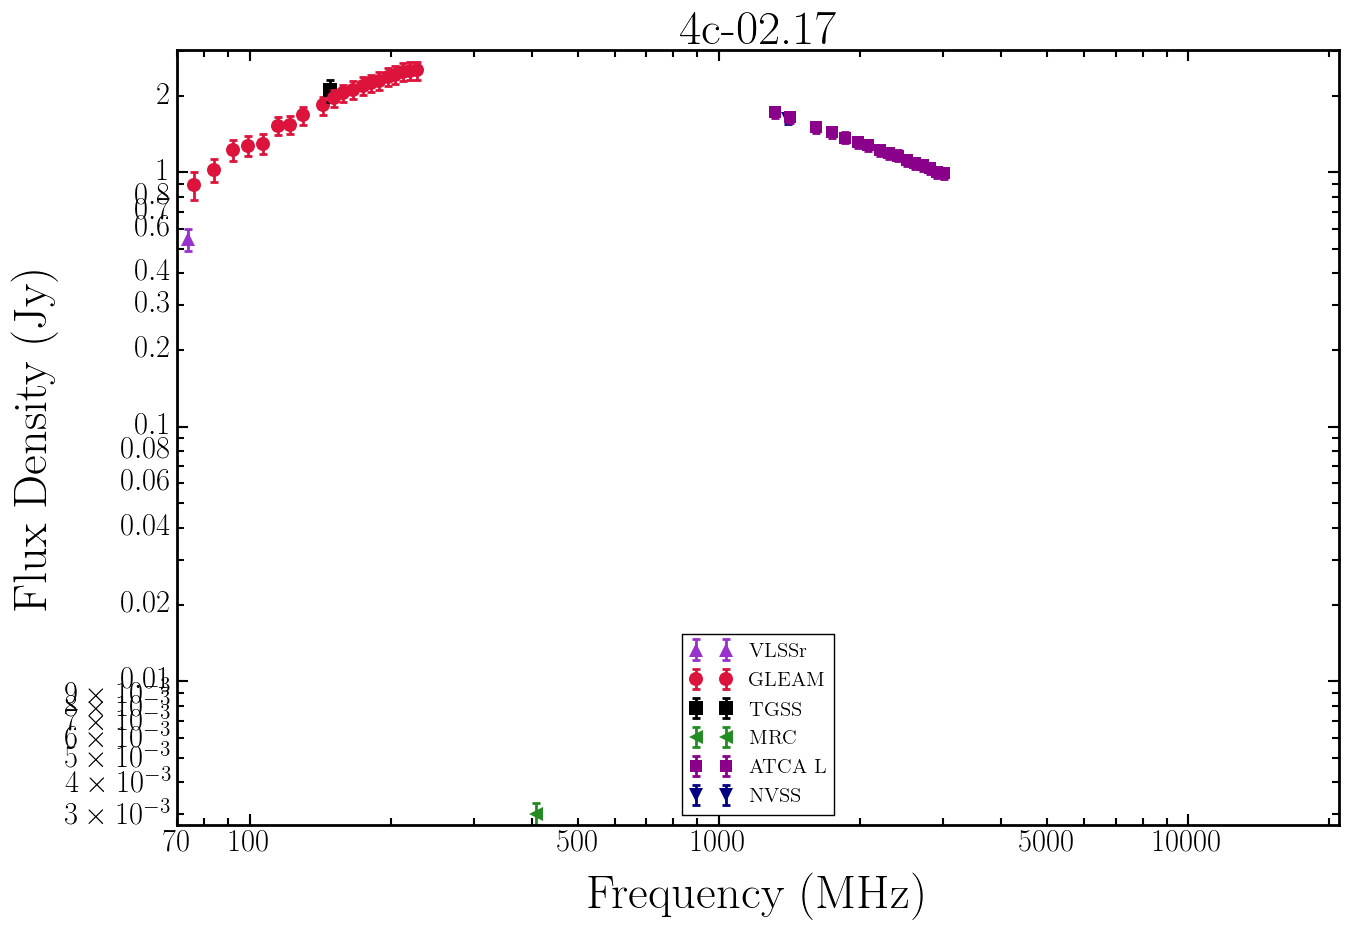

pks0208+040


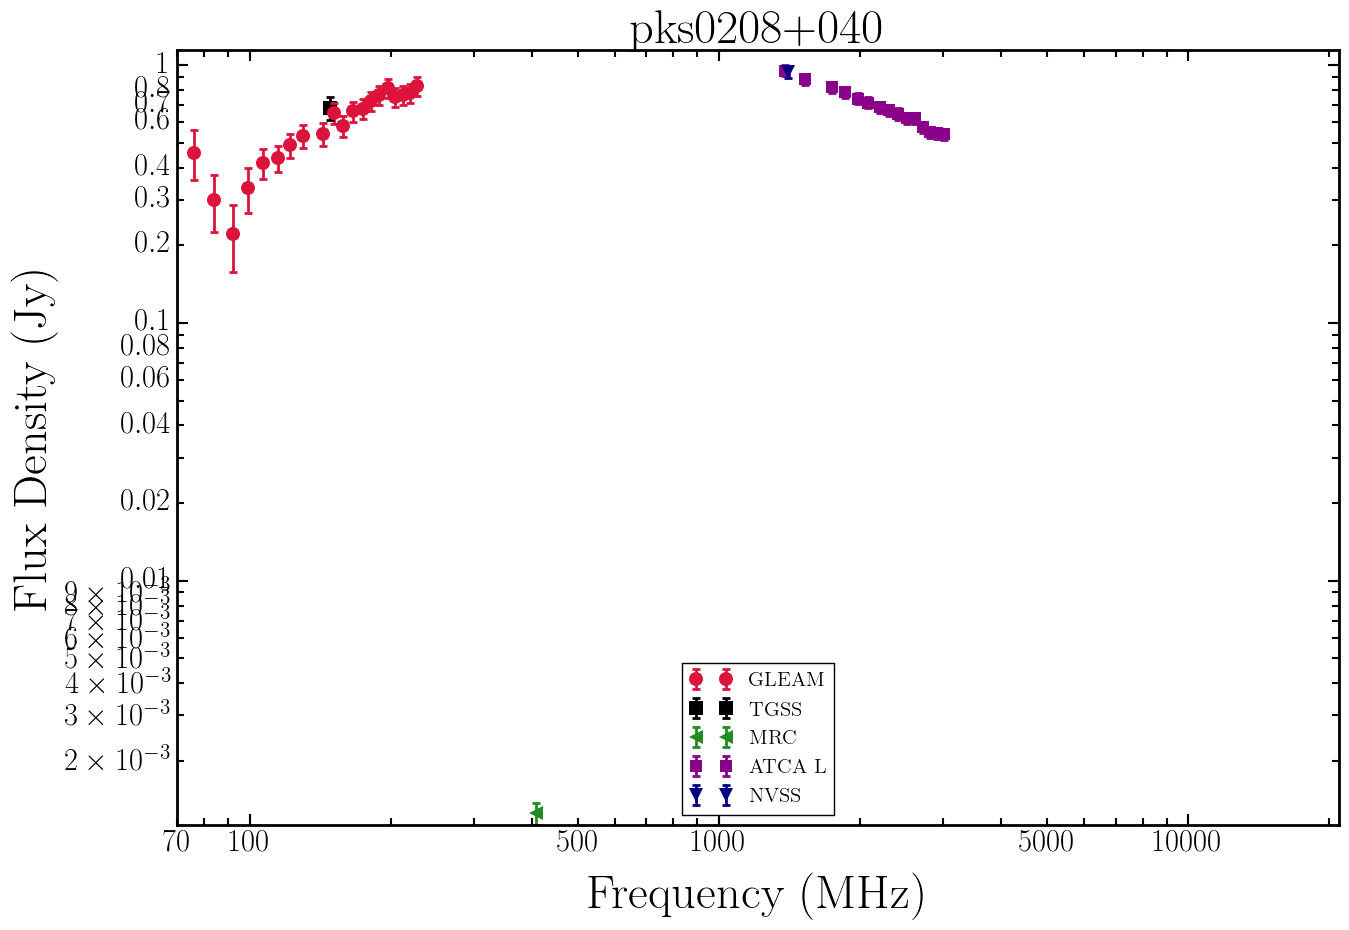

1015-314


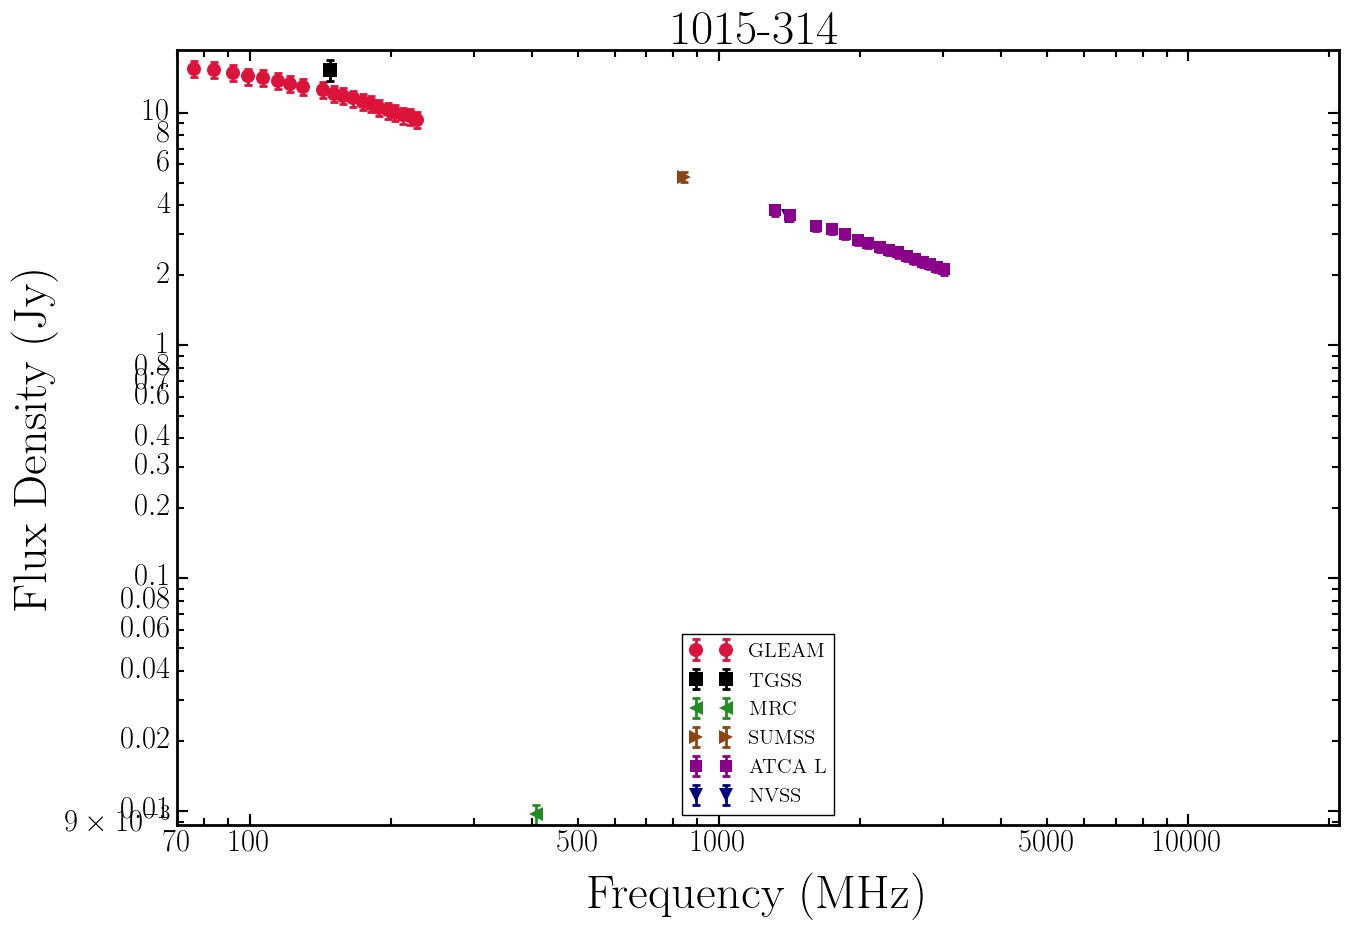

pksb1042-269


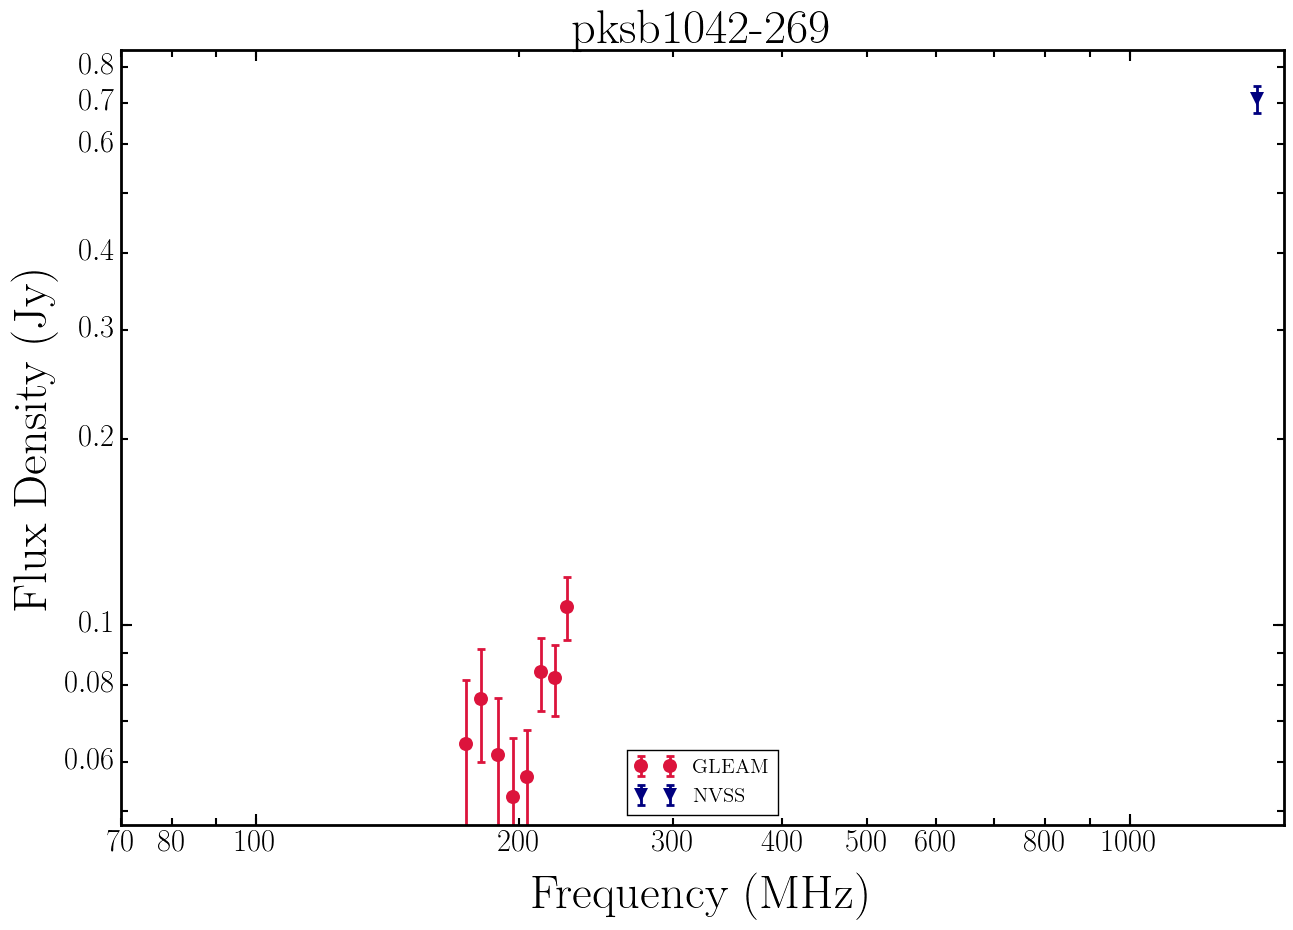

1354-174


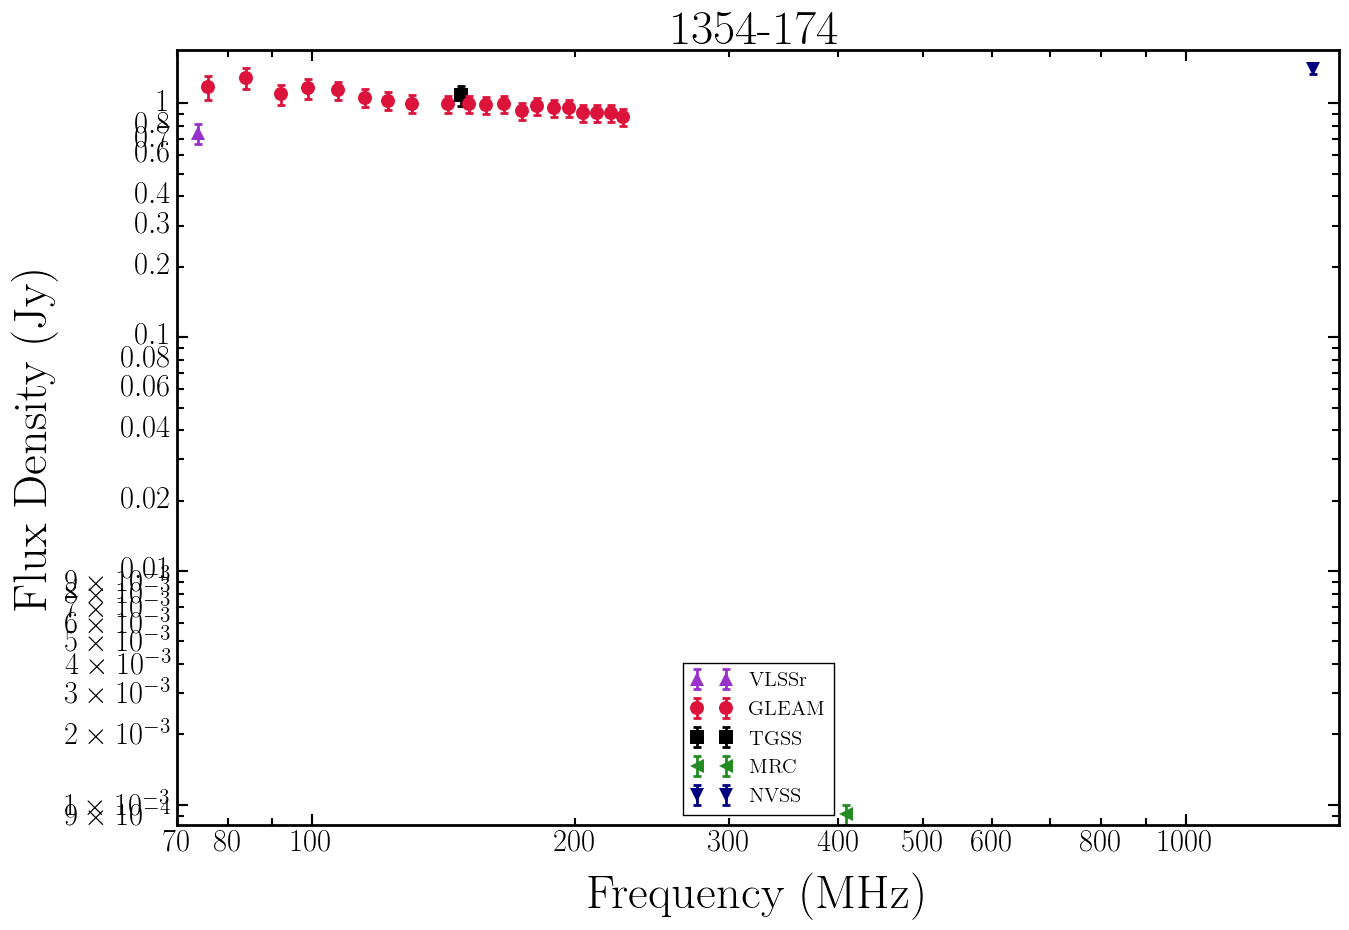

j103152-222823


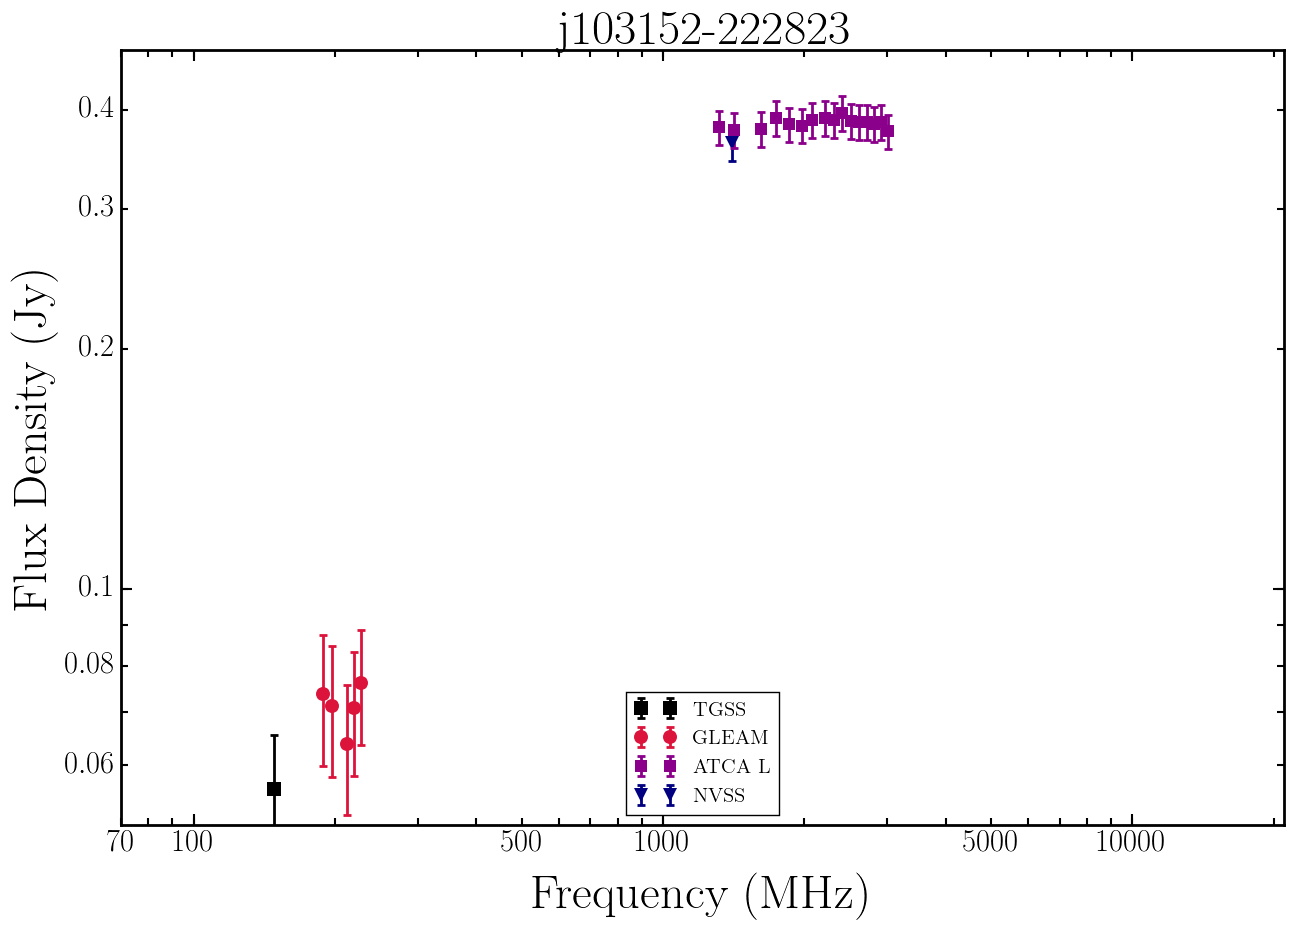

pks1503-091


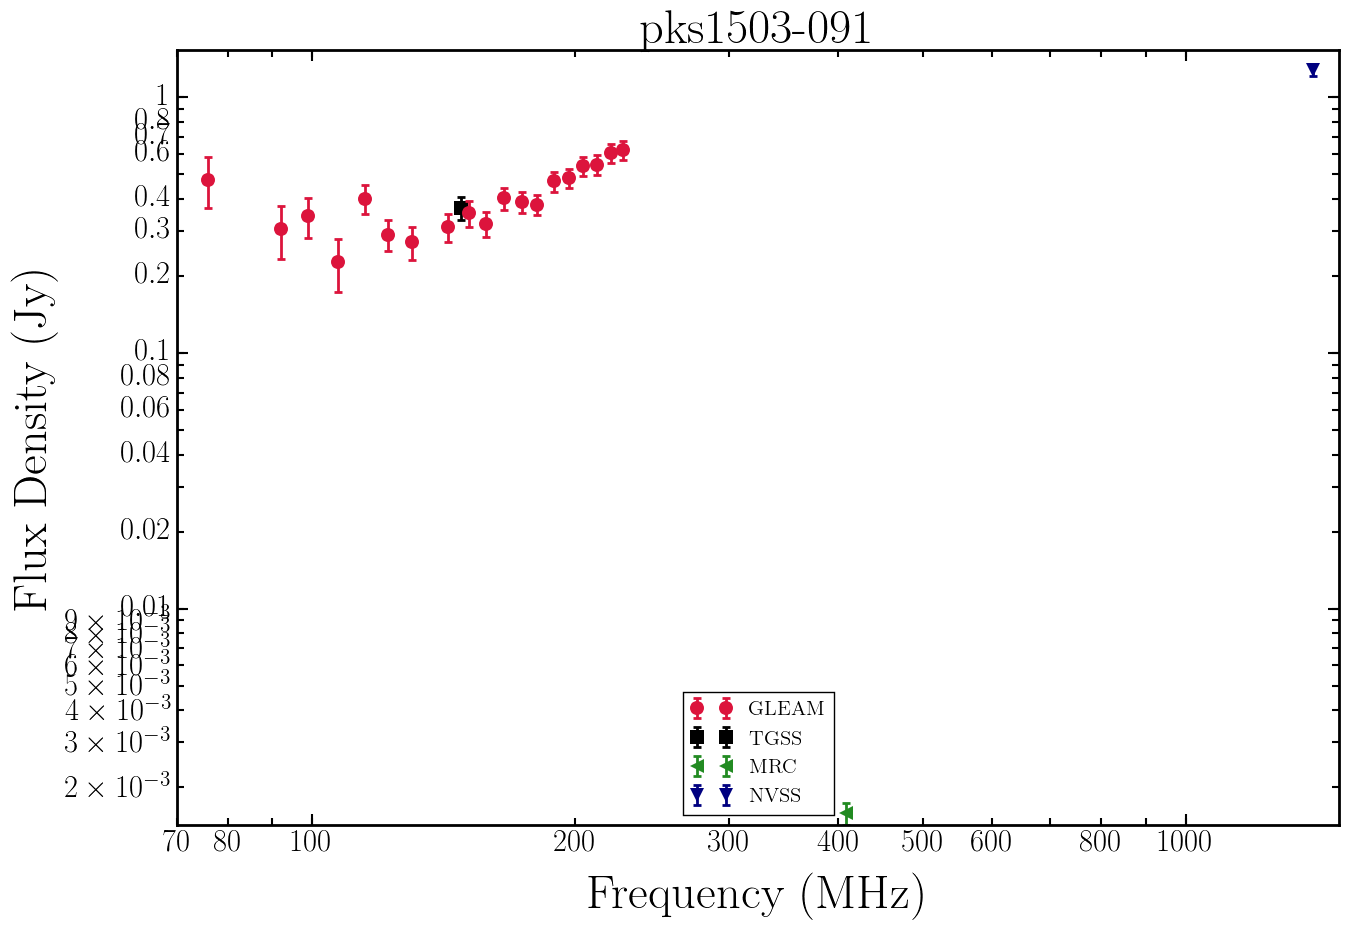

pks1107-187


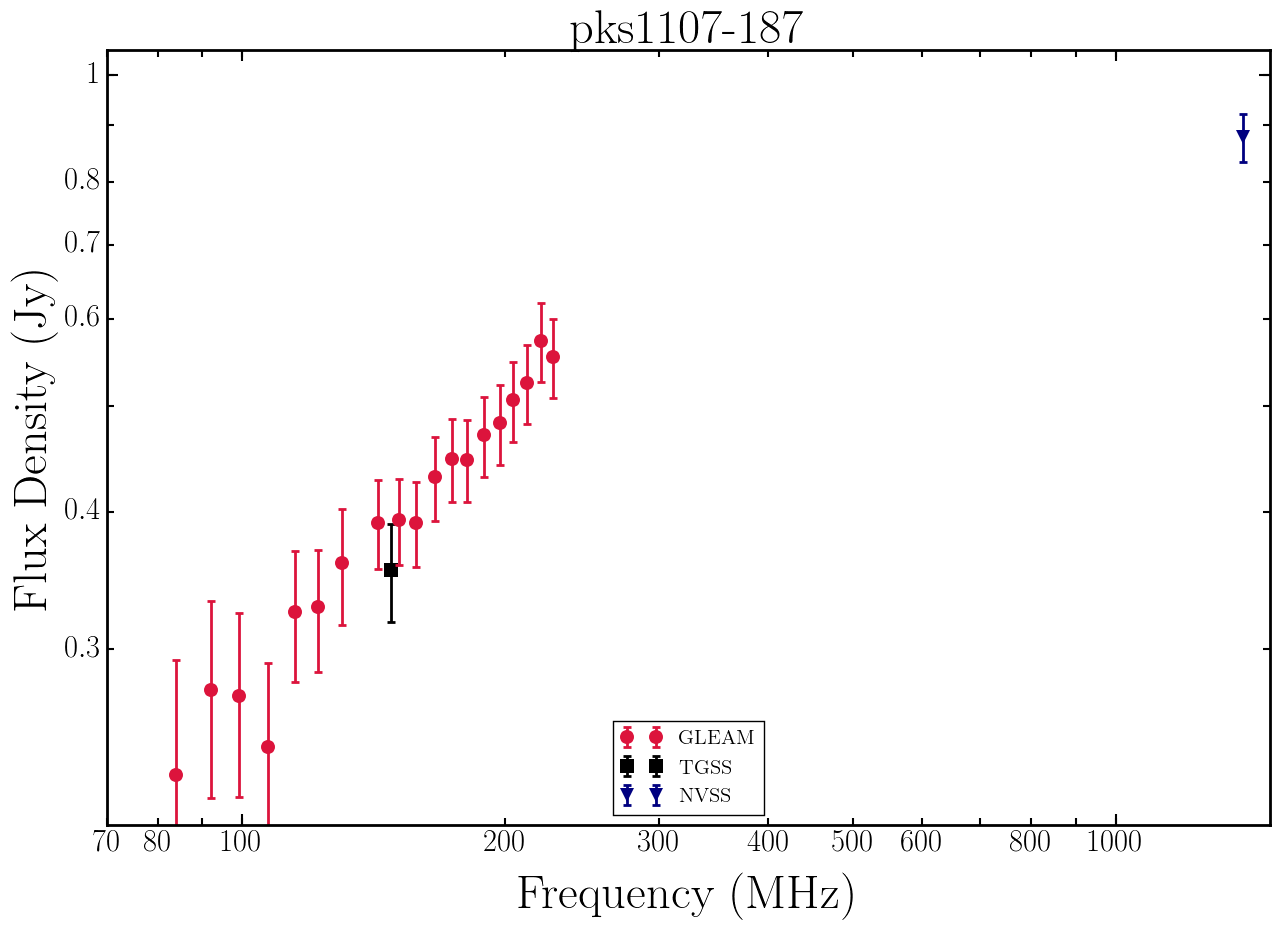

pks1306-09


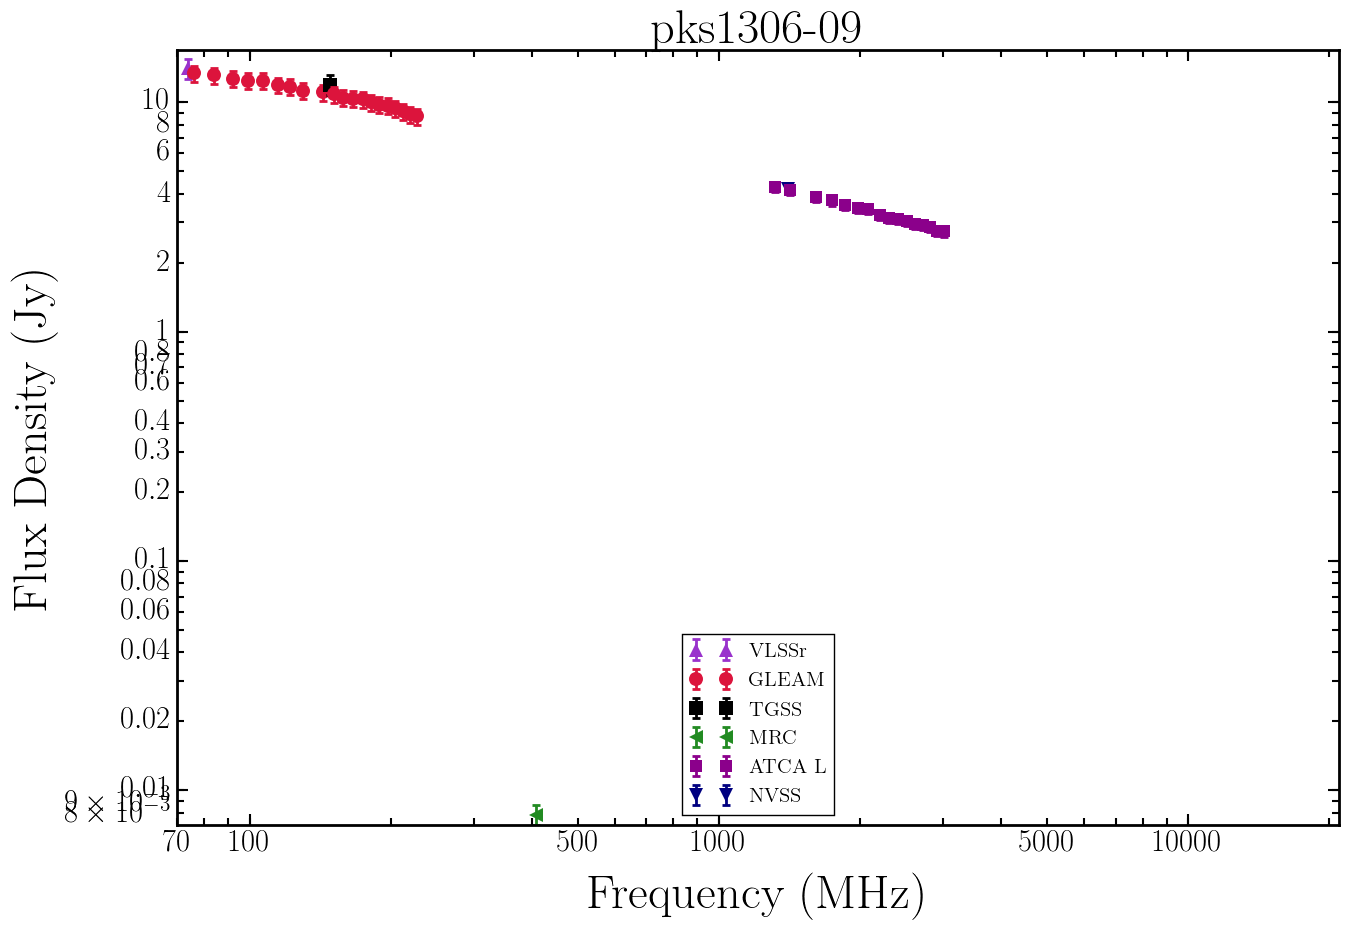

pks1349+027


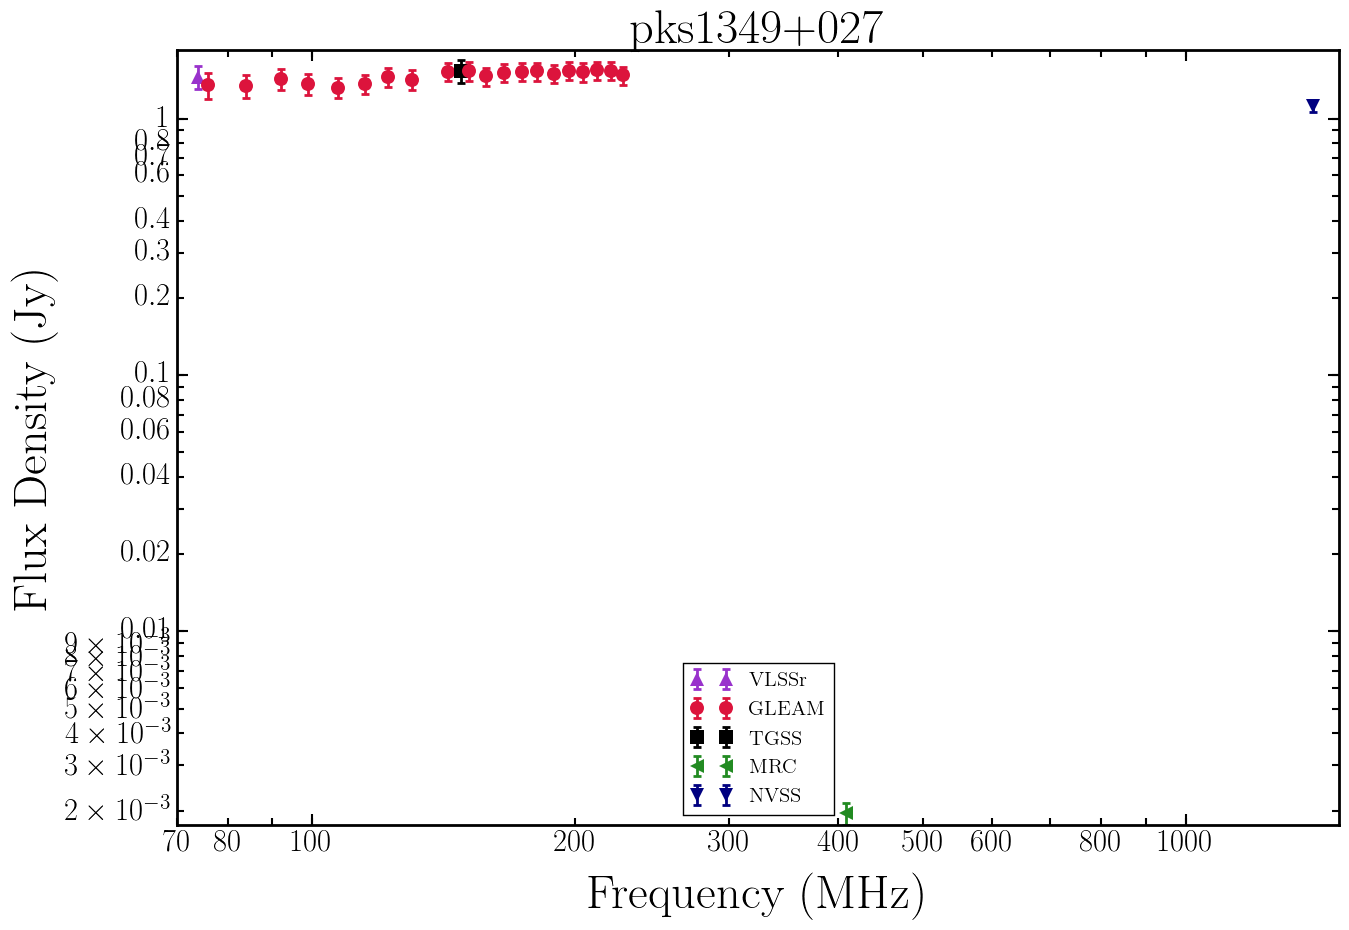

pks1054+004


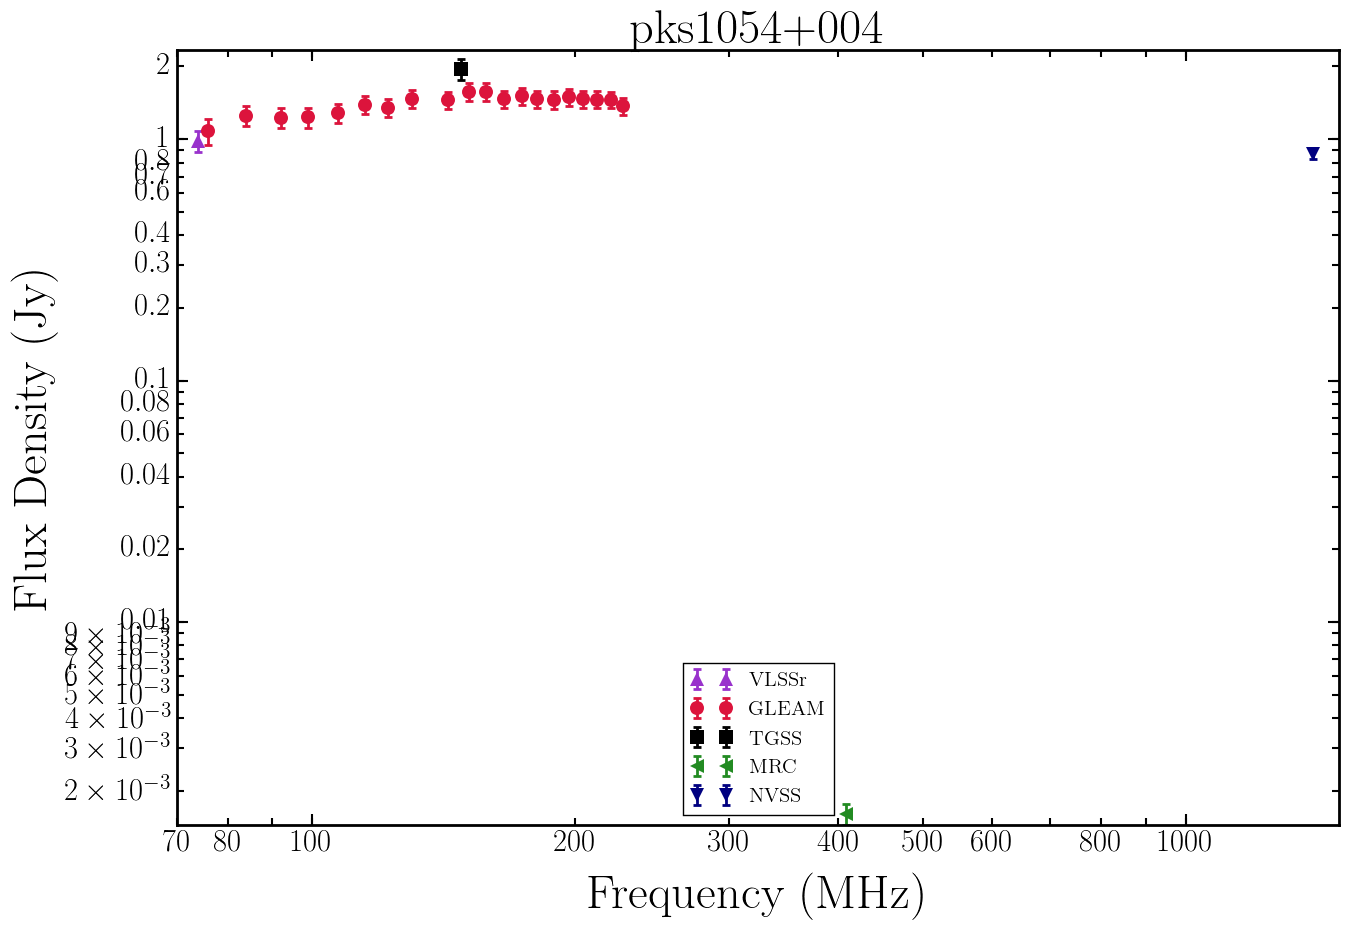

4c+11.46


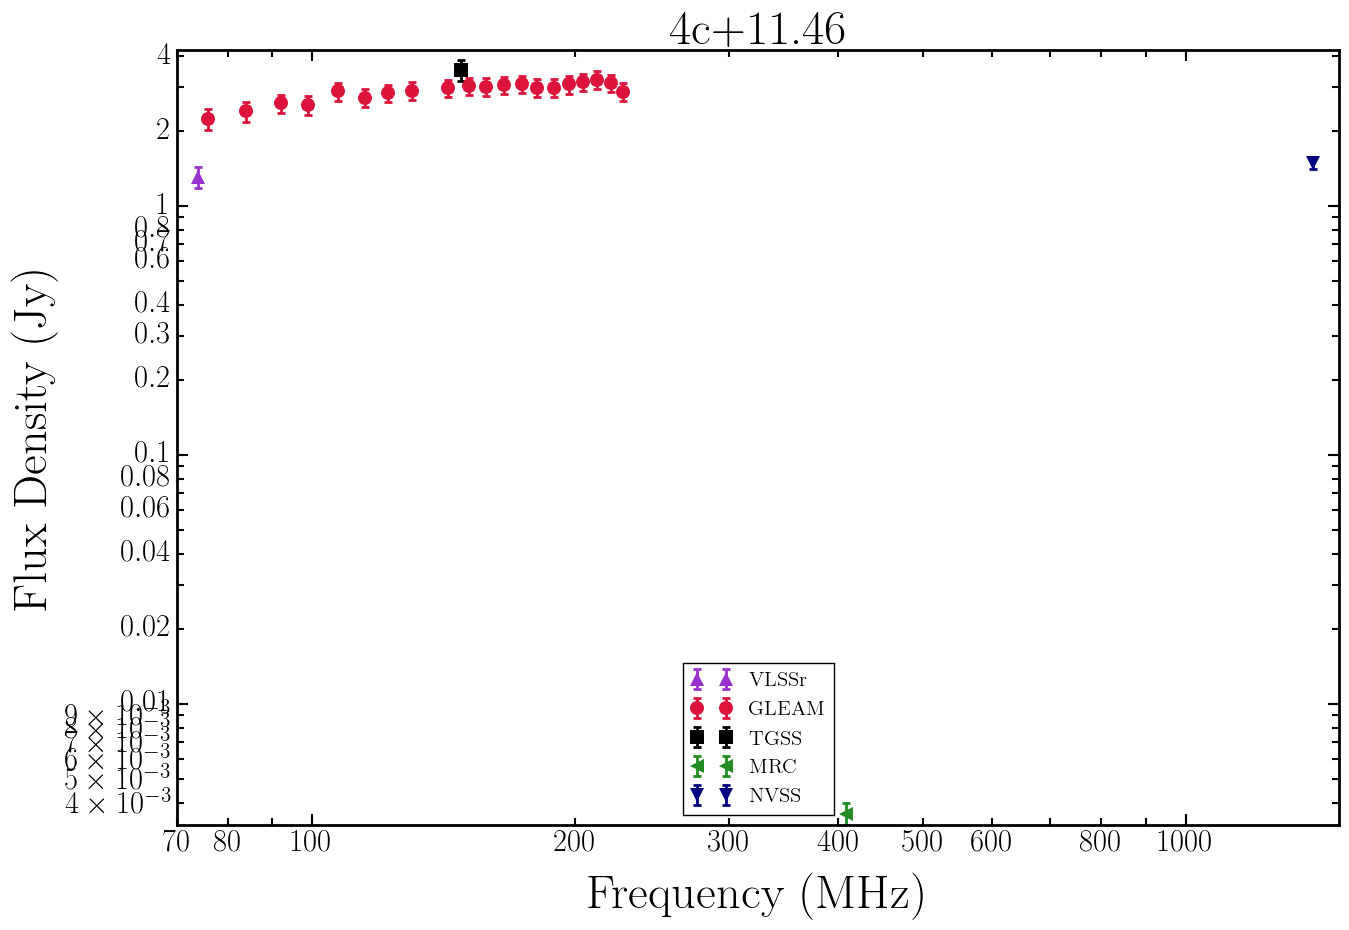

pks1107+10


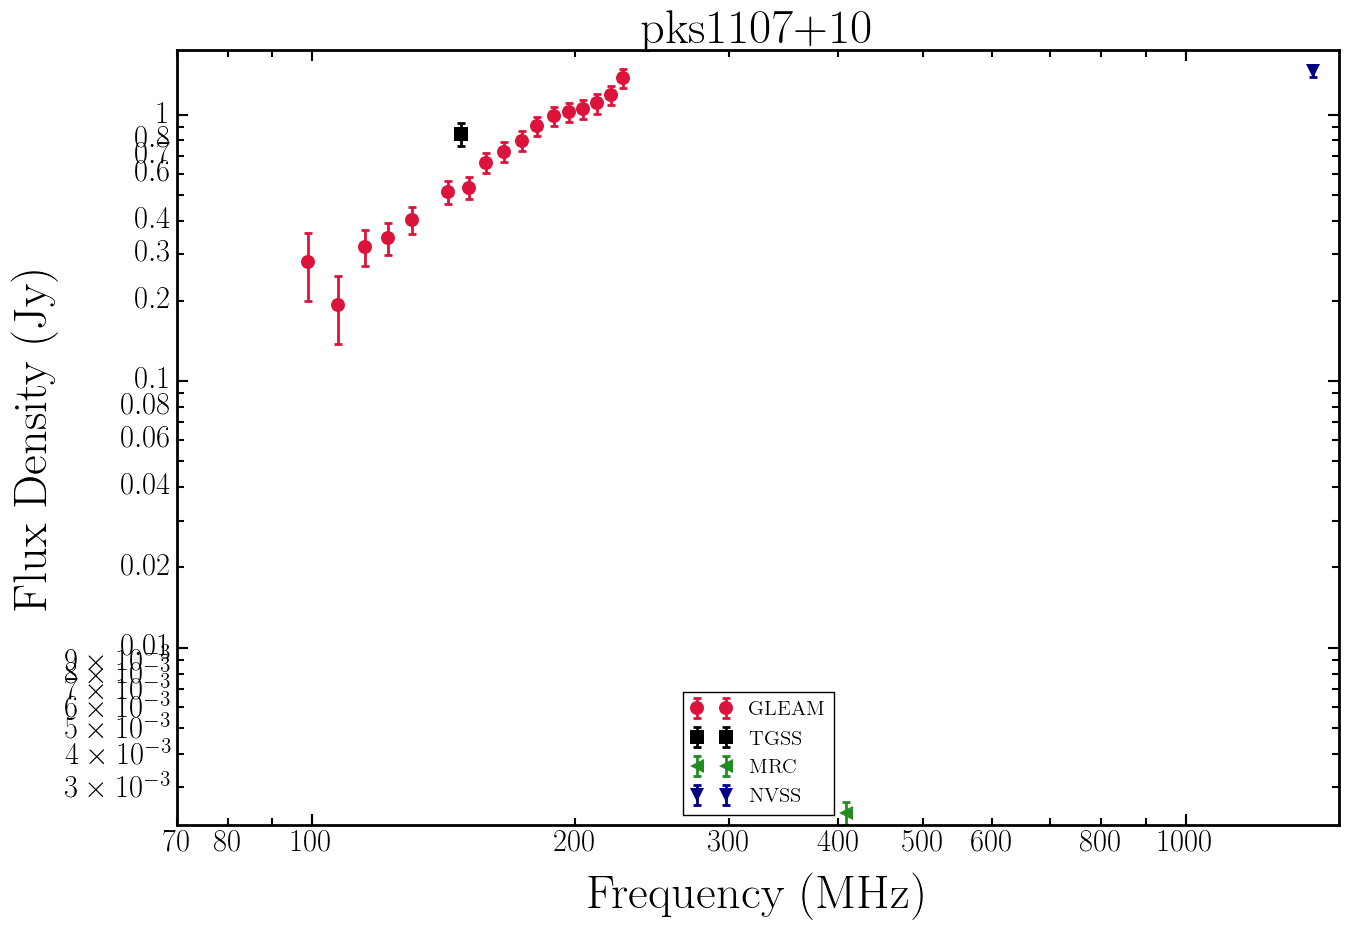

4c+14.41


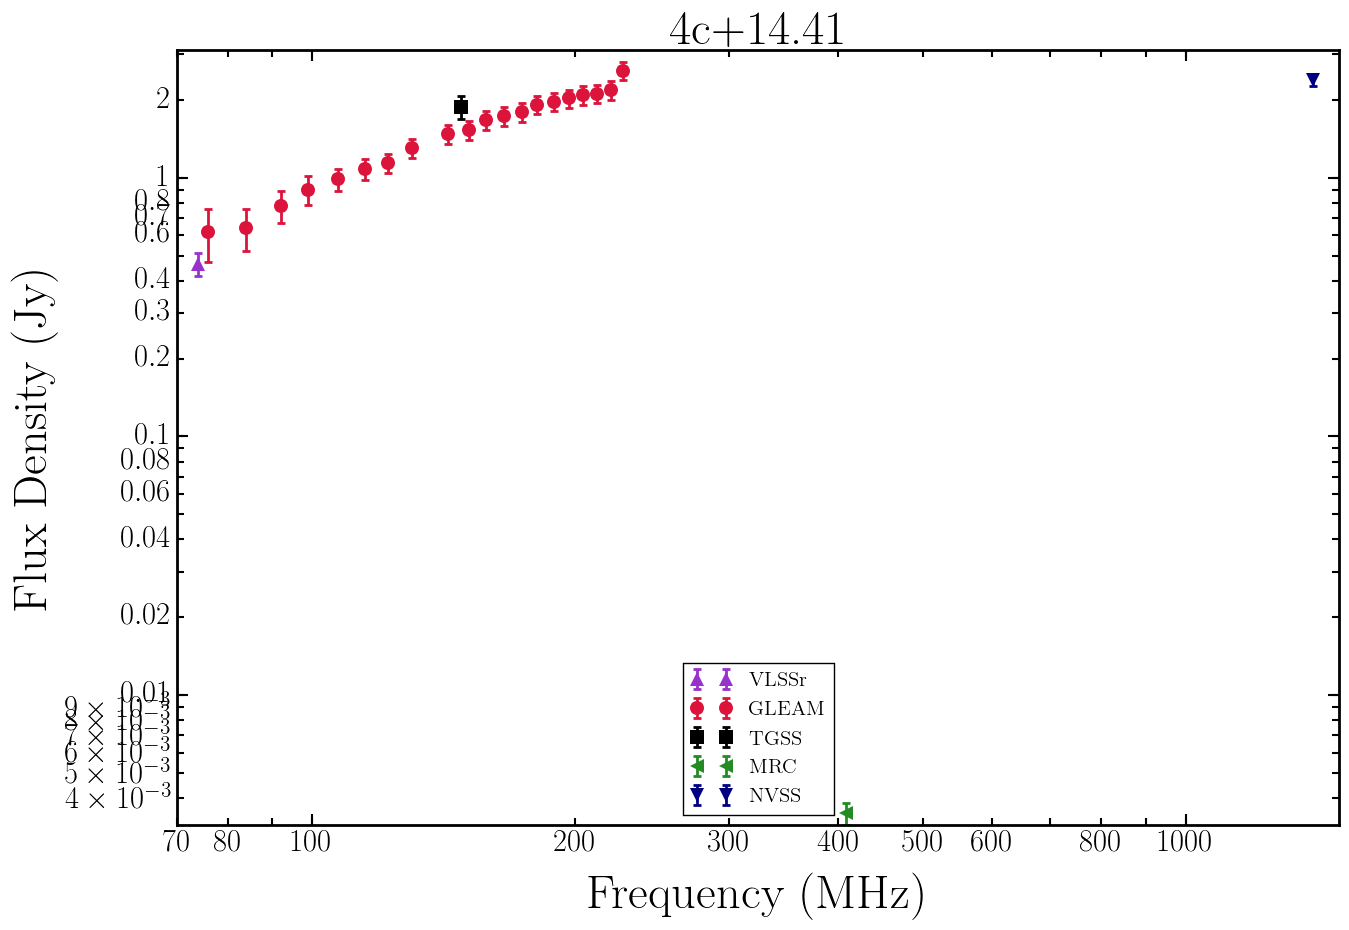

pks1934-638


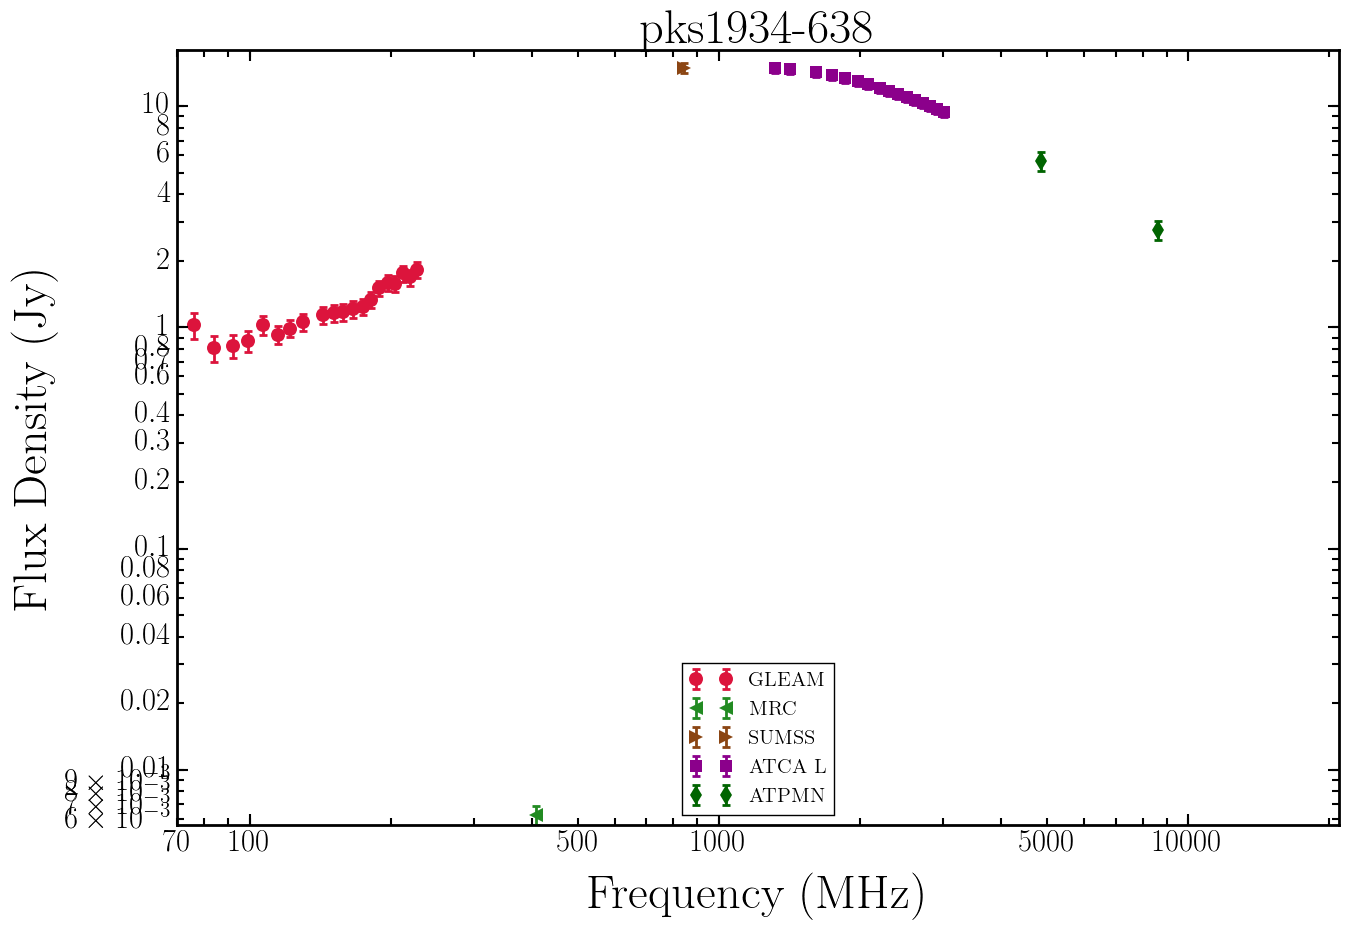

pks1814-637


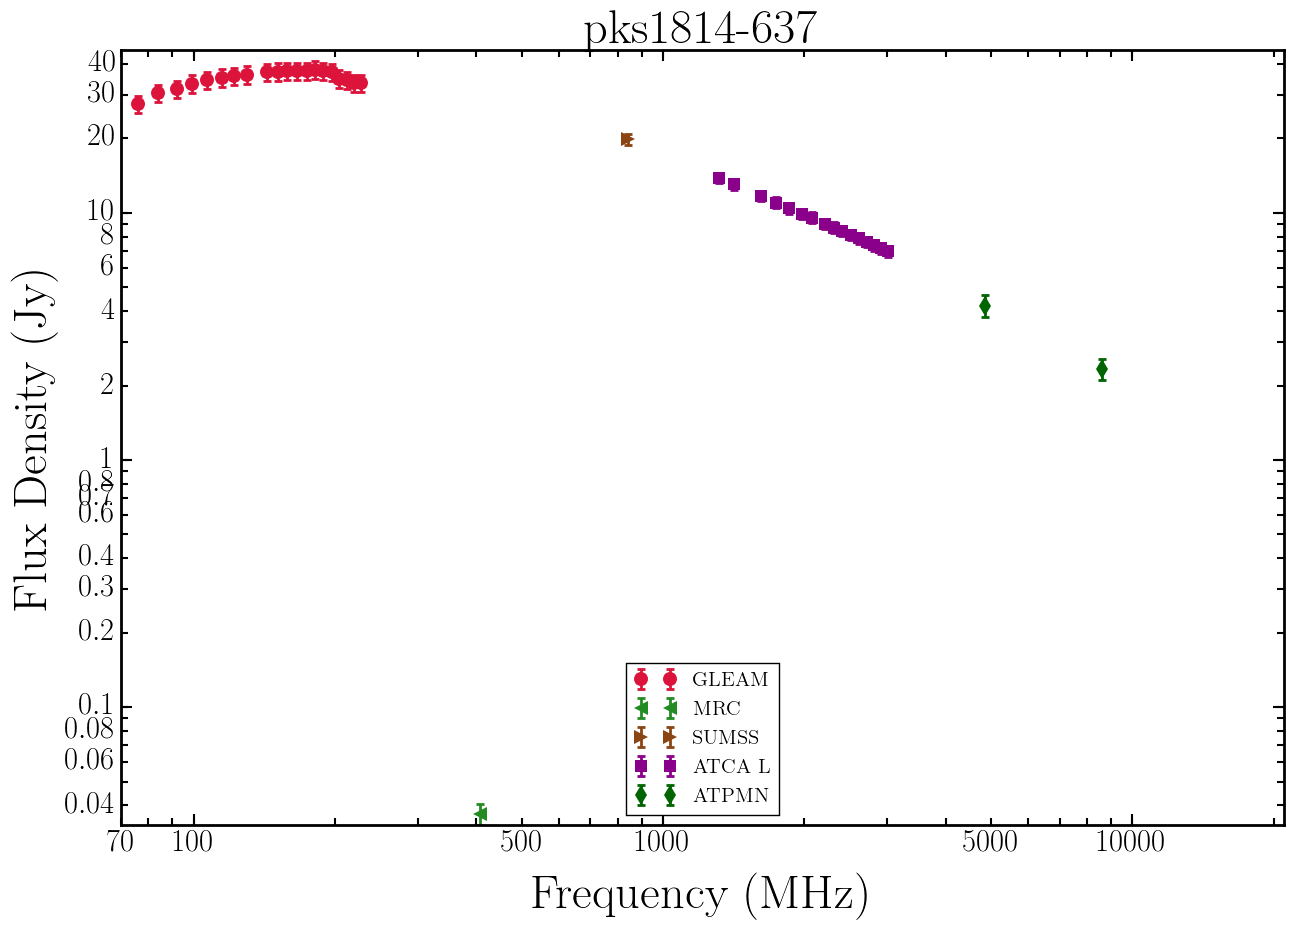

pks1740-517


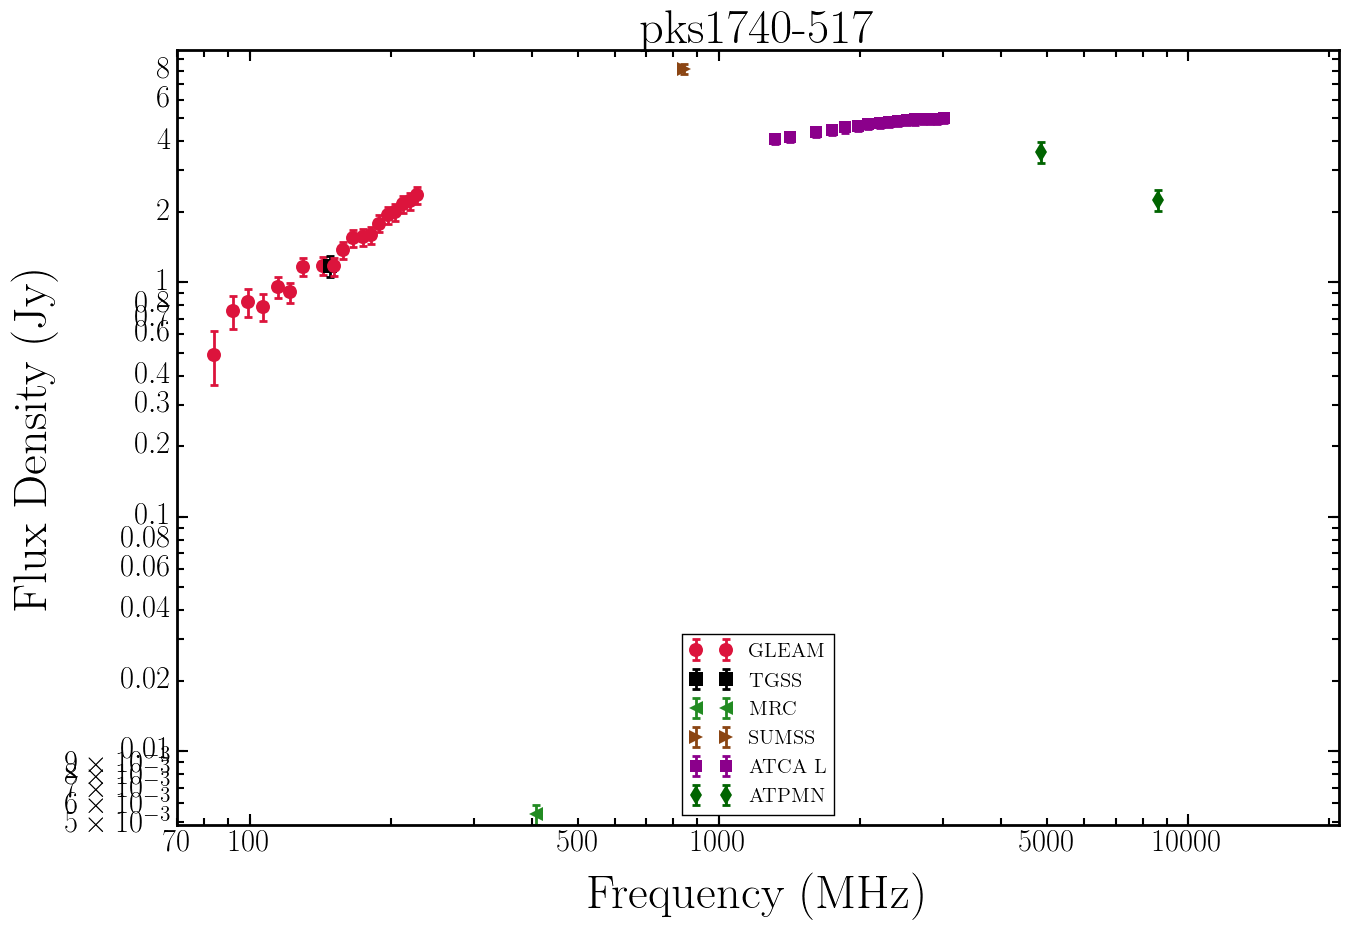

pks1343-300


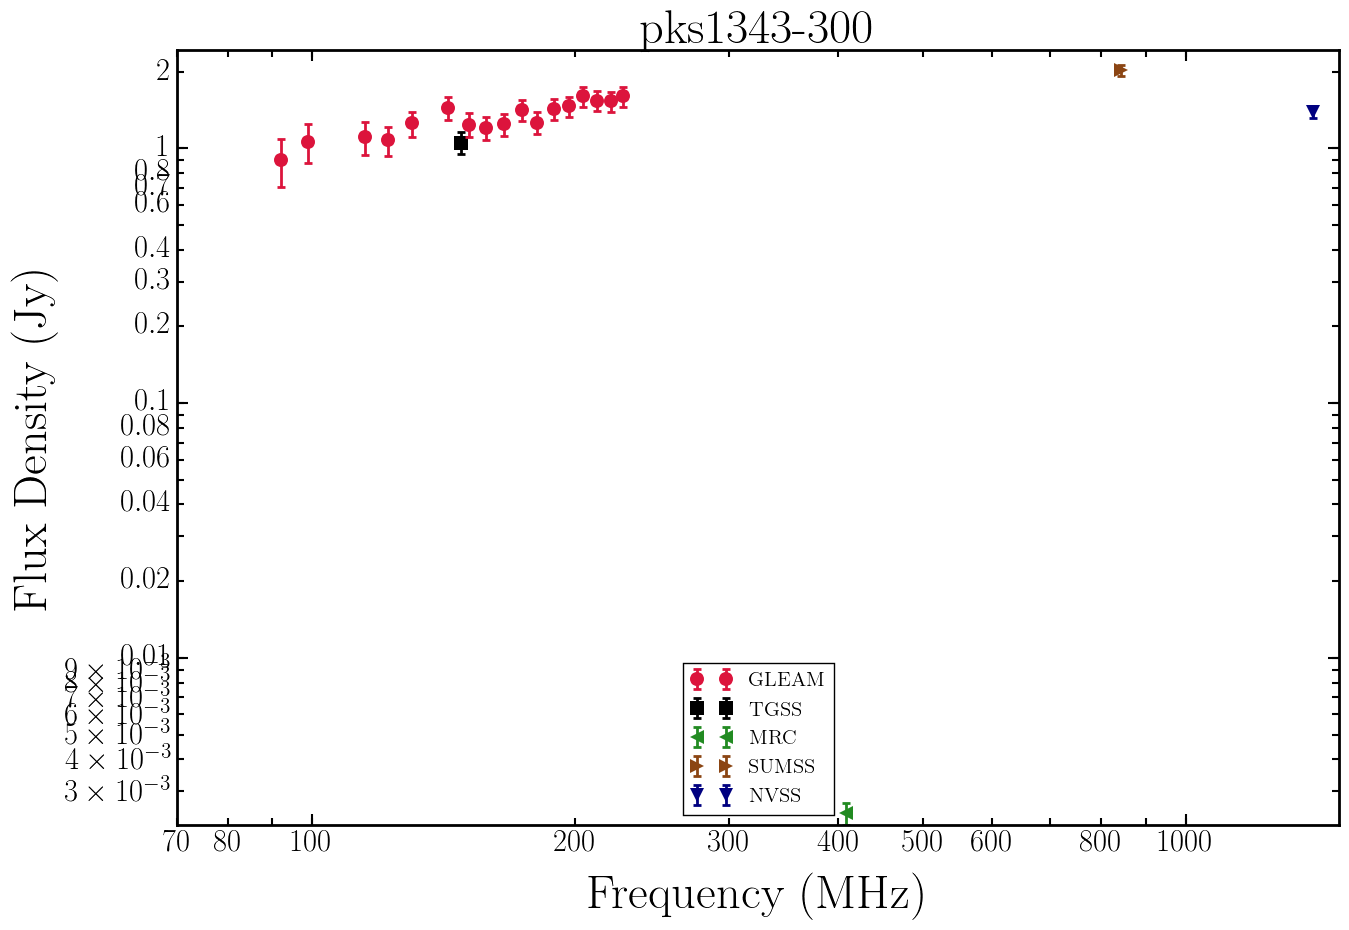

pks1827-360


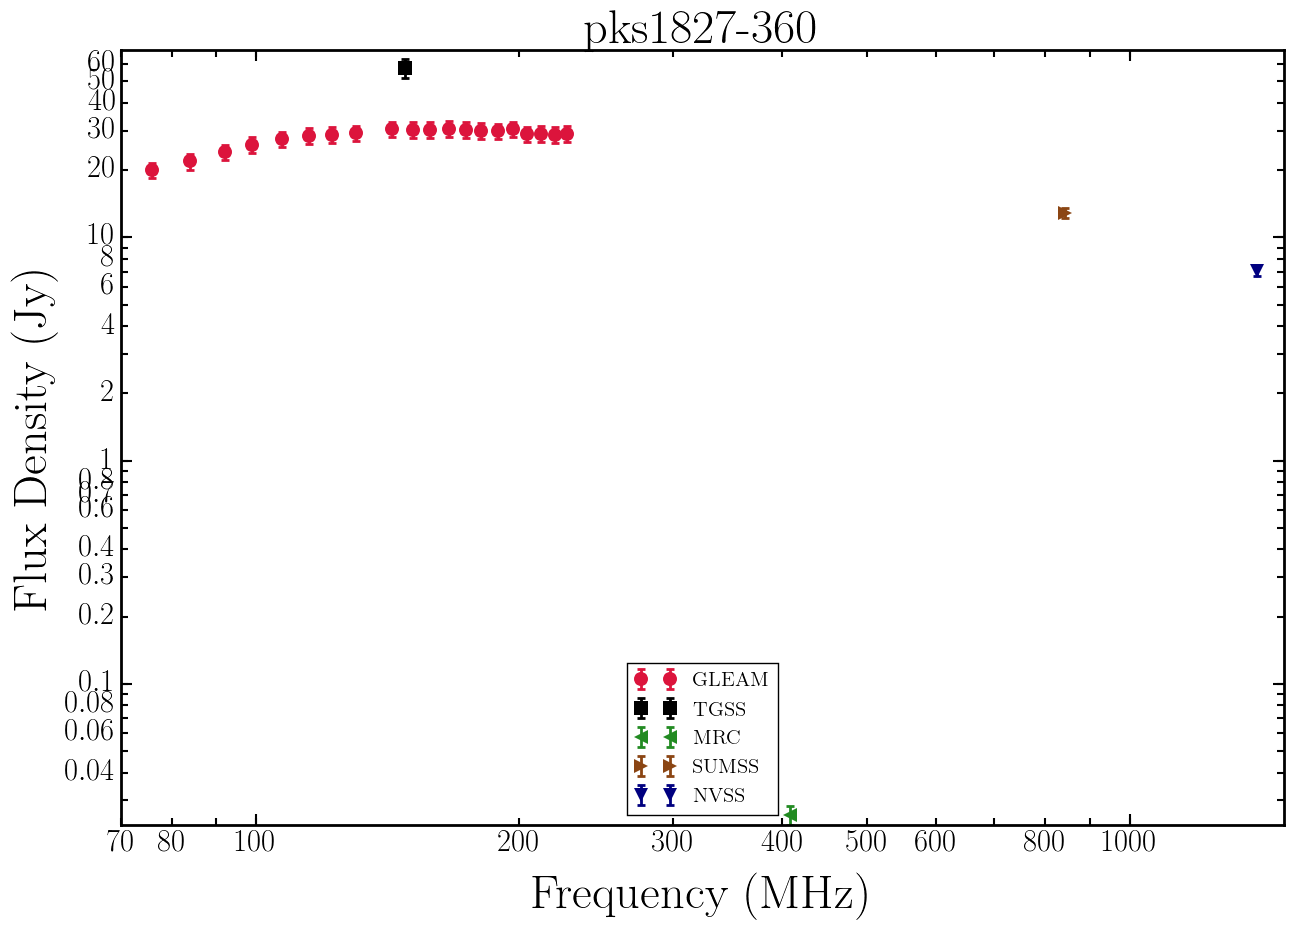

pks2008-068


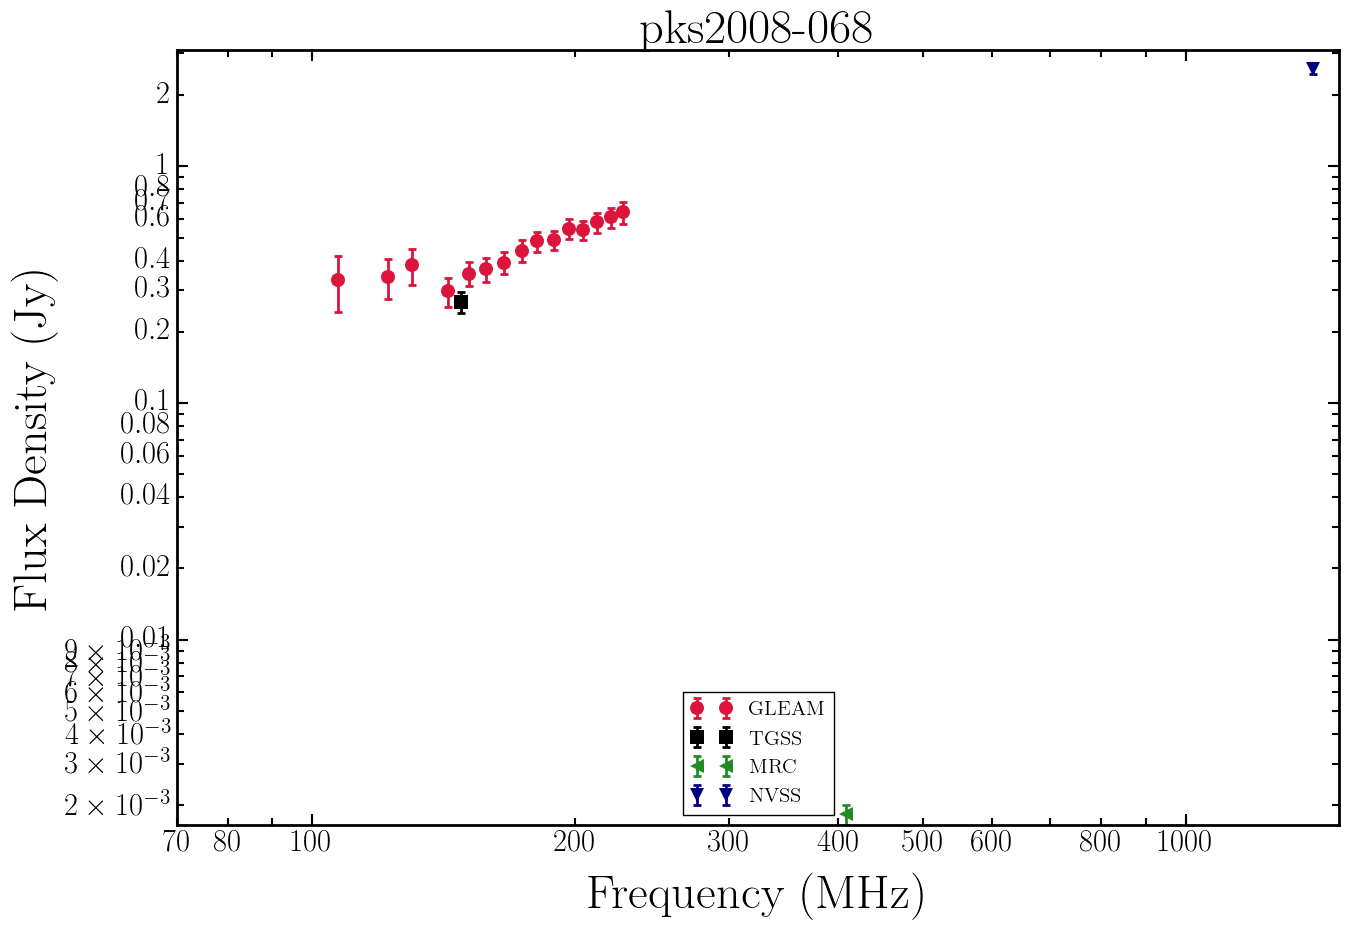

pks1540-077


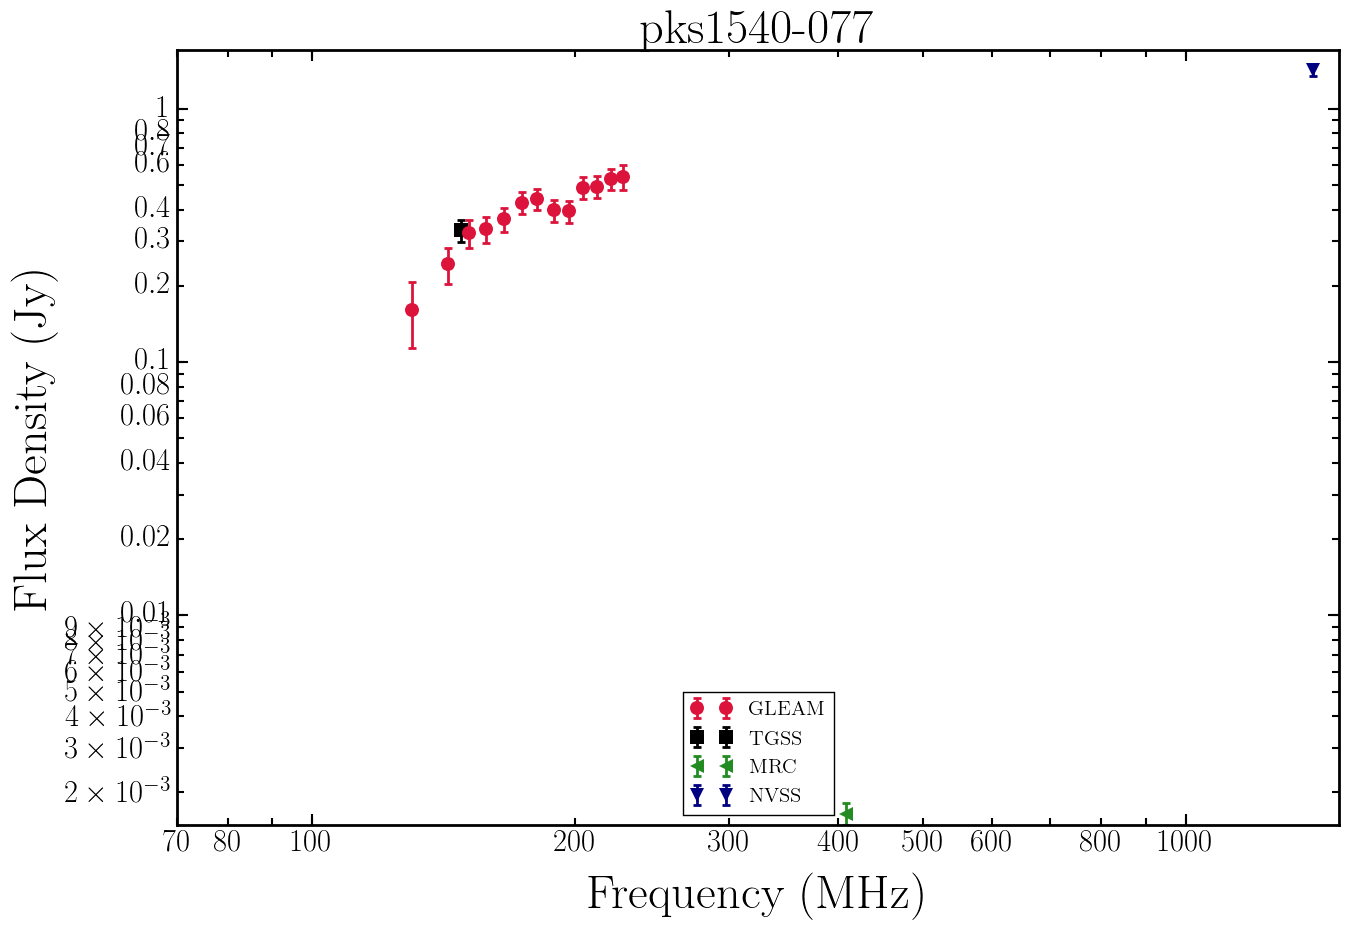

pks1557-00


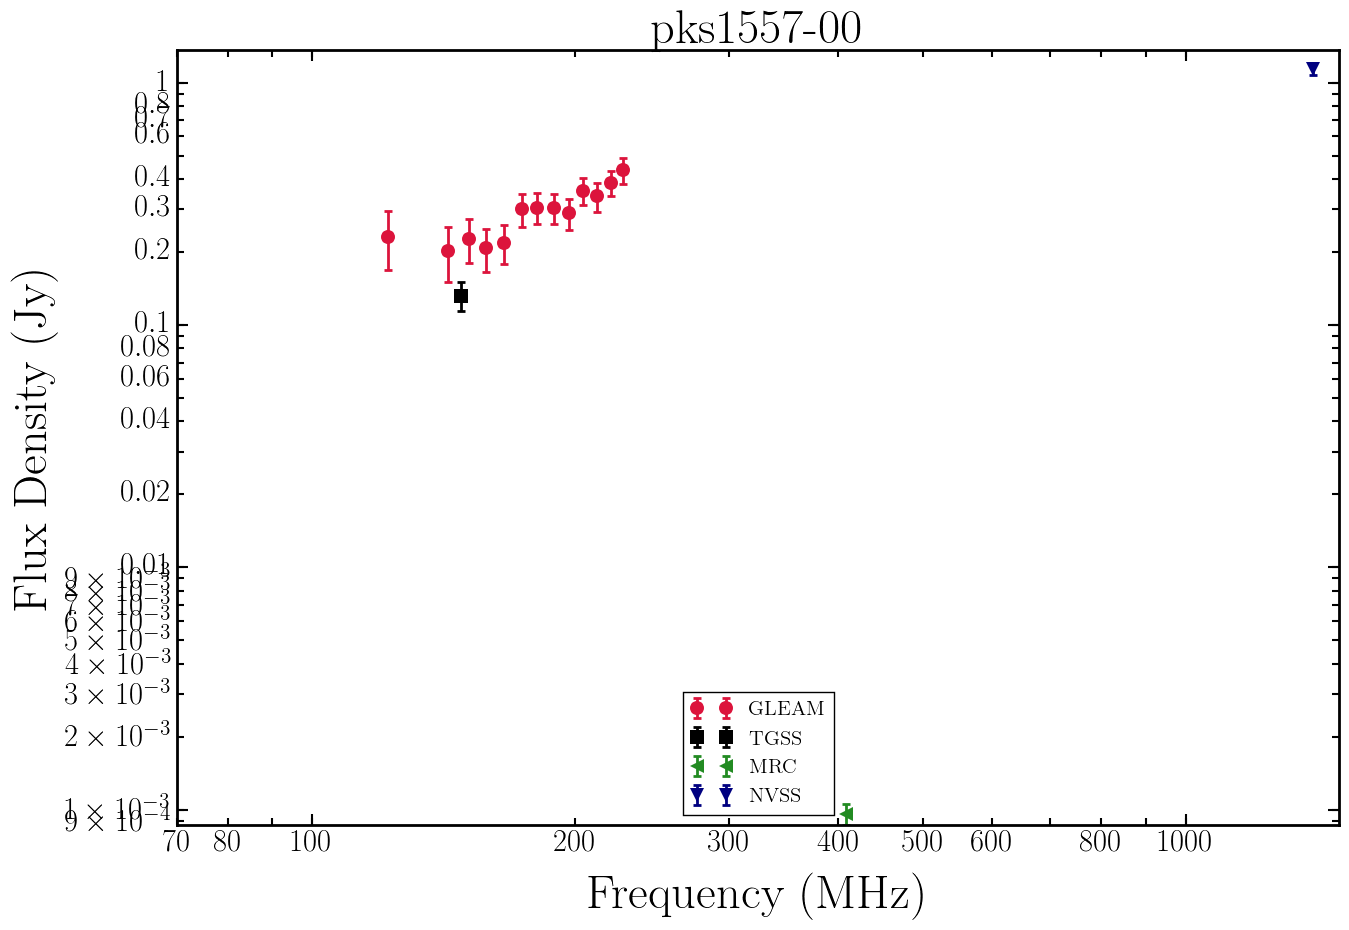

pks1518+047


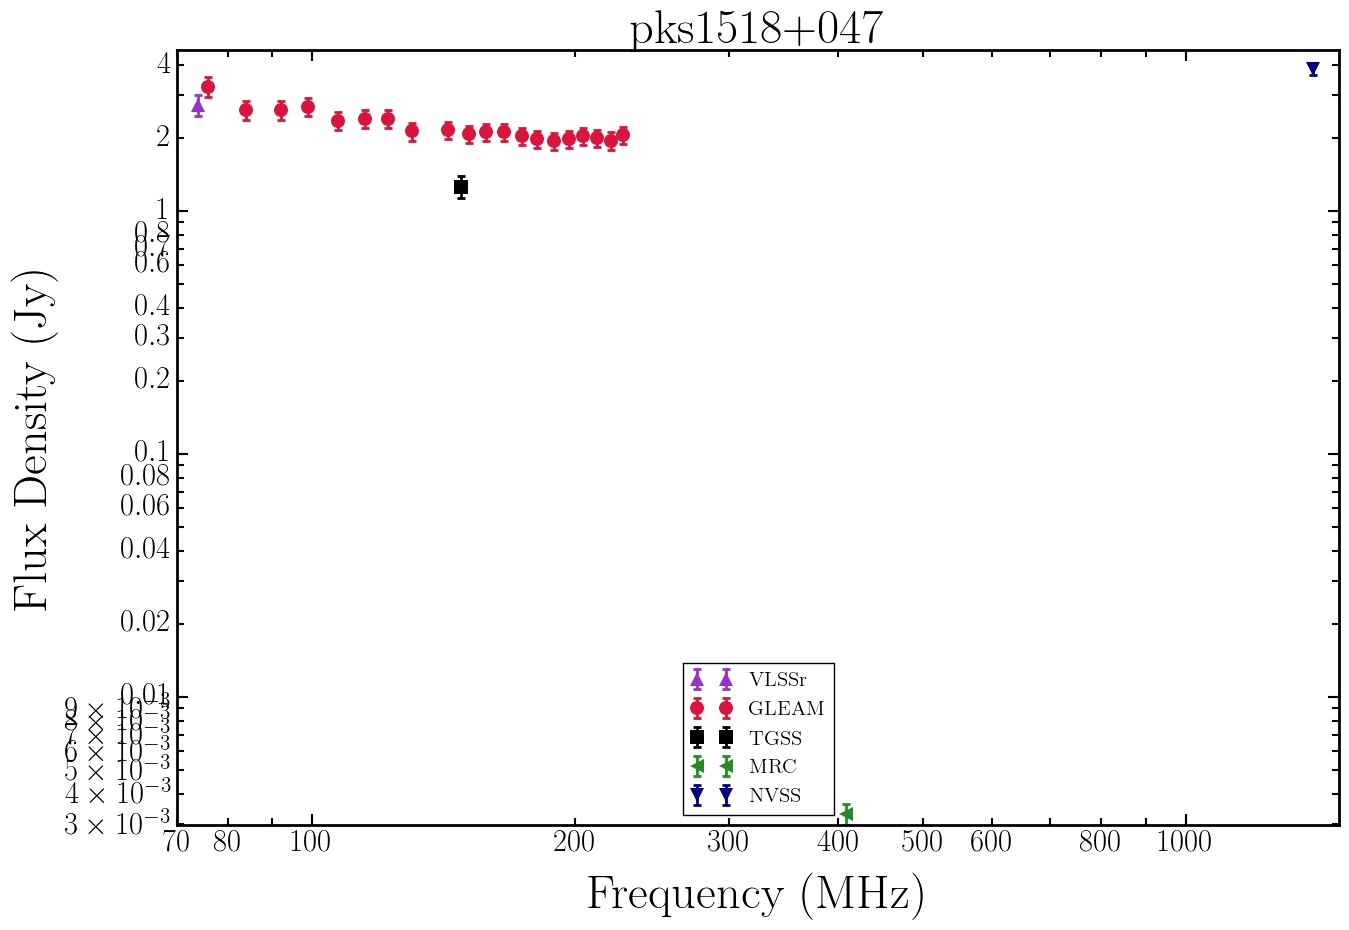

4c+12.60


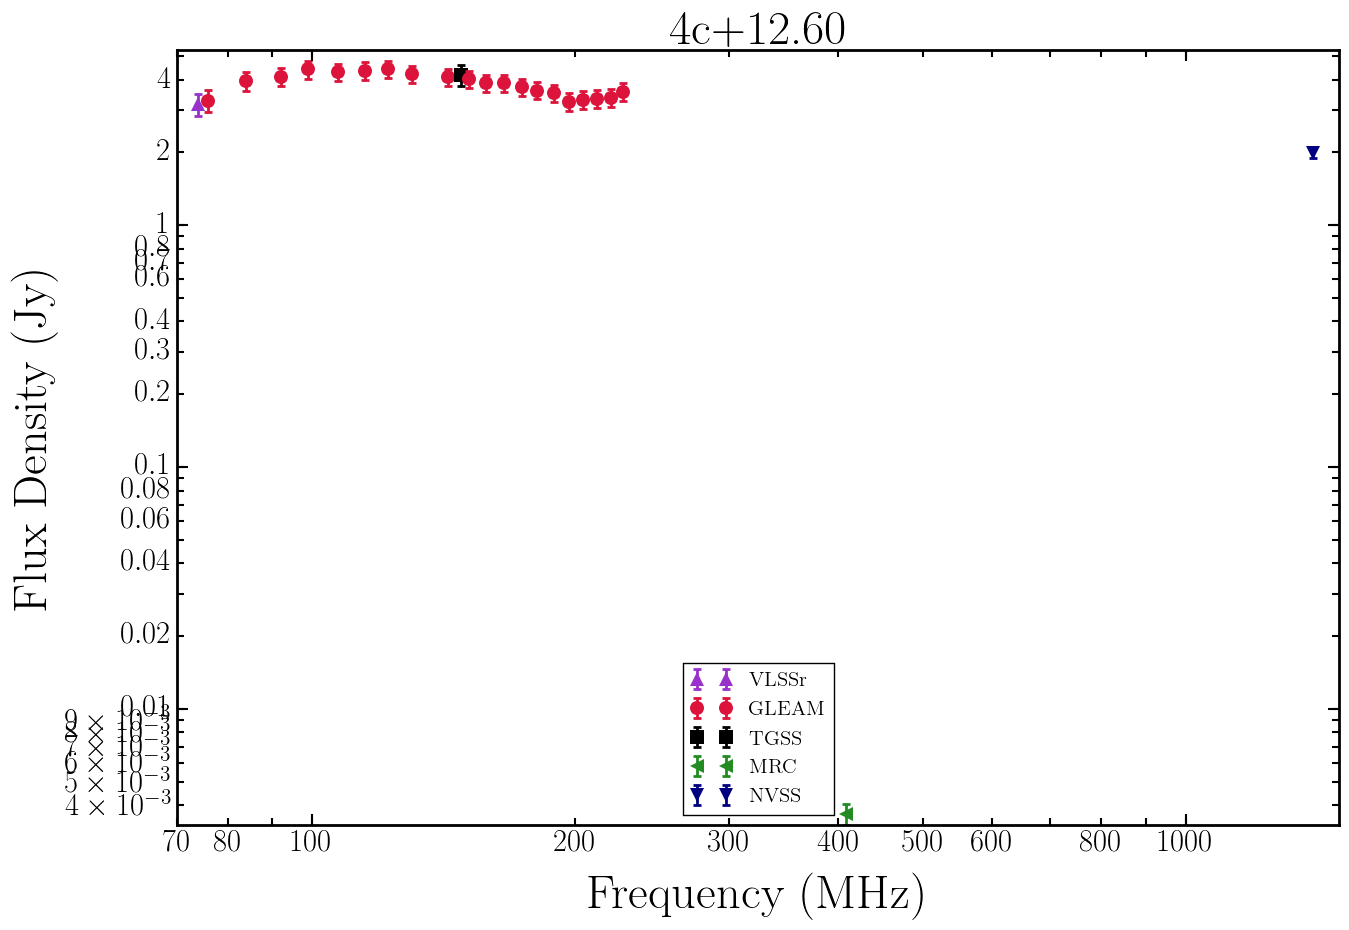

0823-500


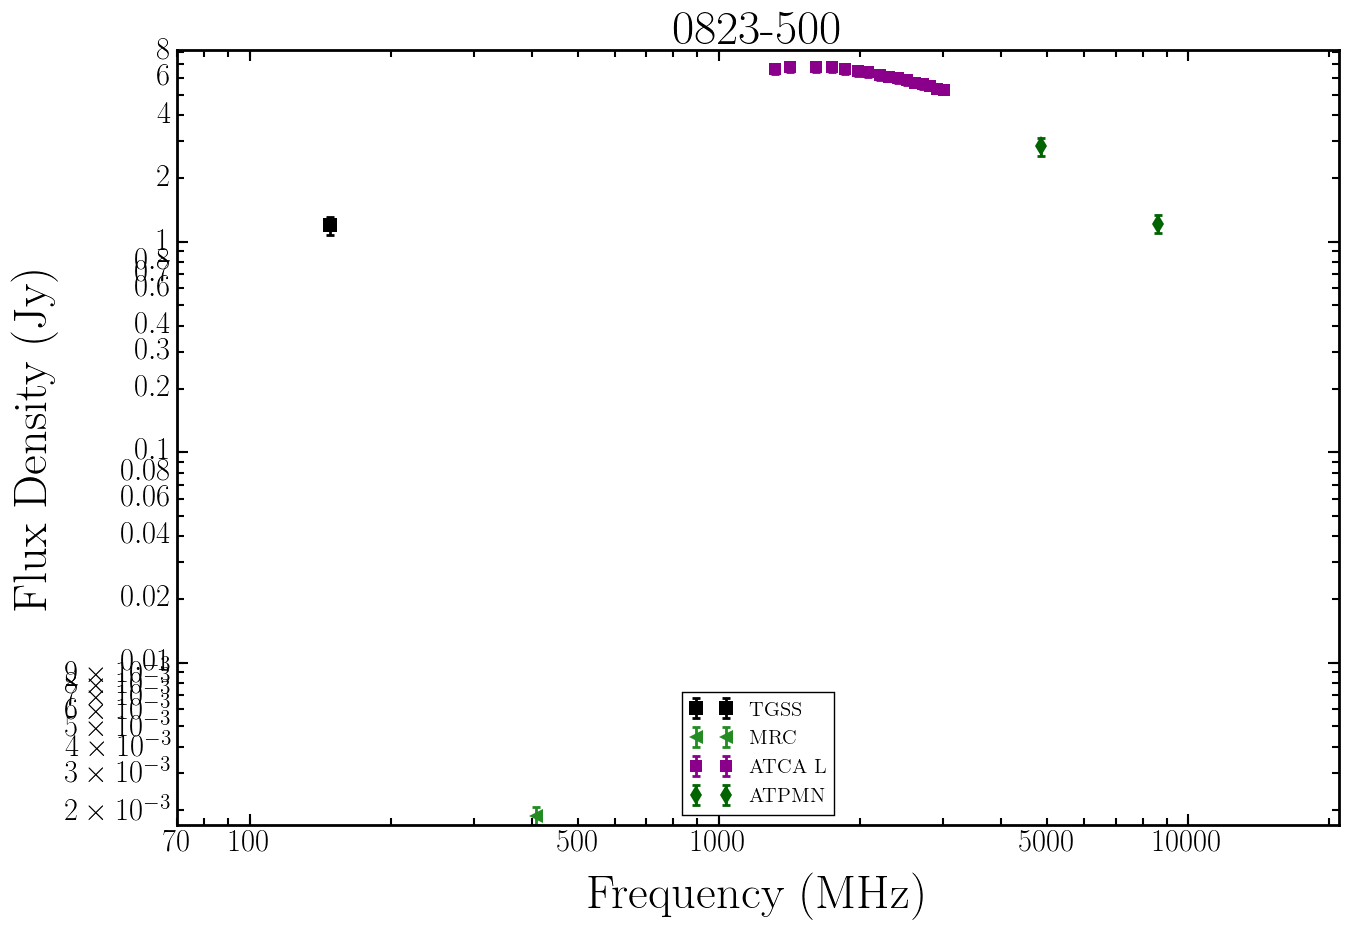

1733-565


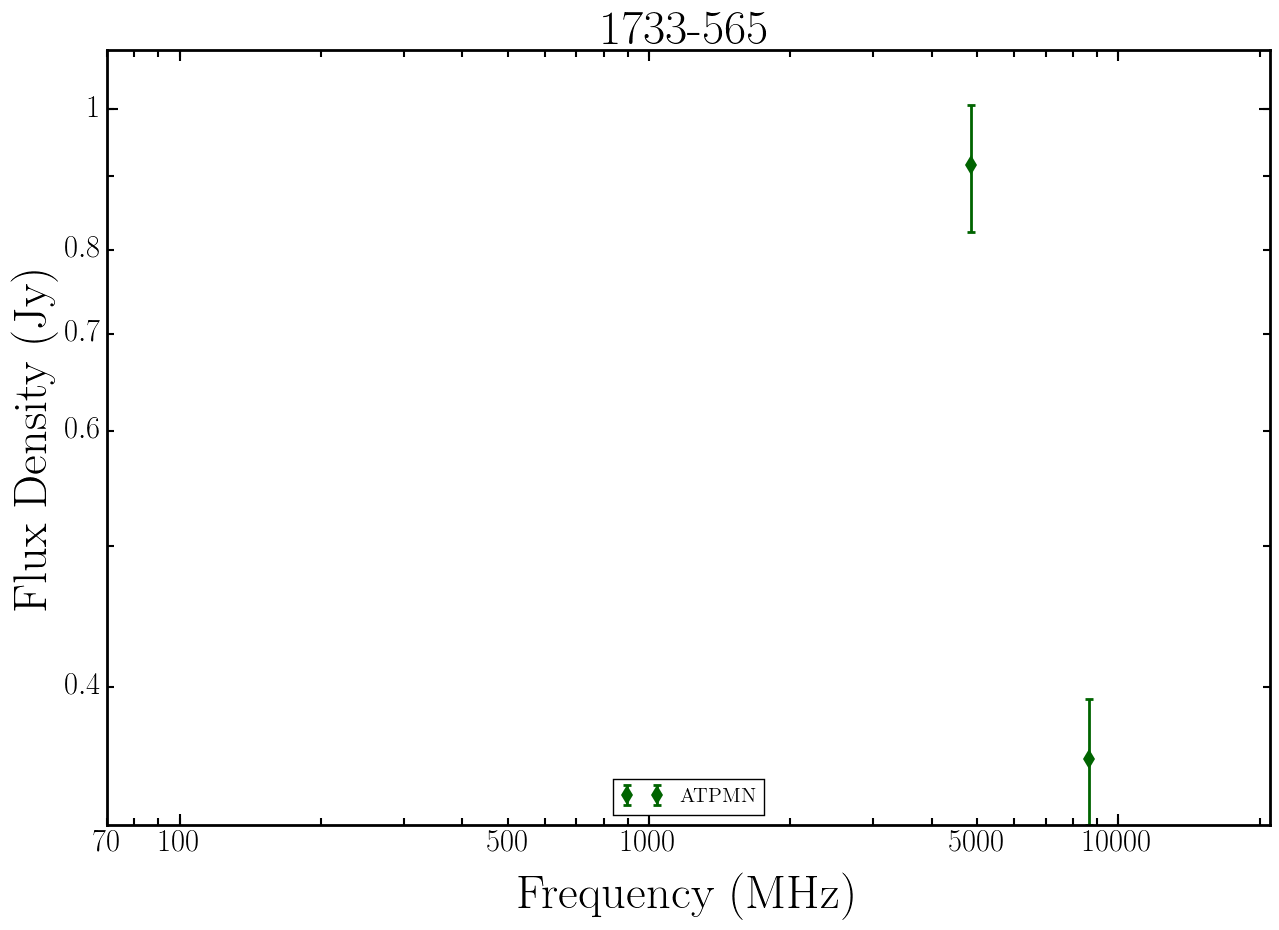

pks1120-274


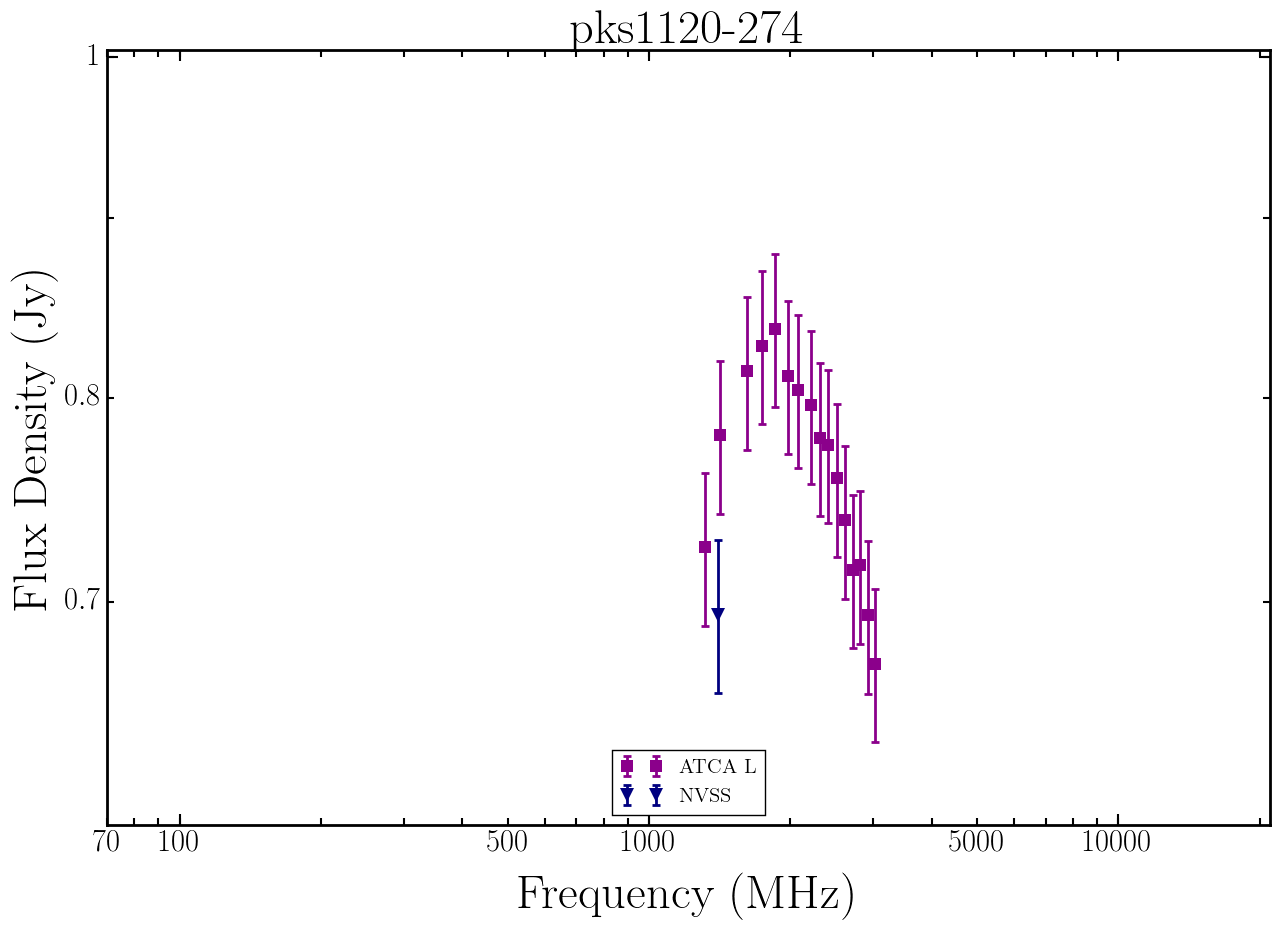

mwacsj2336.2-5236


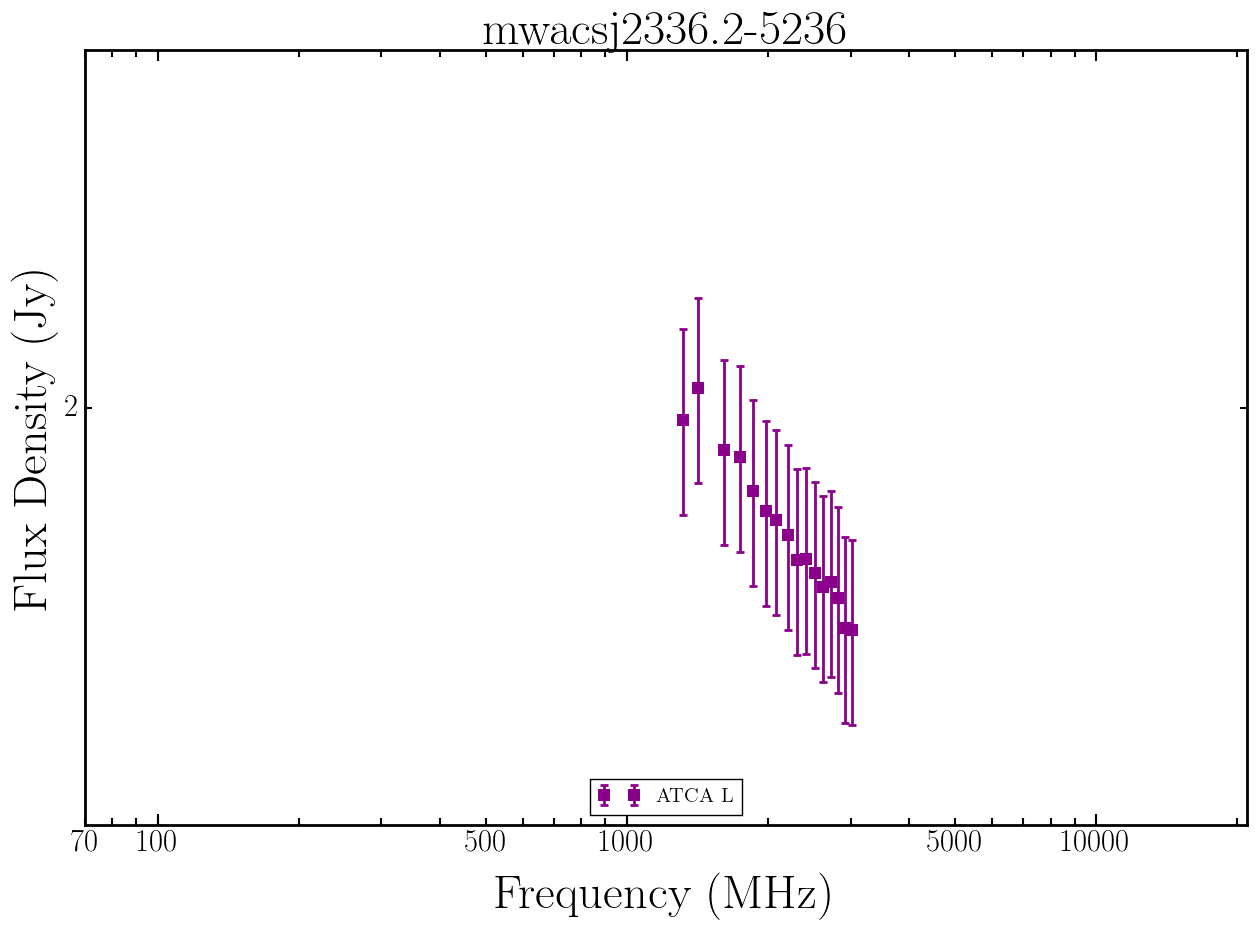

mwacsj0408.0-2757


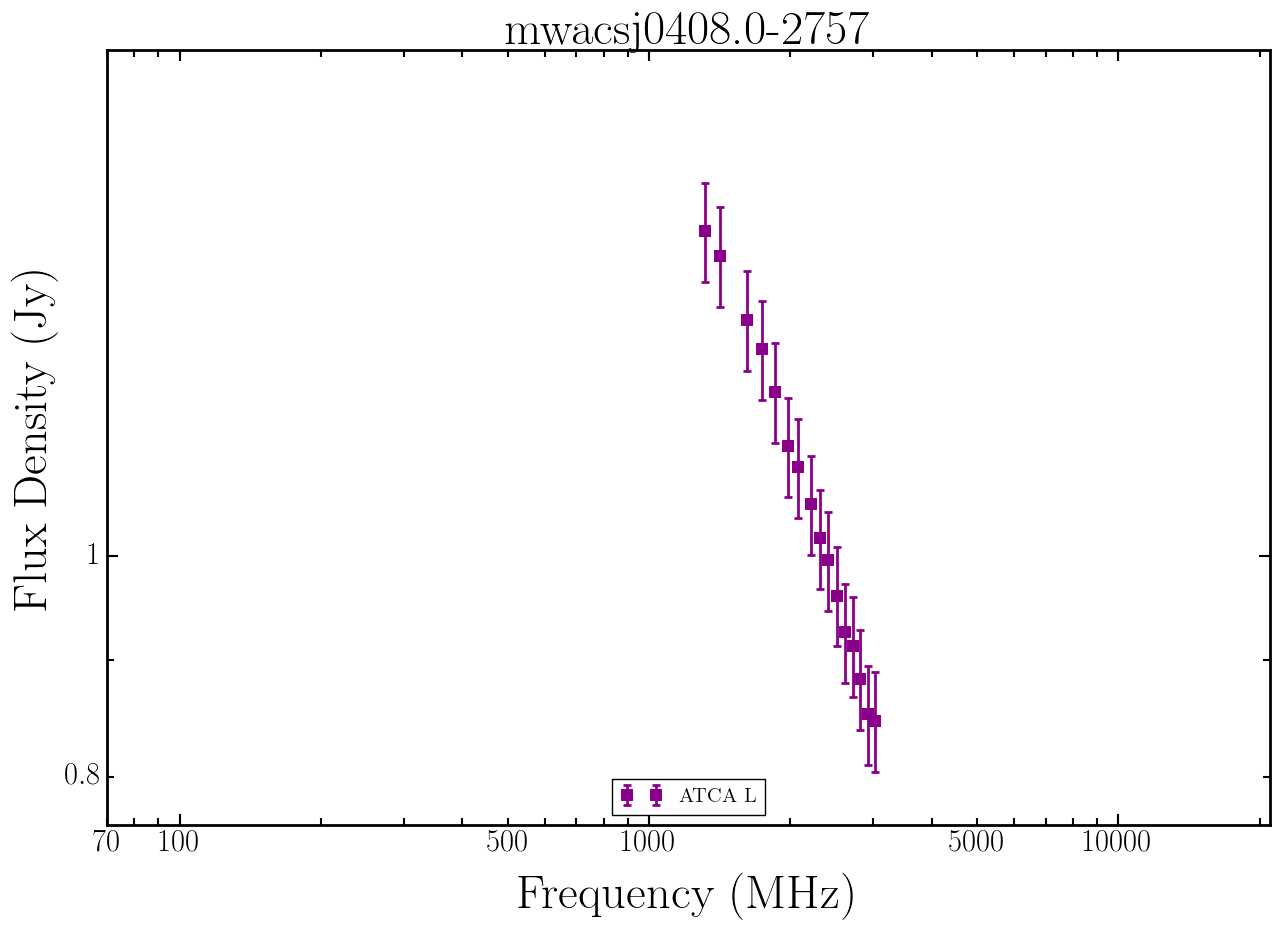

pks1732+094


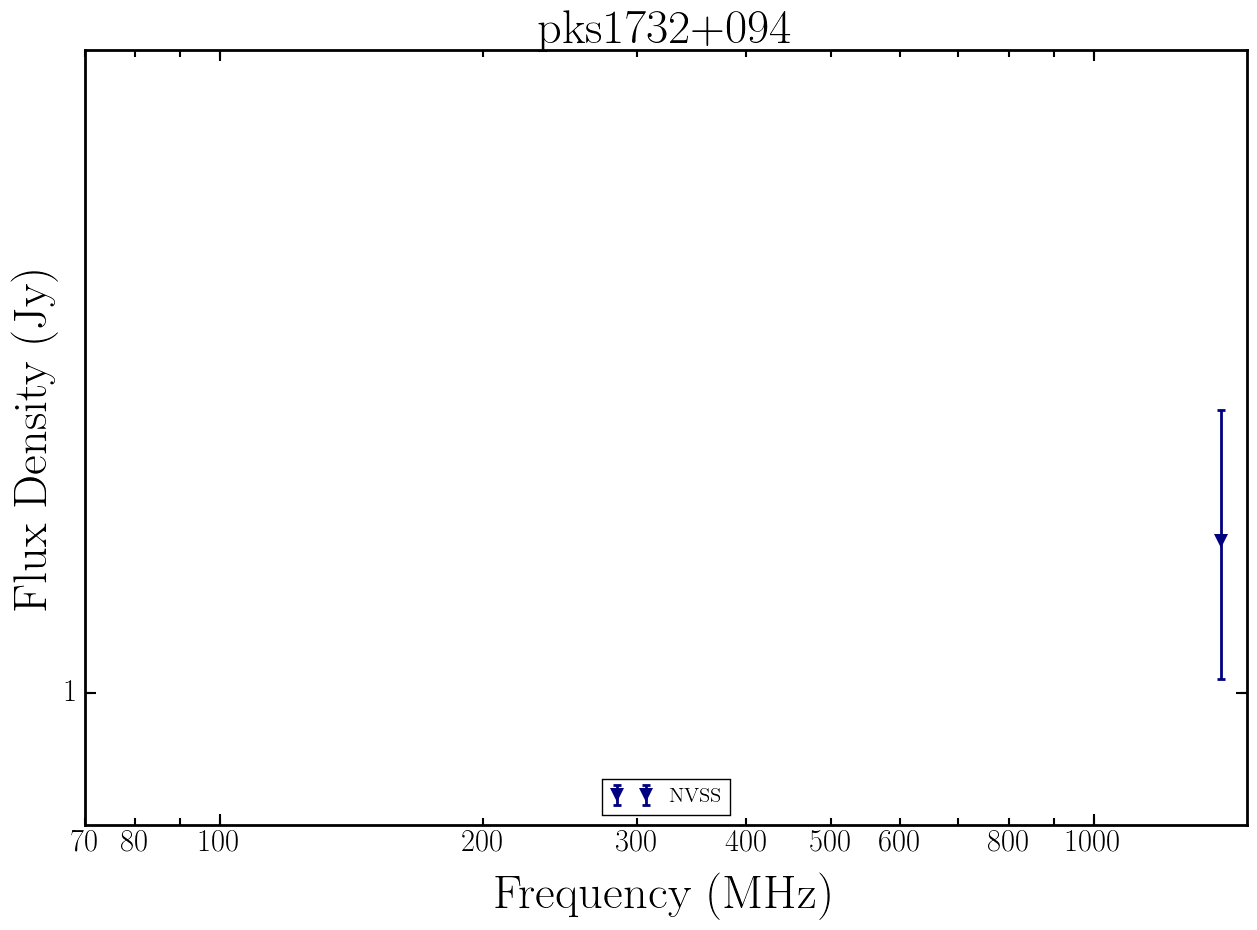

pks2149+056


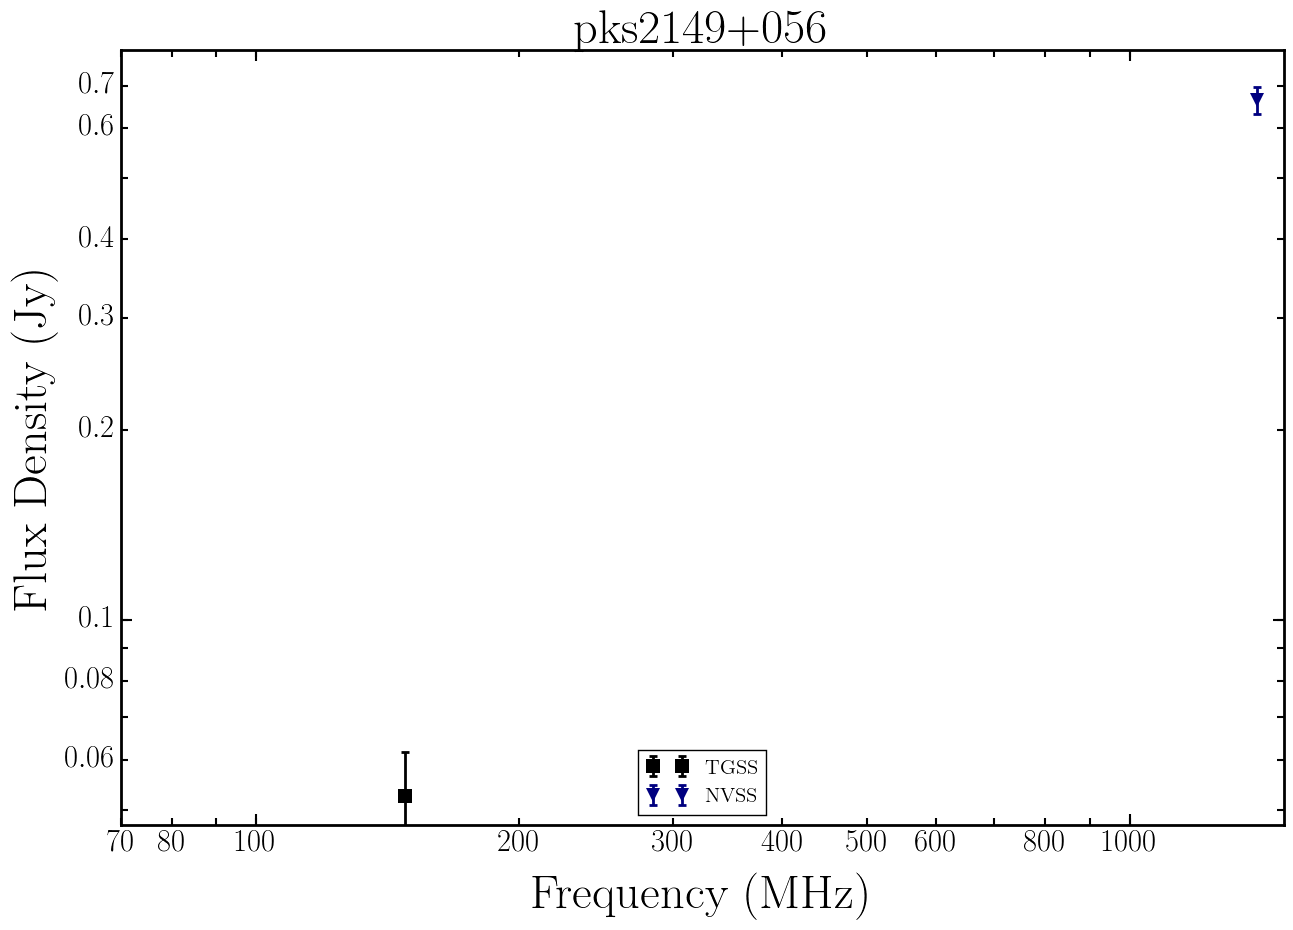

pks2254-367


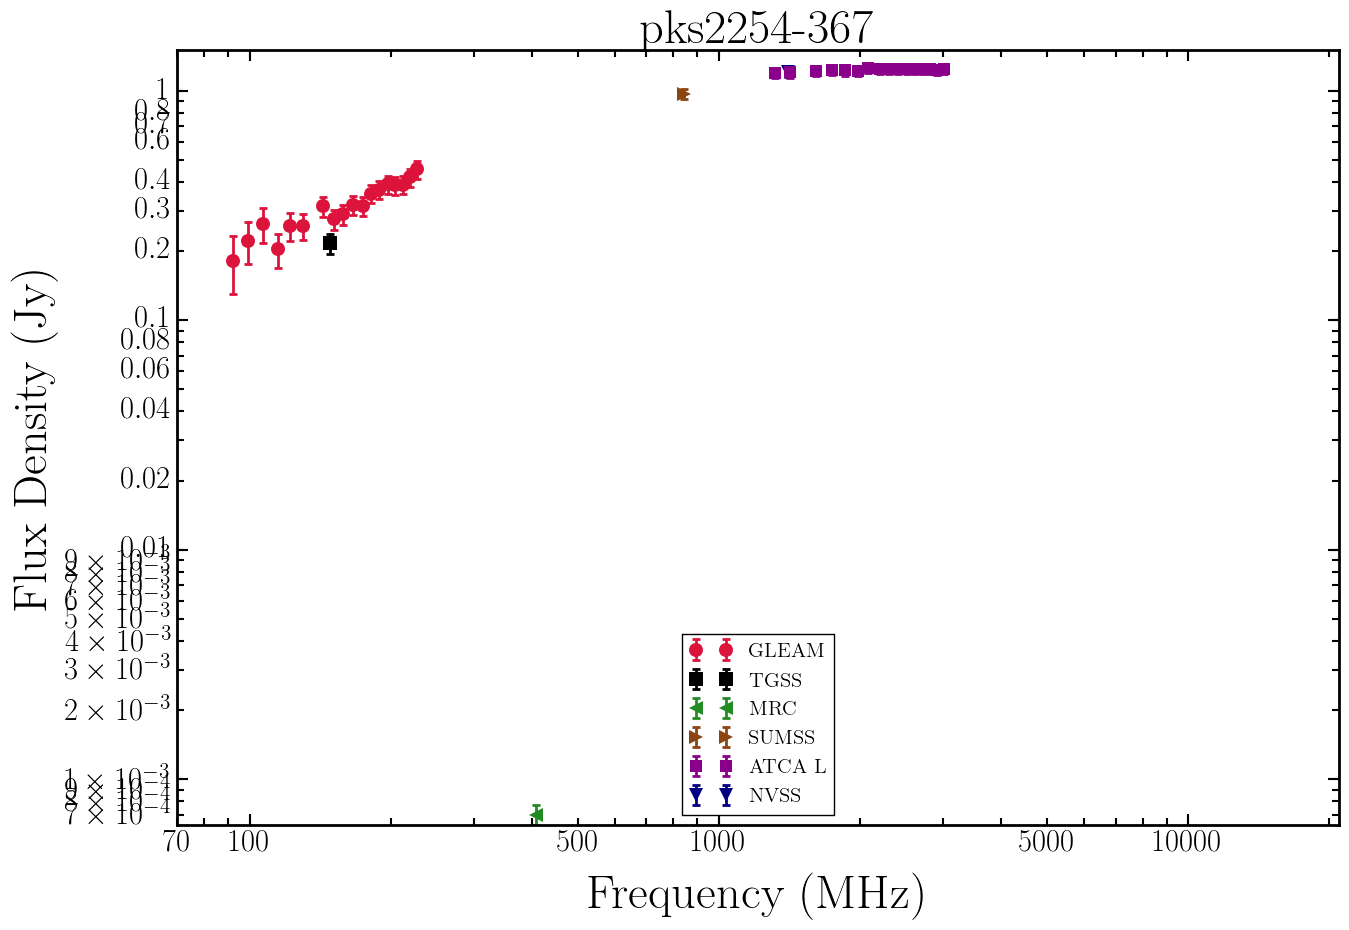

['2135-209' 'pks2135-209']


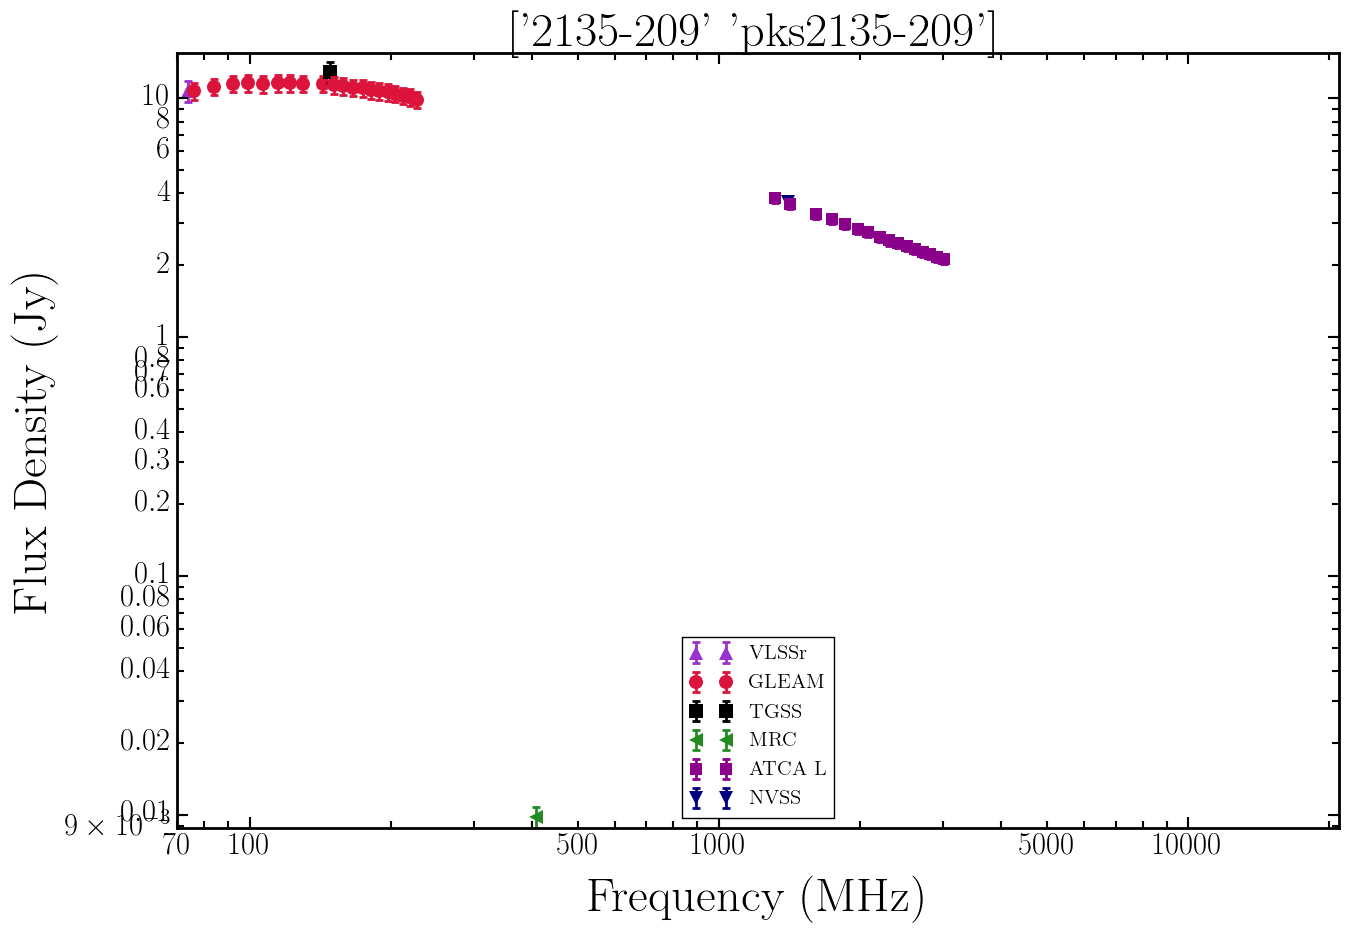

pks2121-01


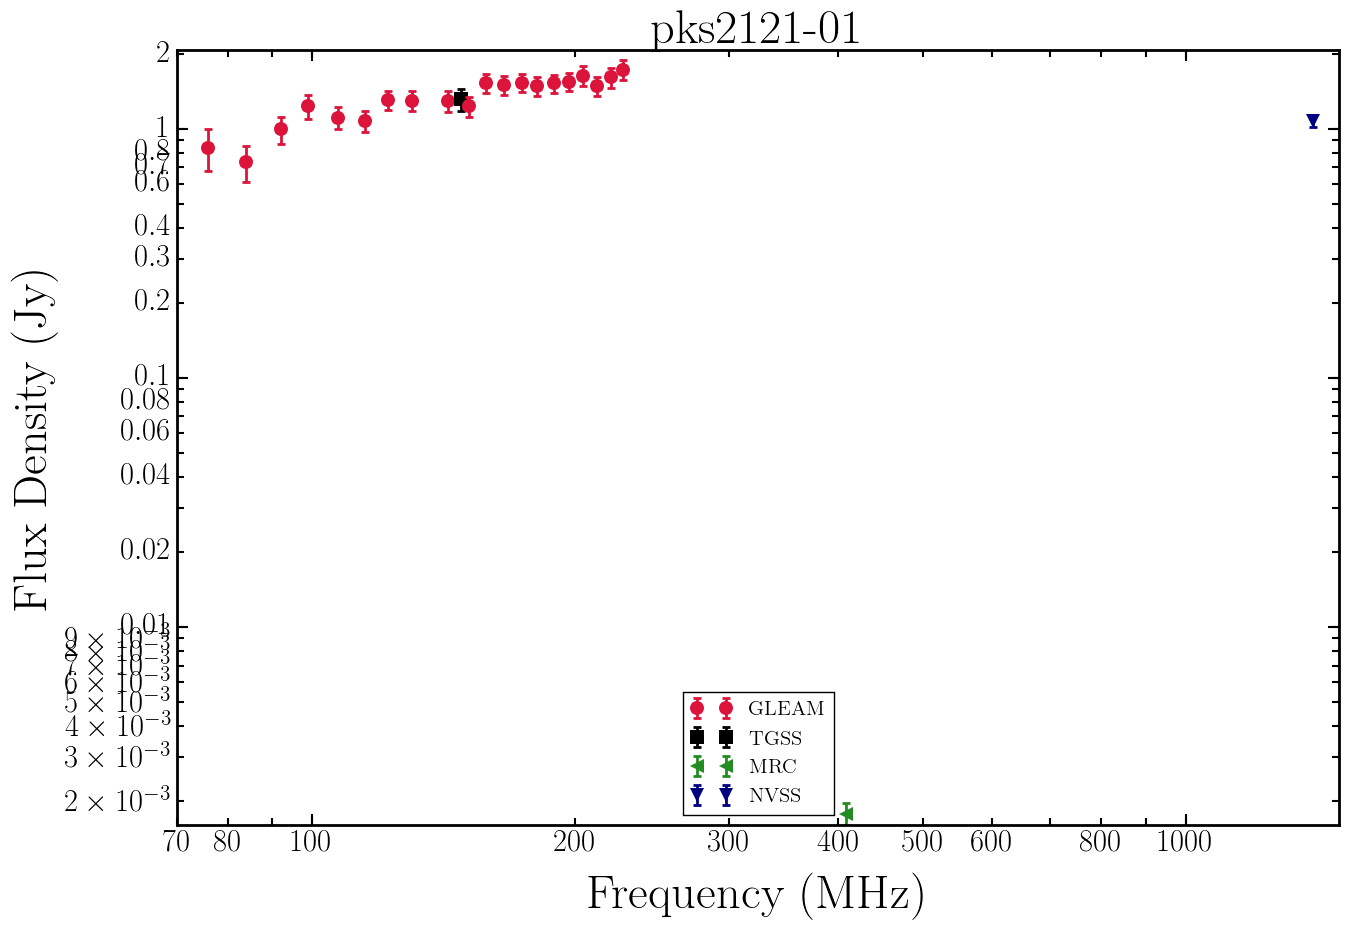

['0022-423' 'pks0022-423']


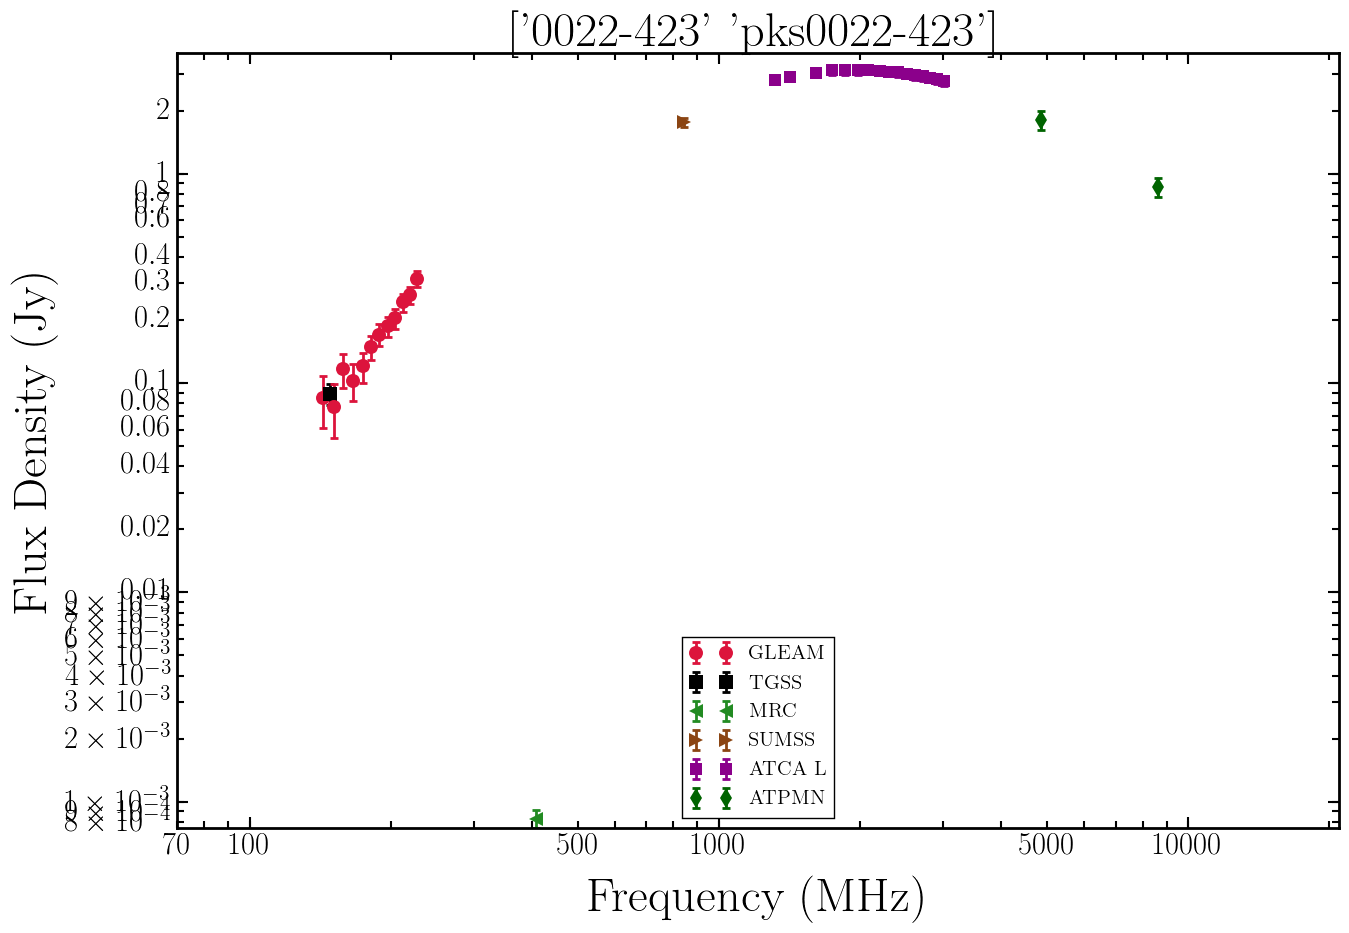

pks0439-337


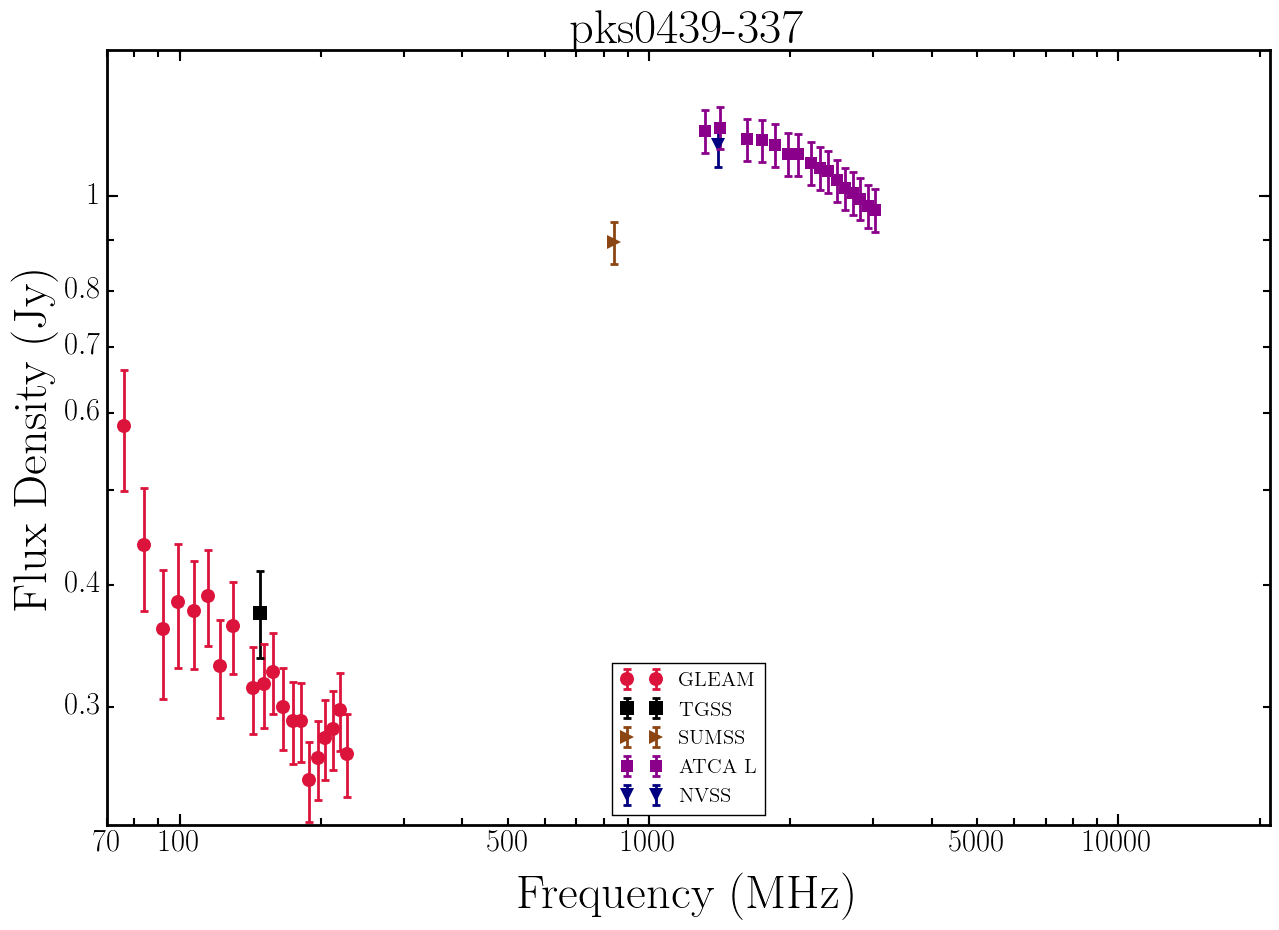

pks0405-280


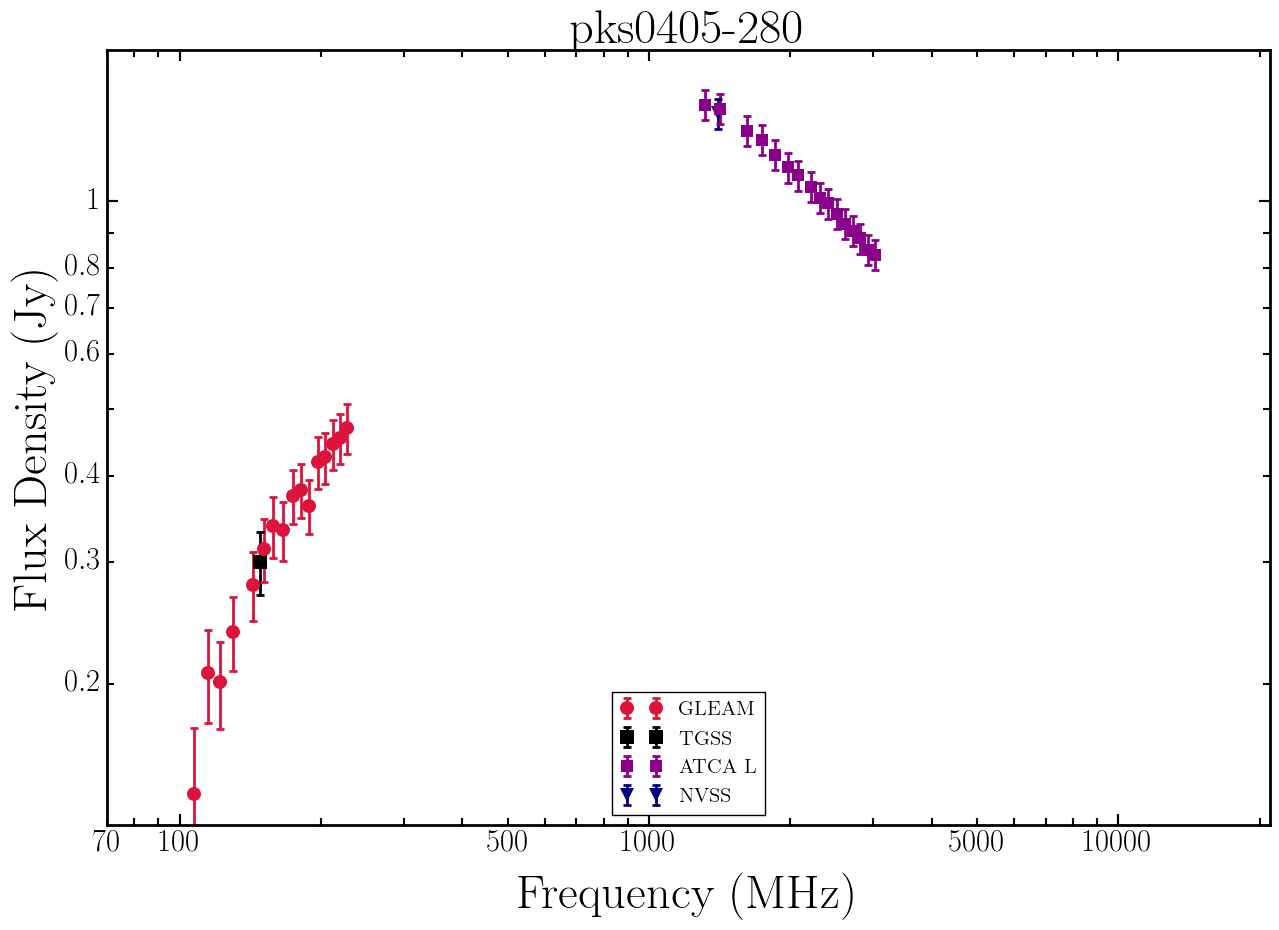

pks0105-122


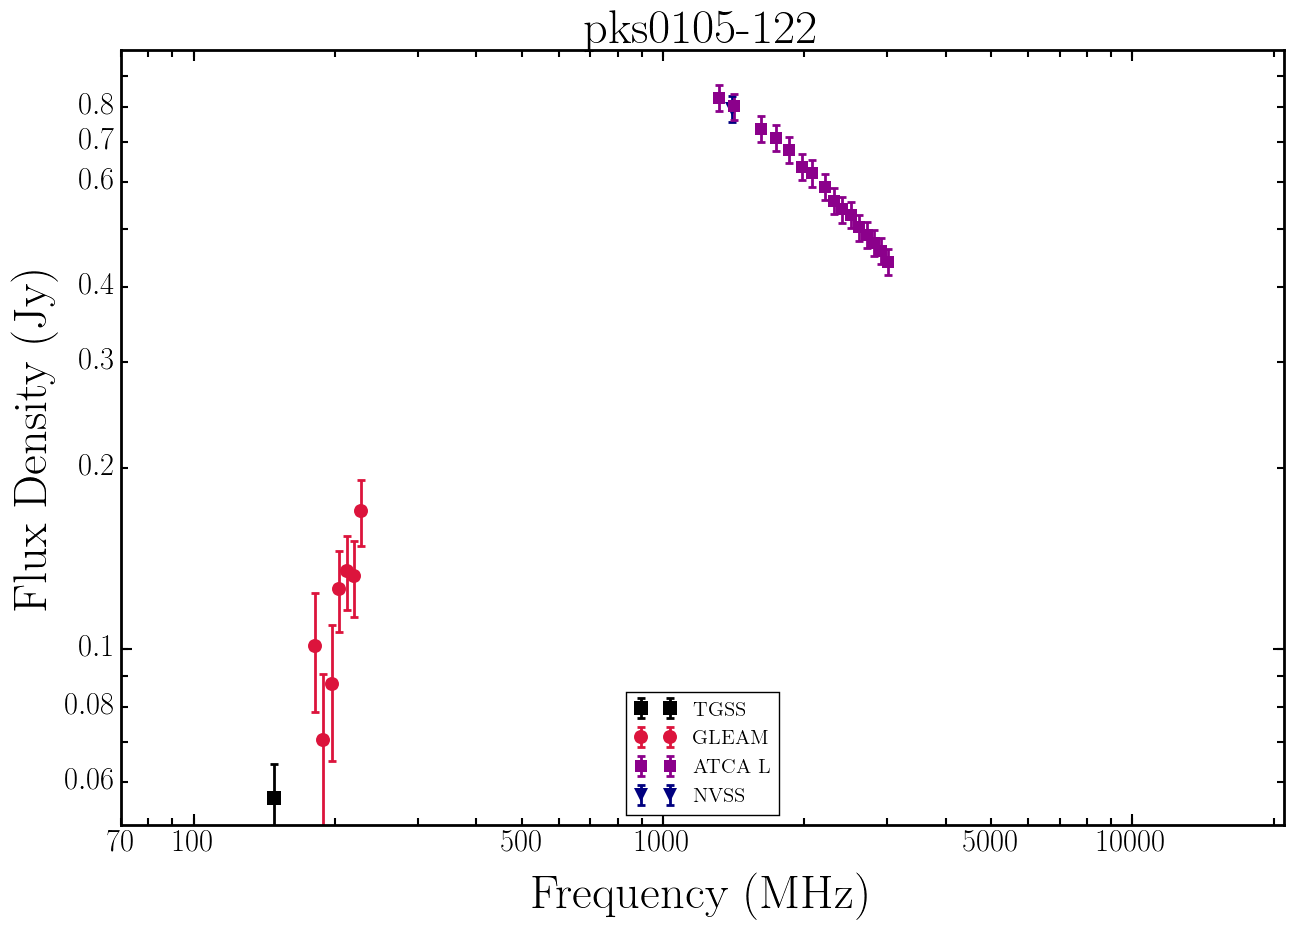

pks0500+019


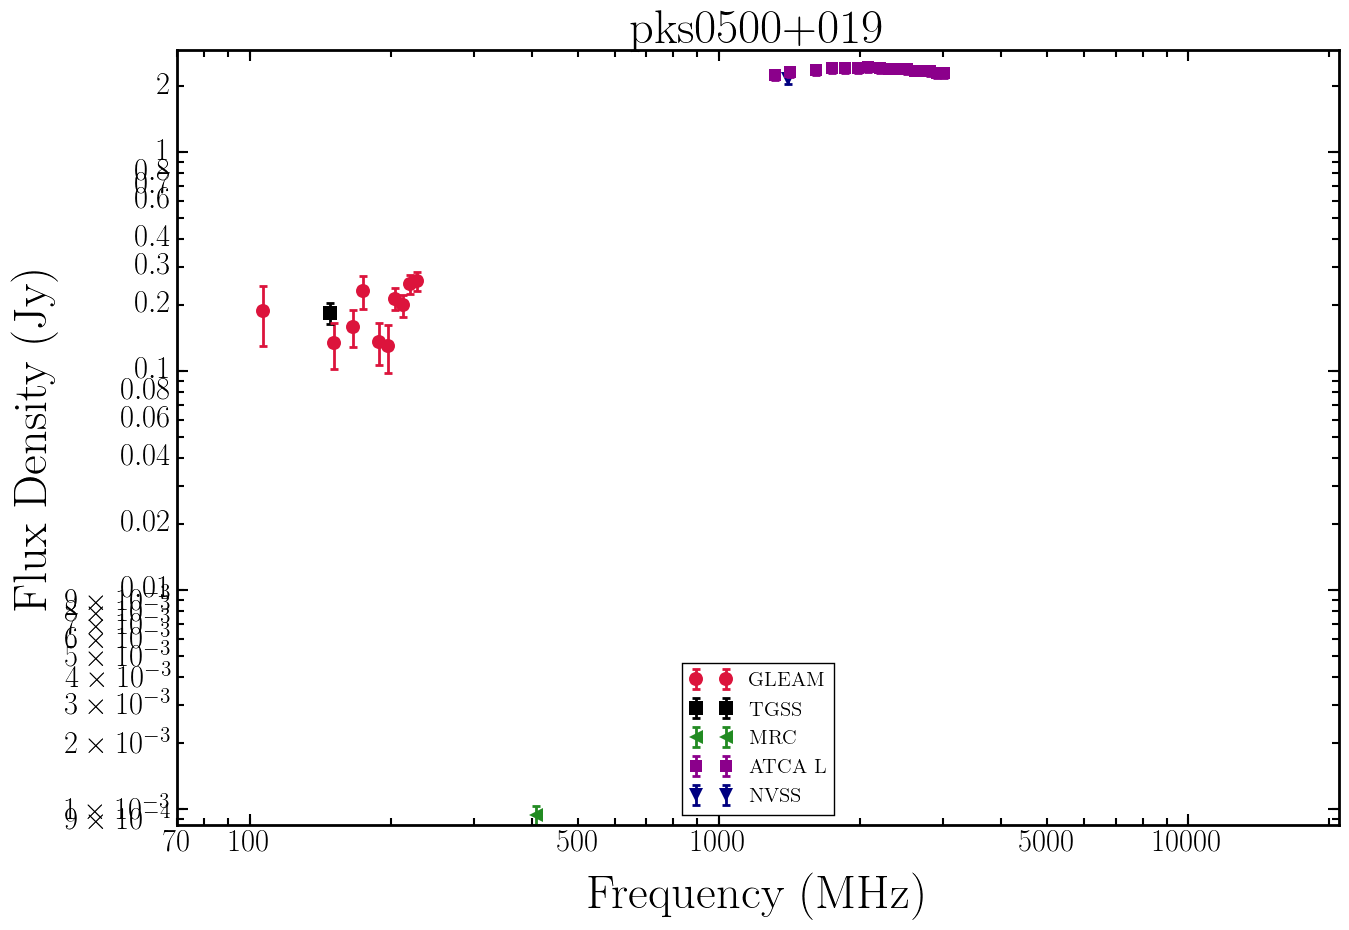

['pks1151-348' '1151-348']


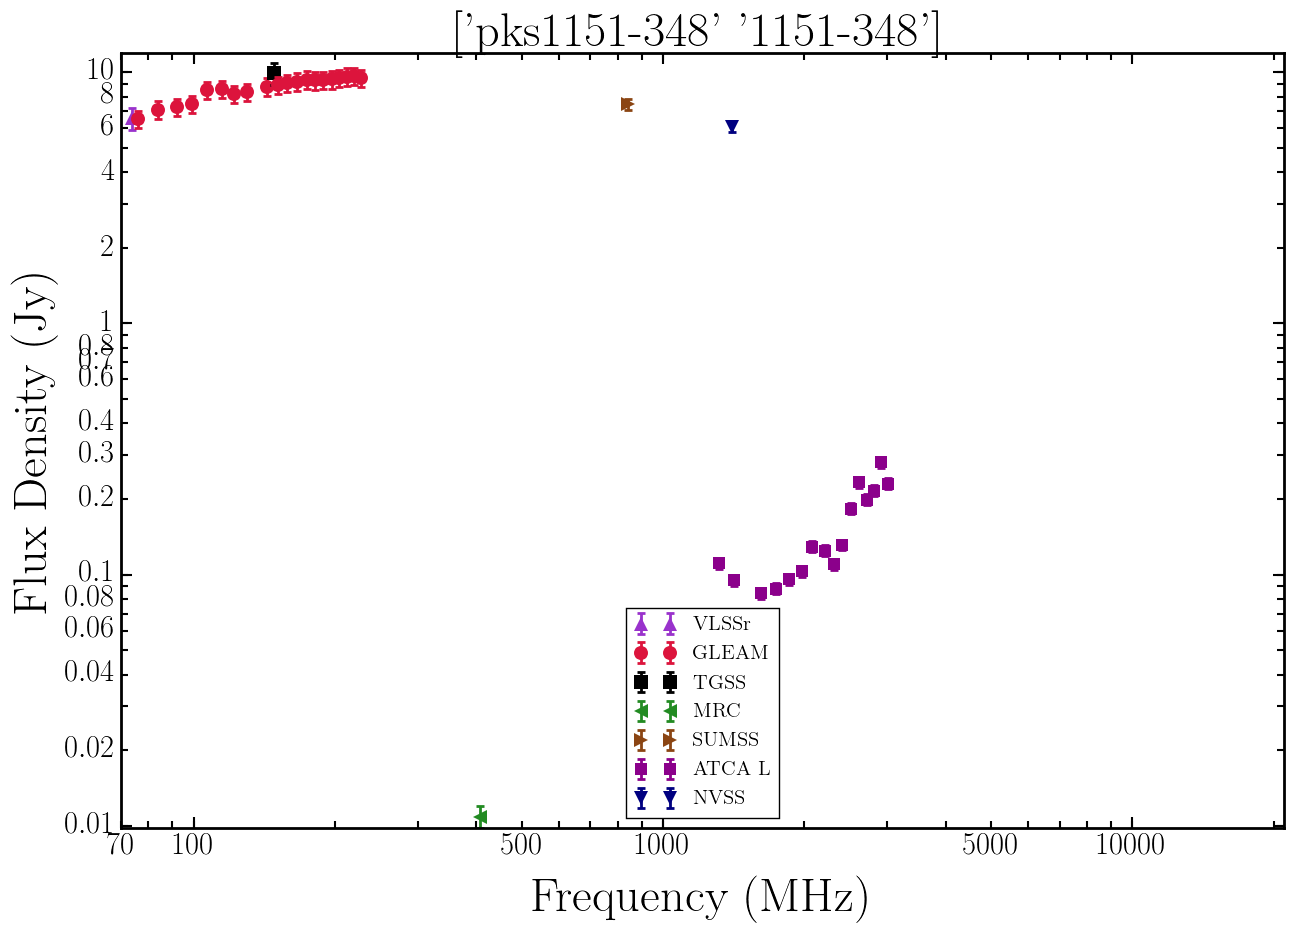

3c283


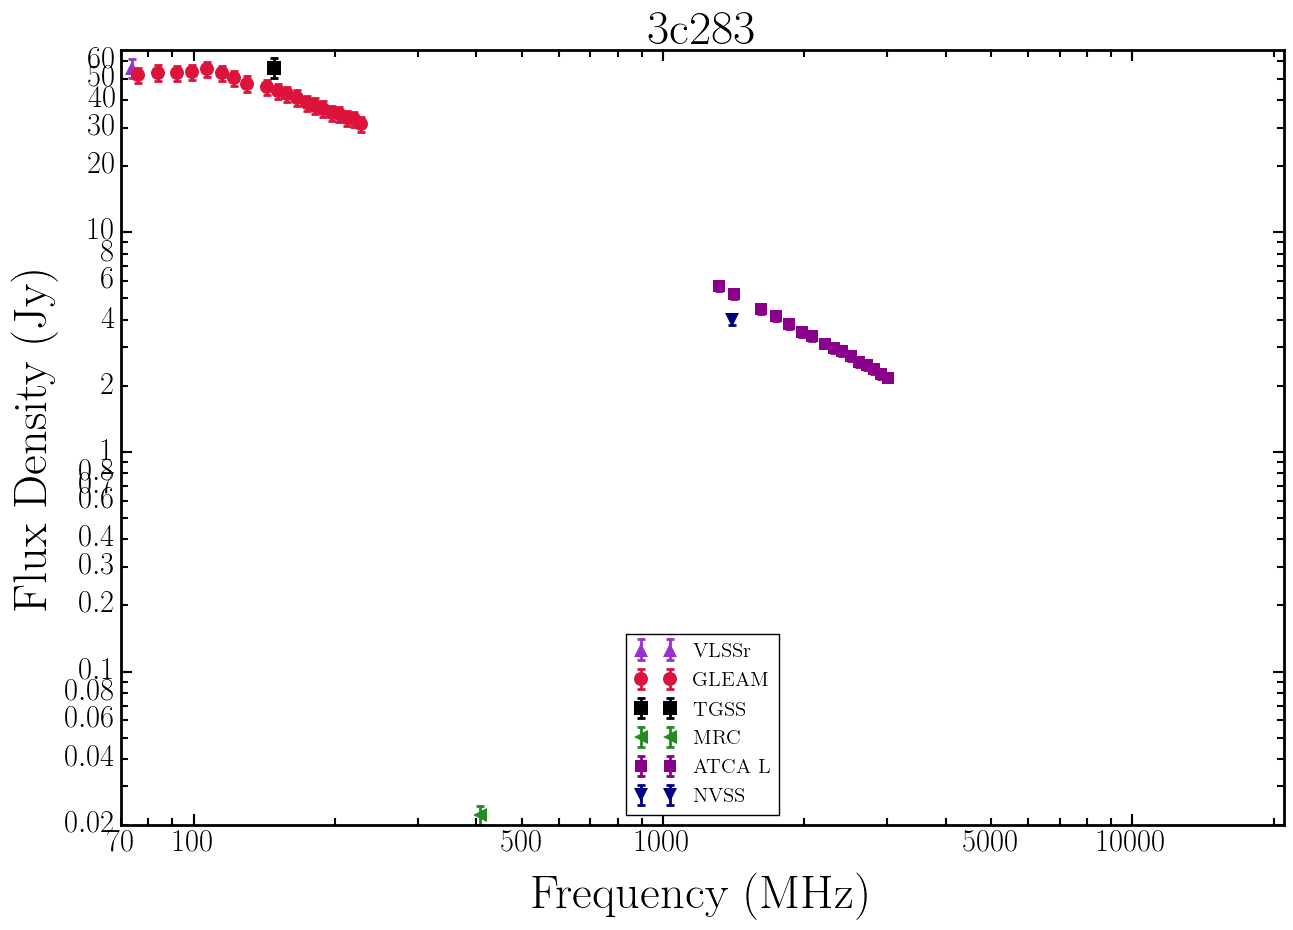

['1245-197' 'pks1245-197']
pks0941-080


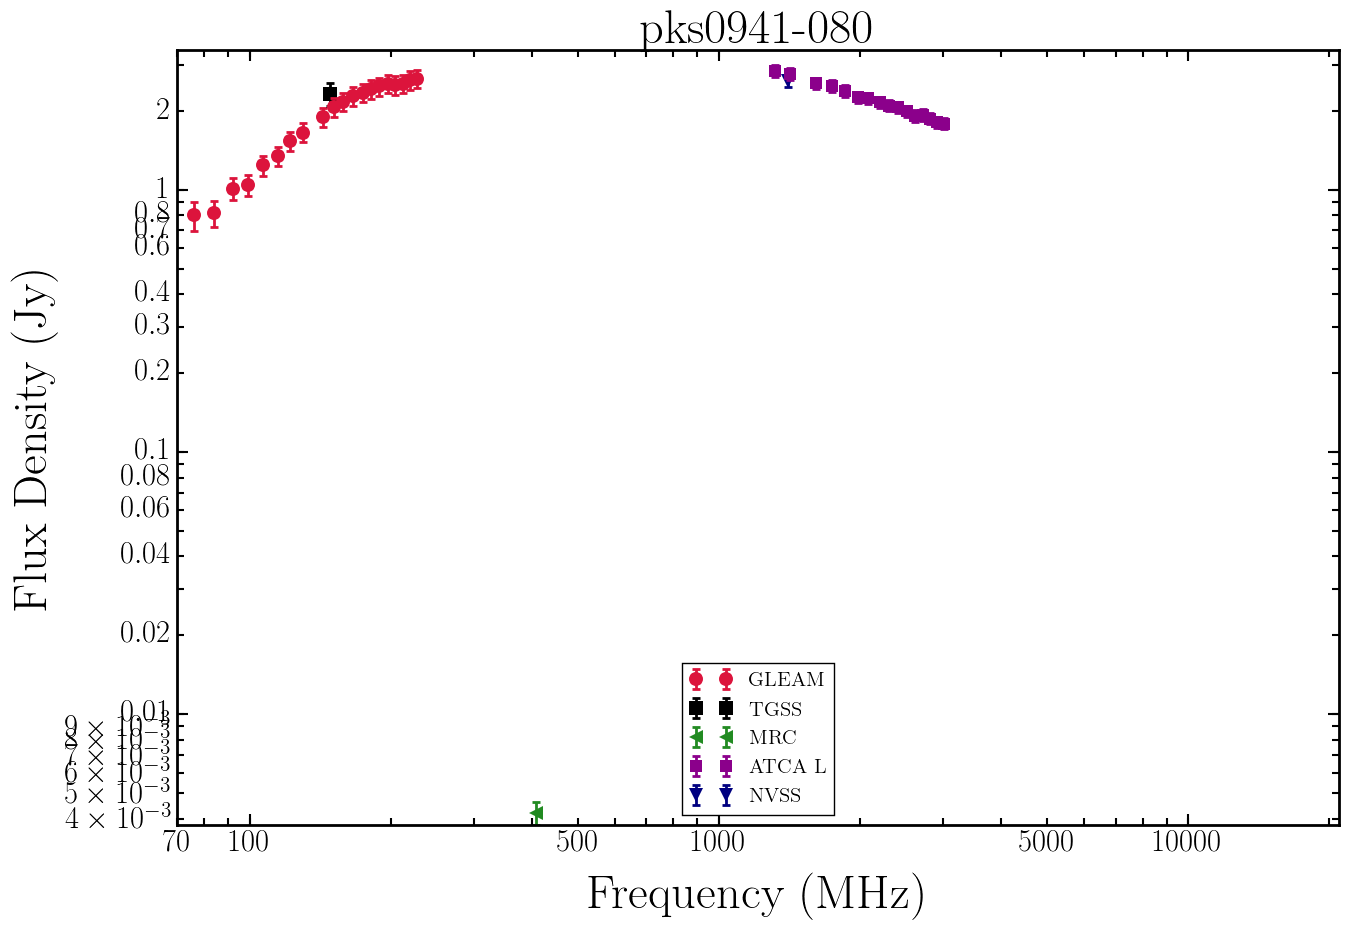

pks1200+045


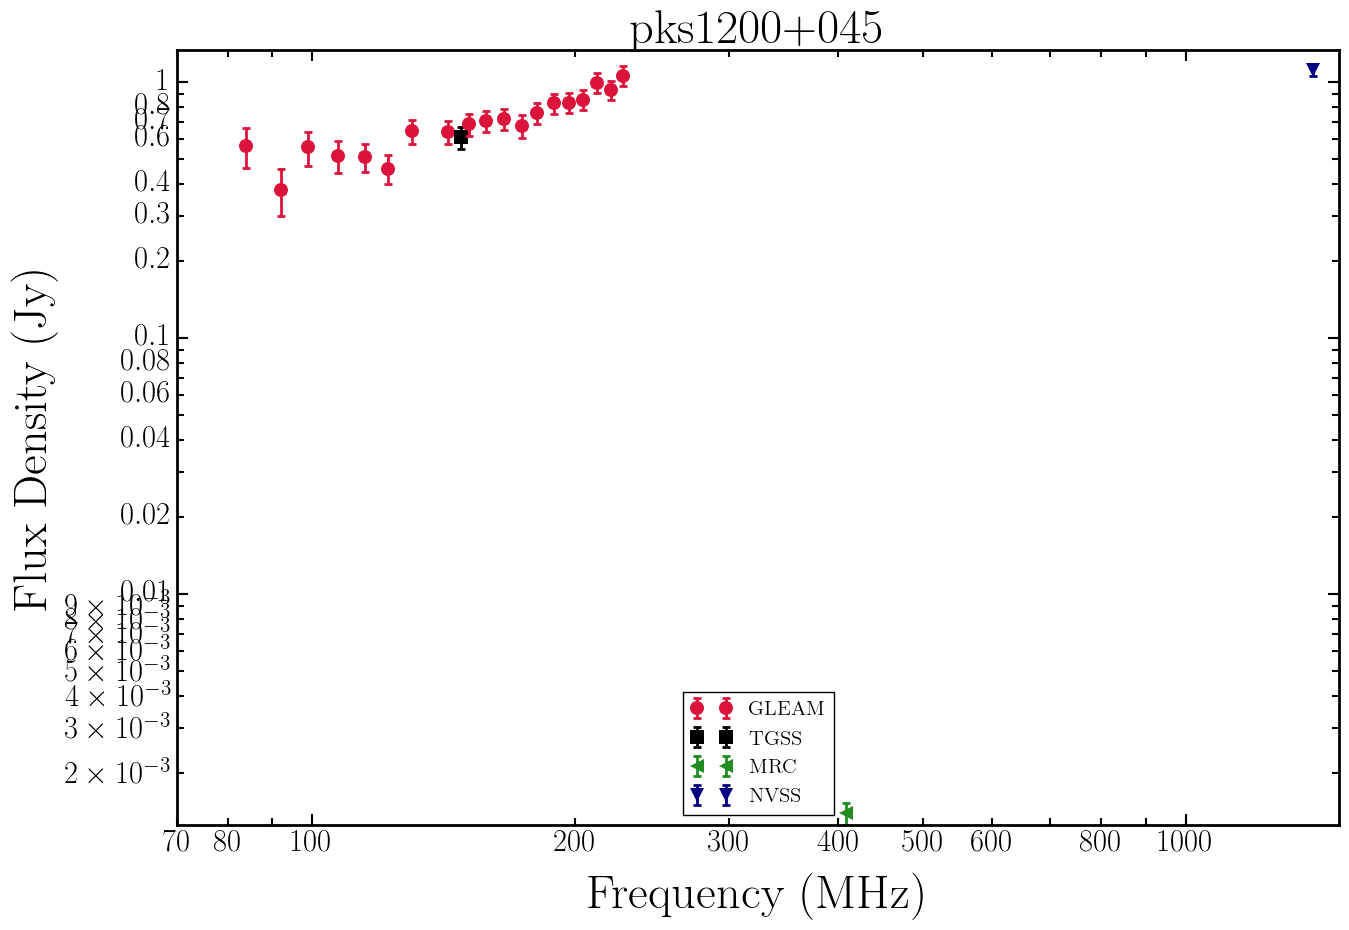

pks0910+151


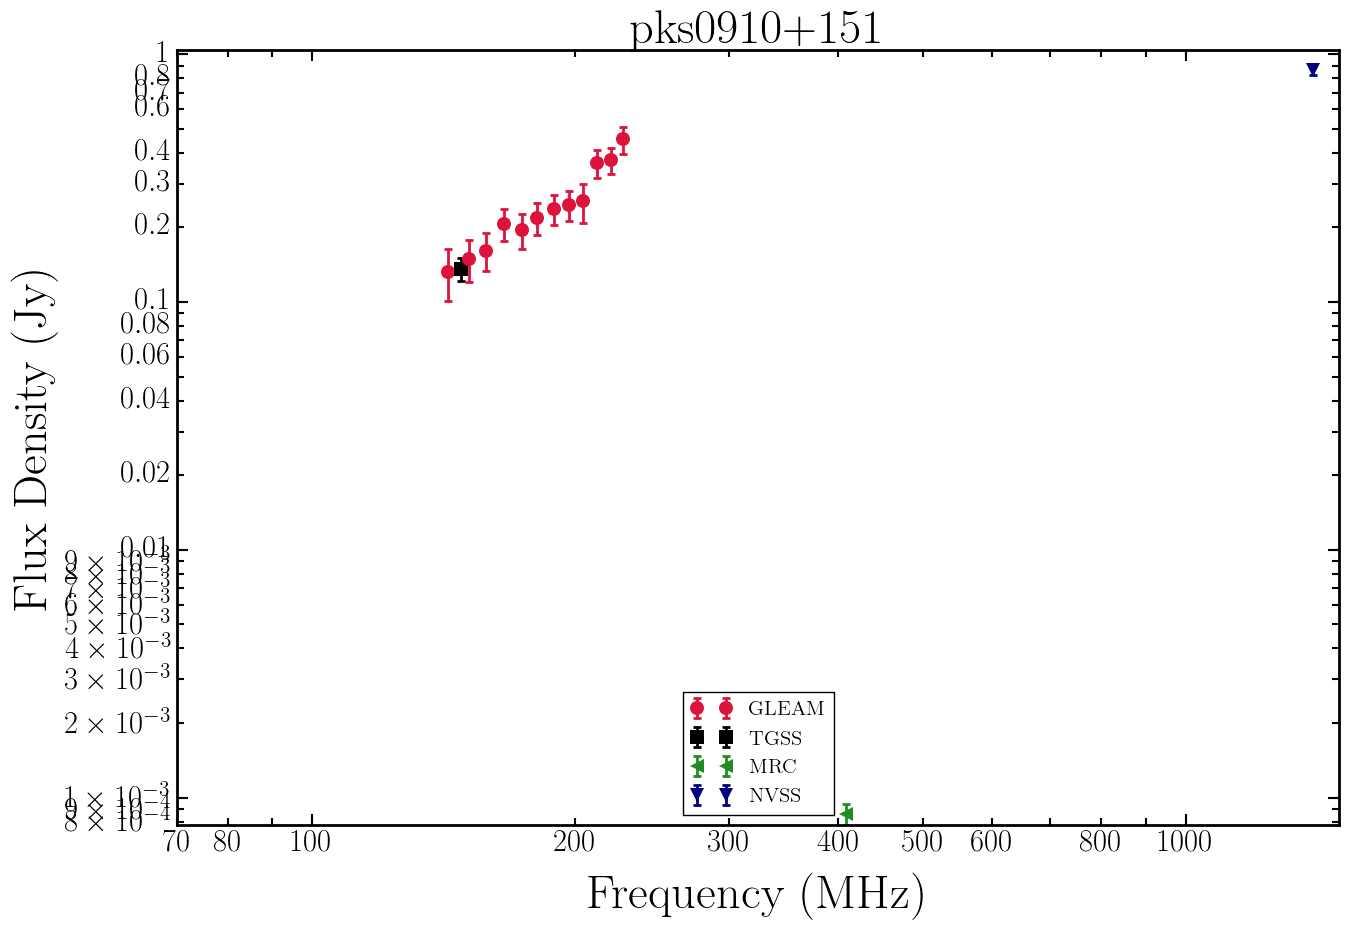

pks1740-649


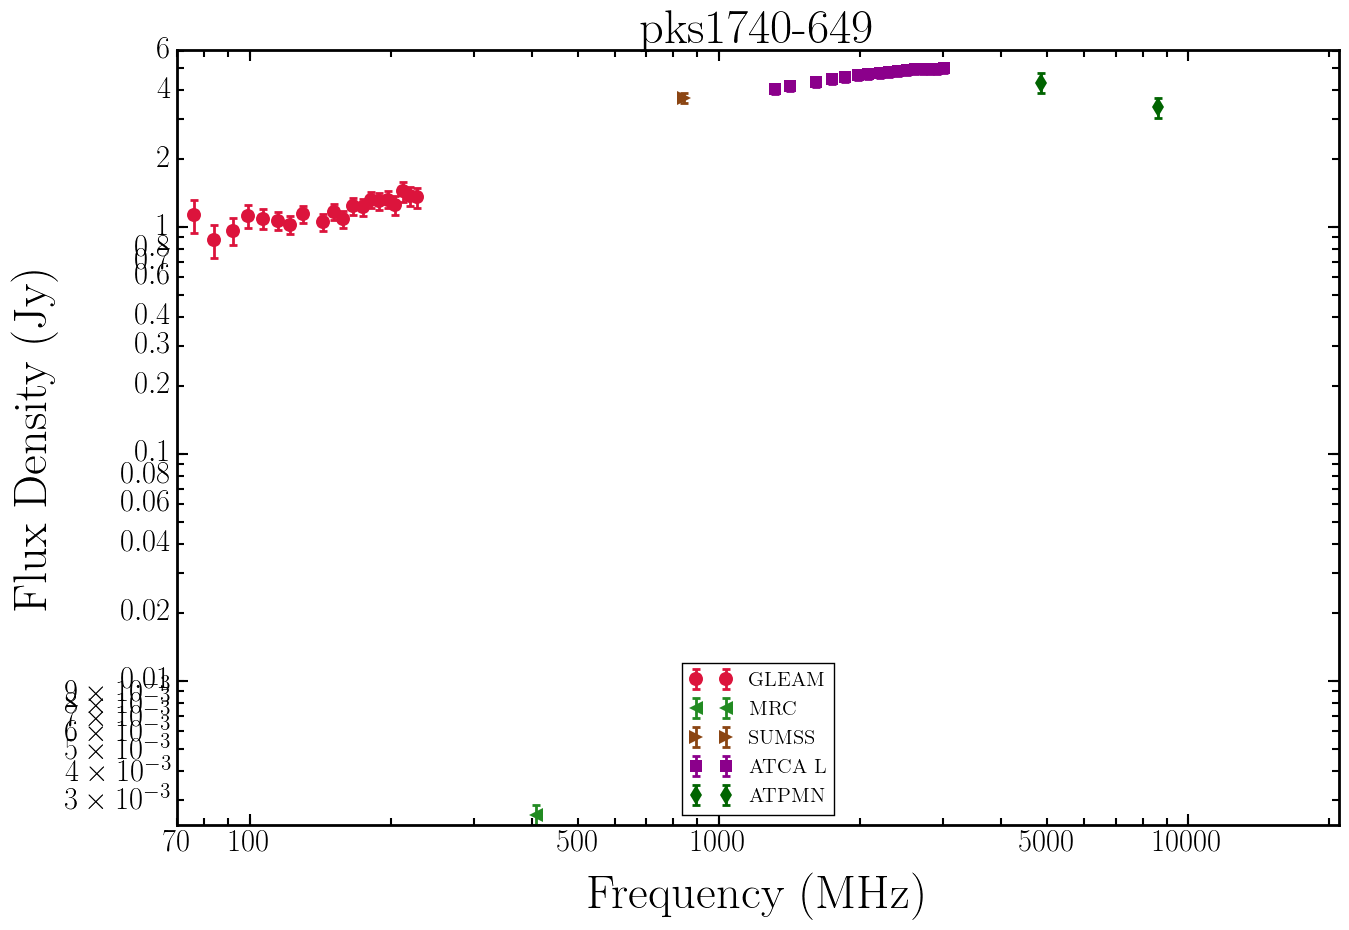

pks1953-42


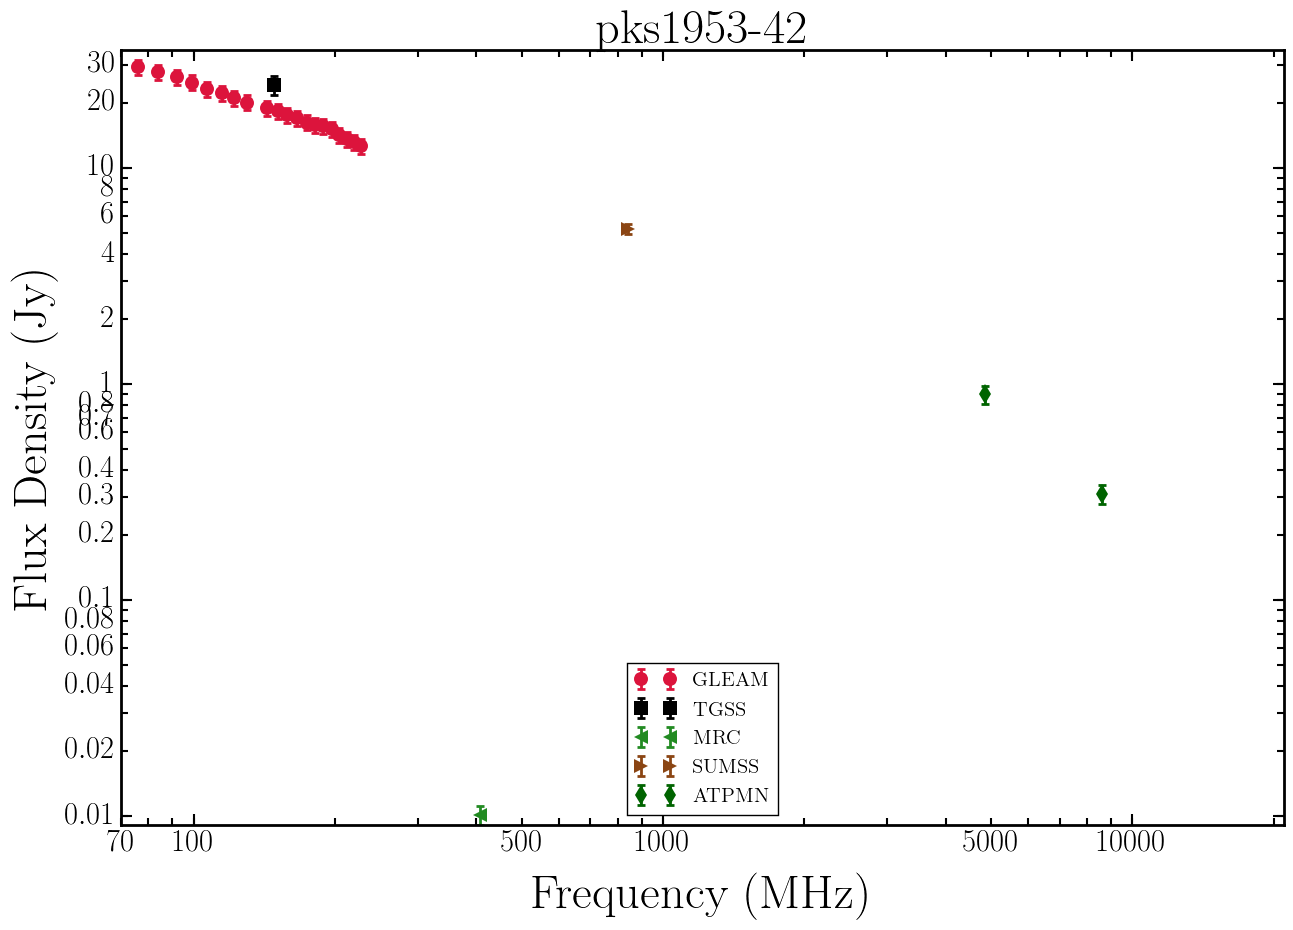

pks1601-222


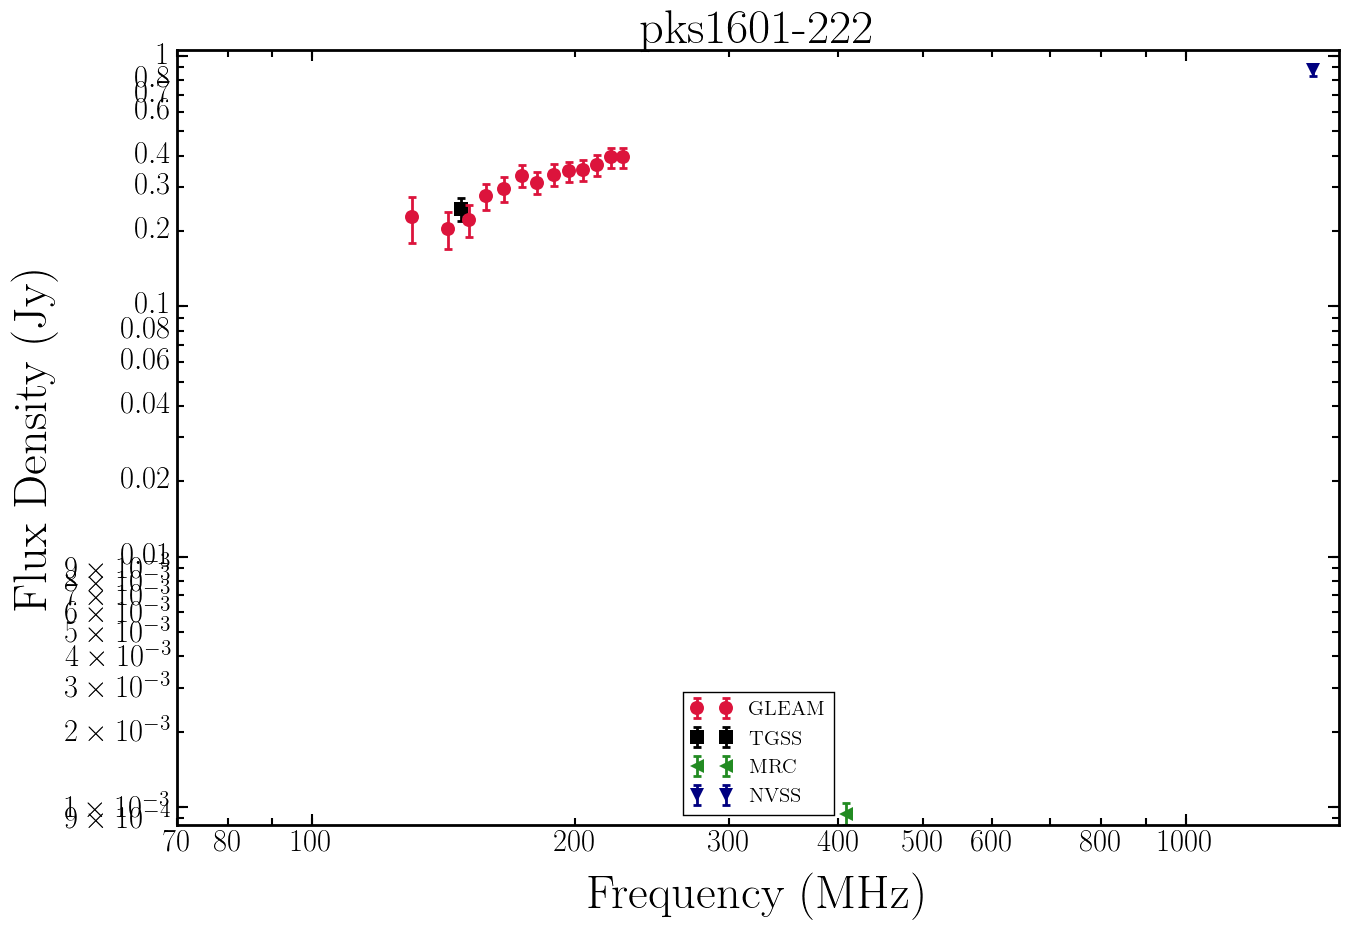

pks2127+04


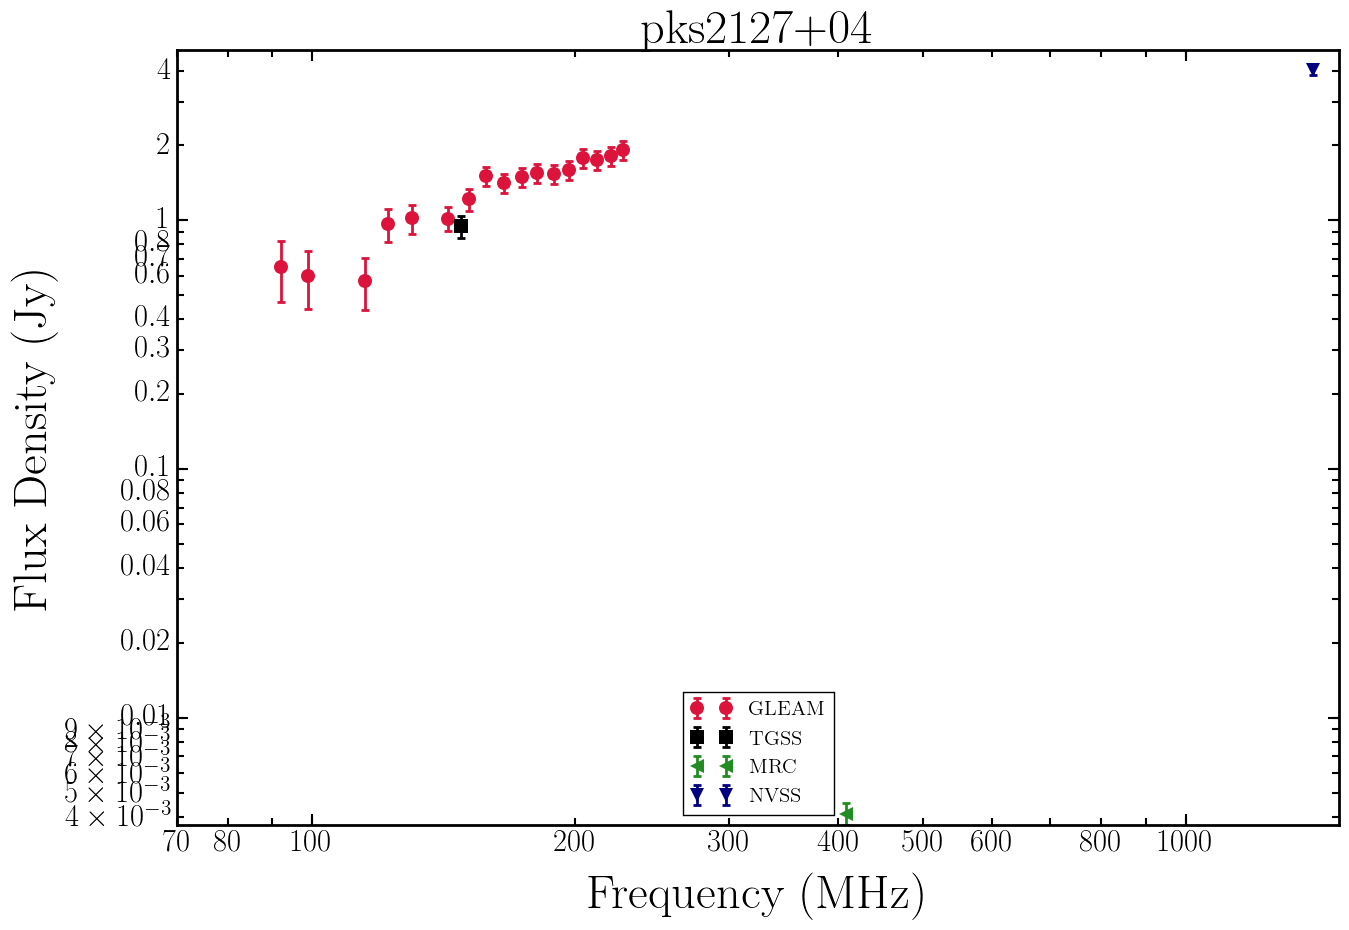

4c+02.43


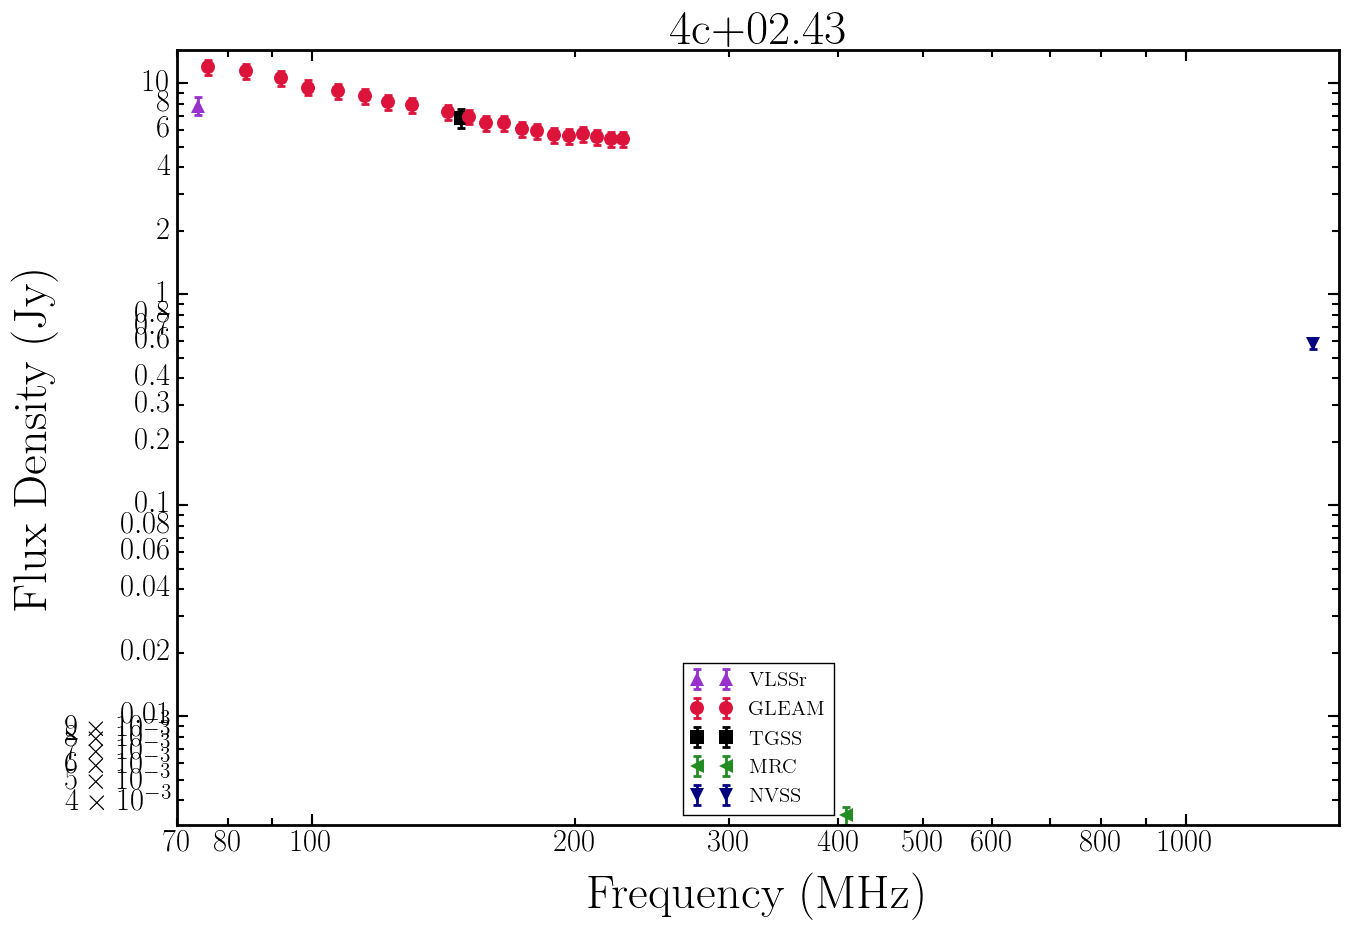

1323-611


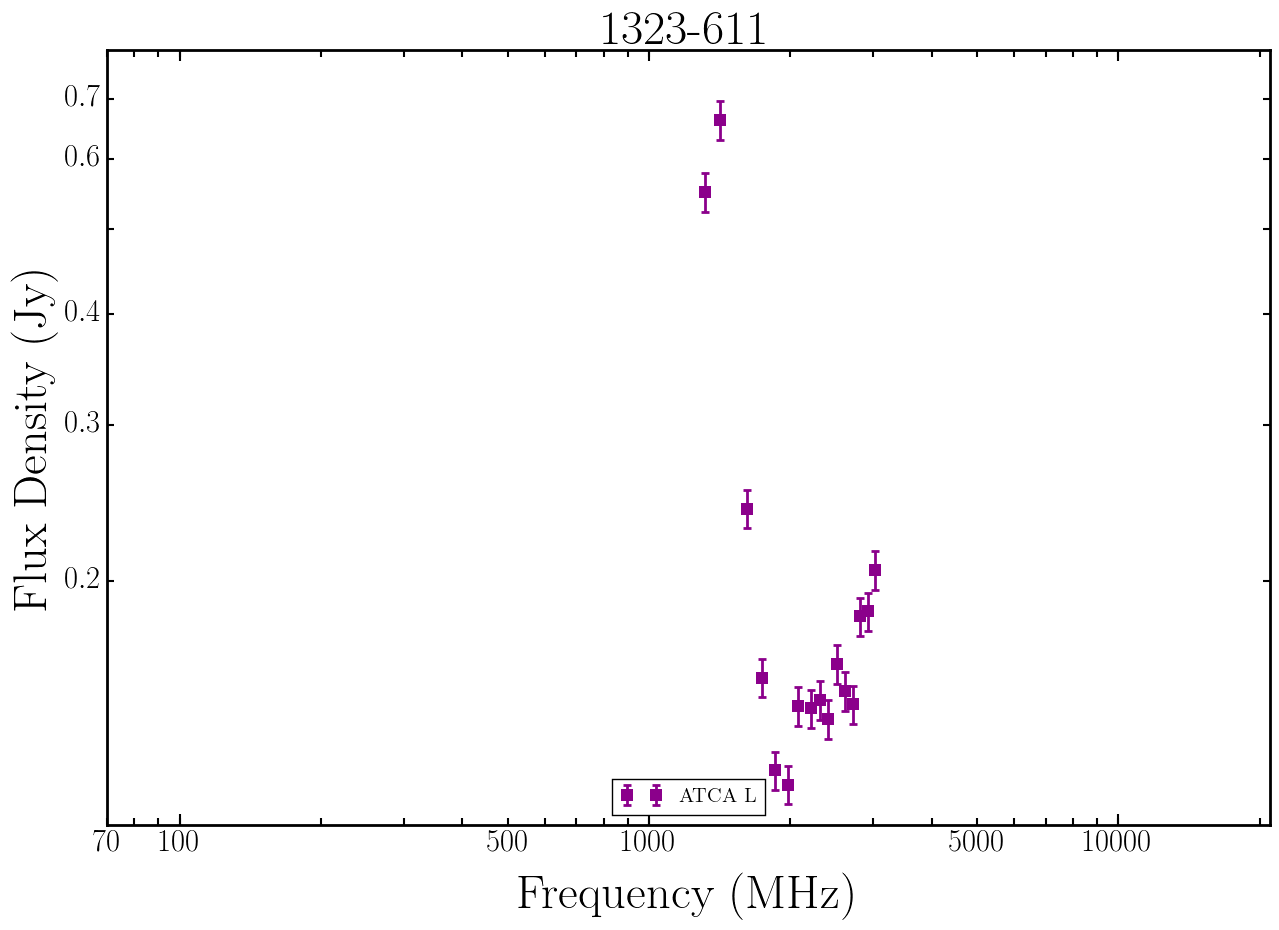

mwacsj0206.7-3025


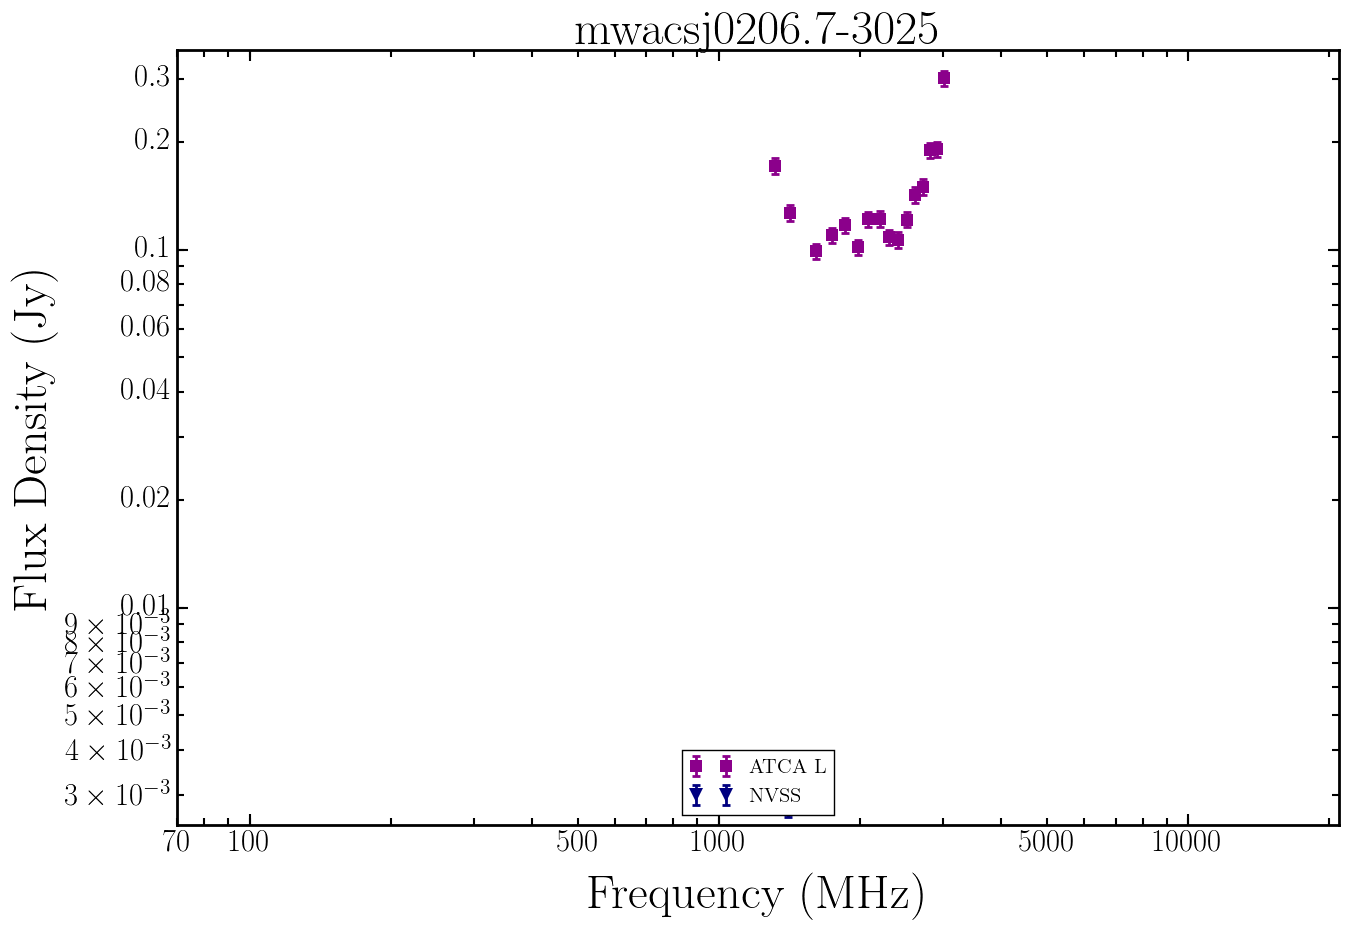

mwacsj0401.3-2921


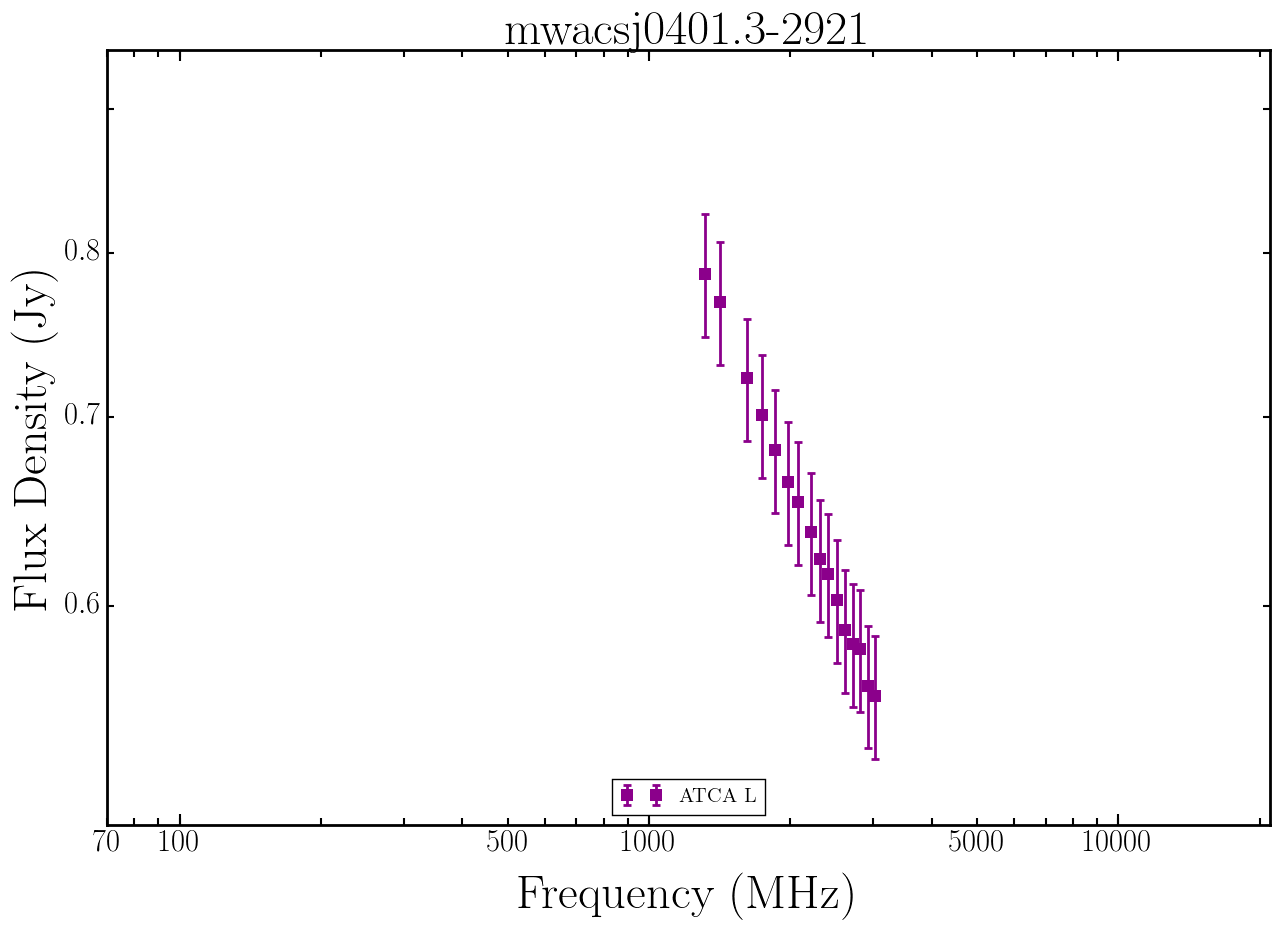

pks2333-528


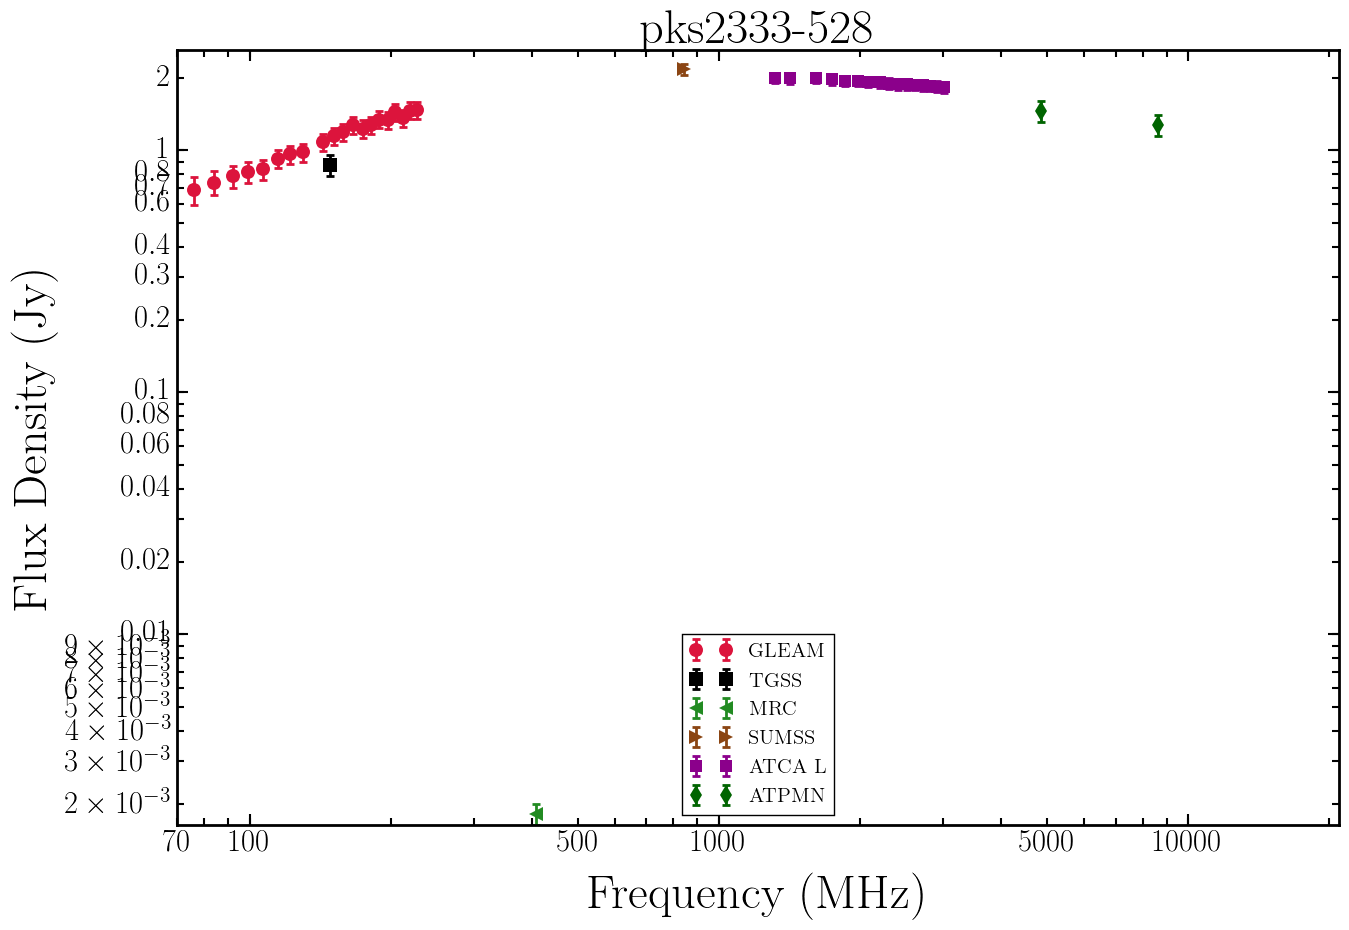

4c-06.76


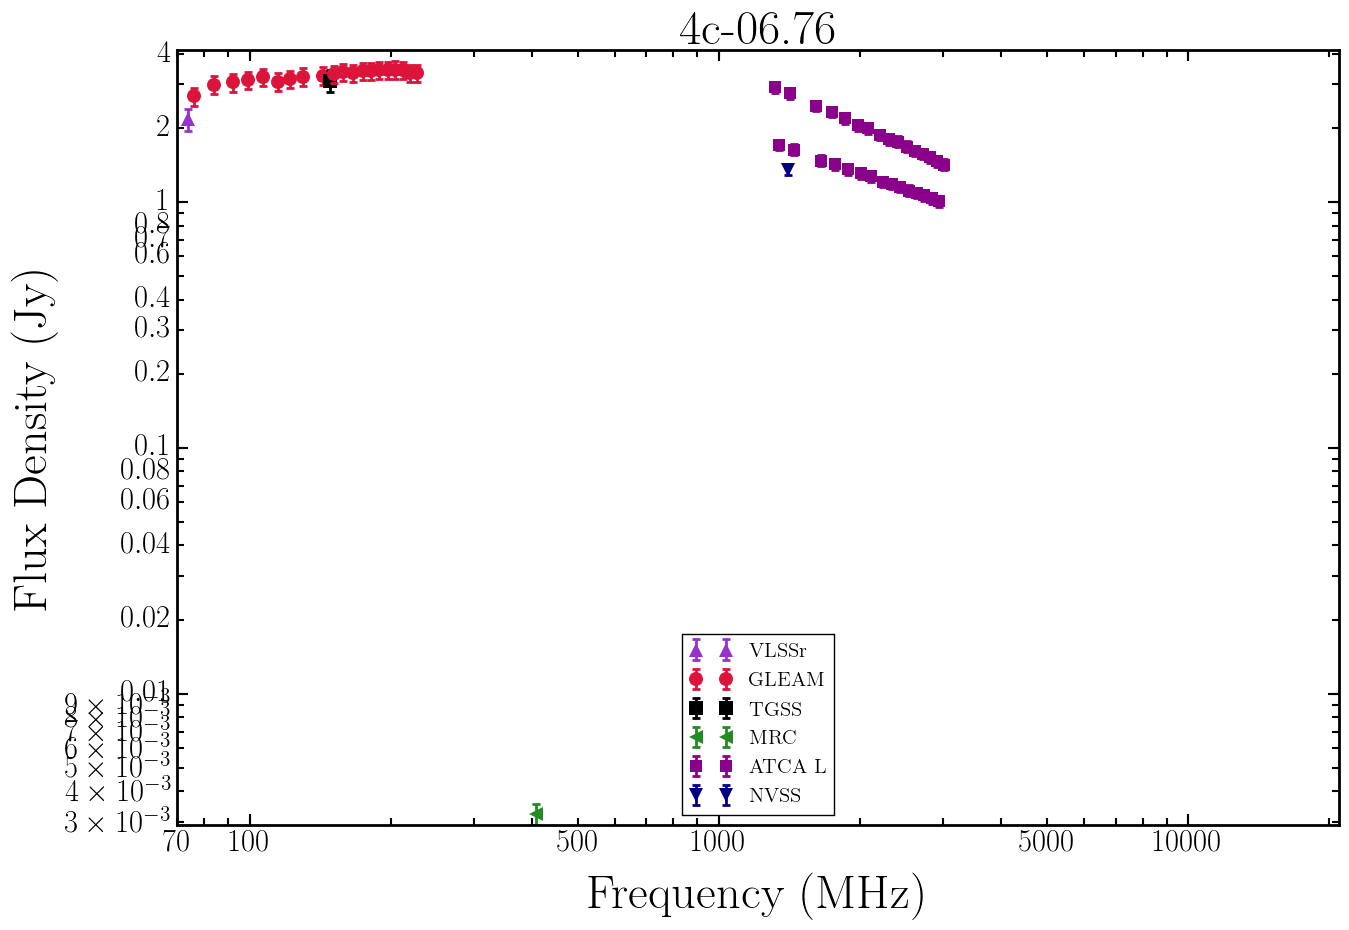

pks0405-395


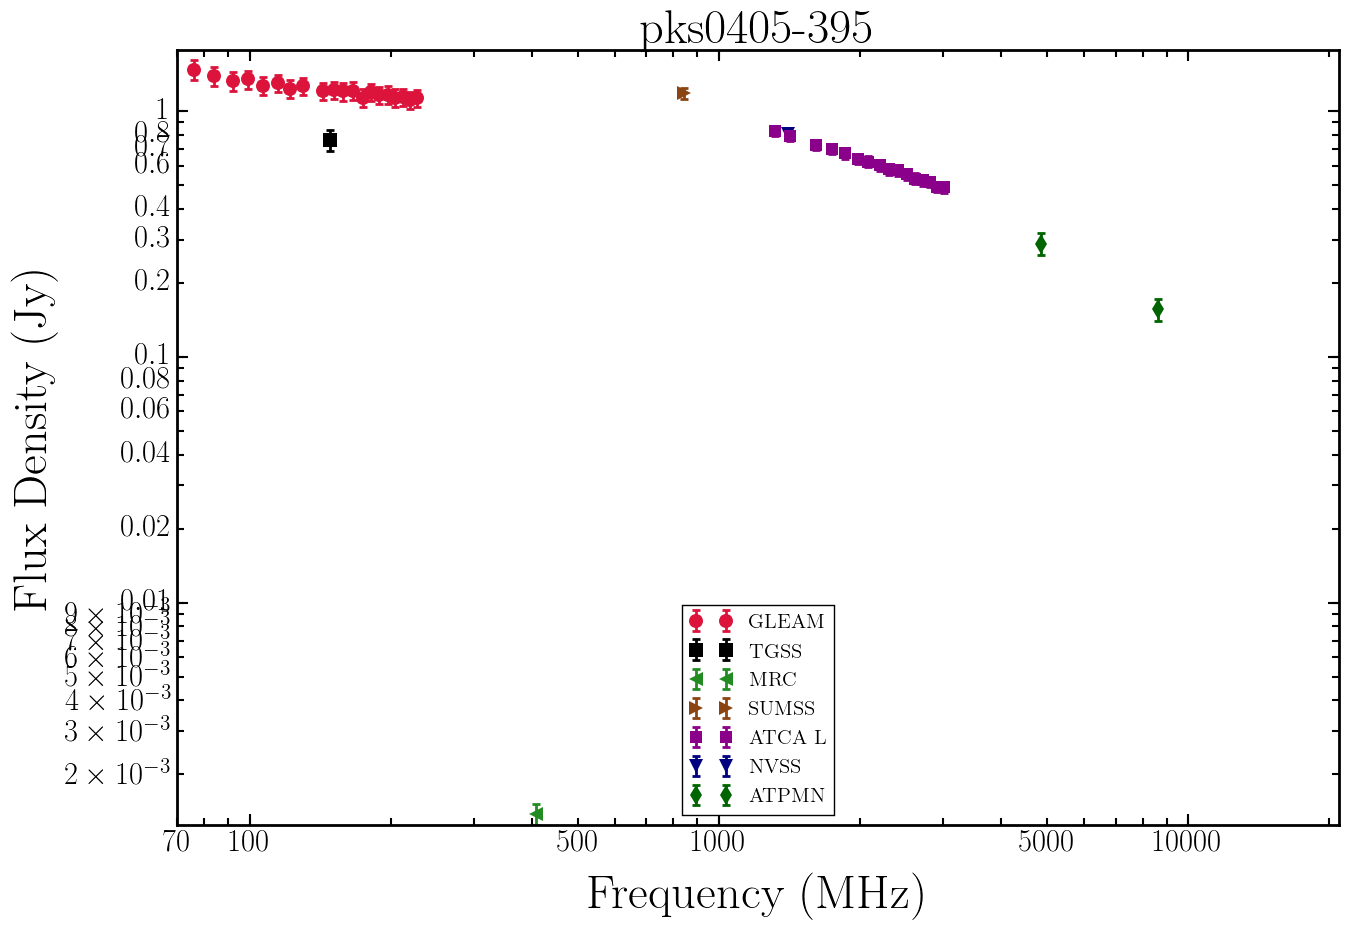

pks0237-233


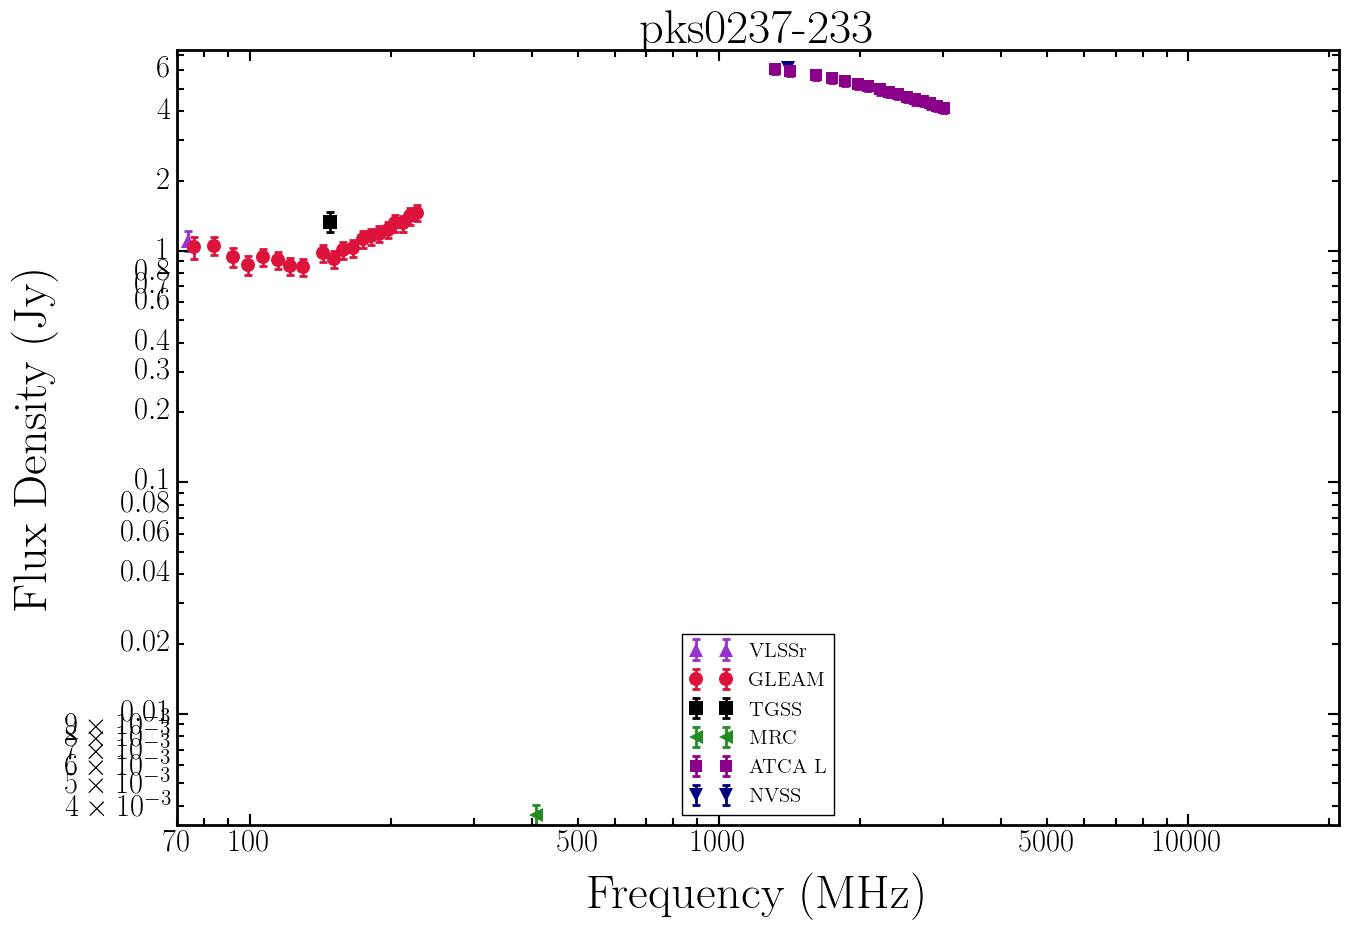

4c+05.14


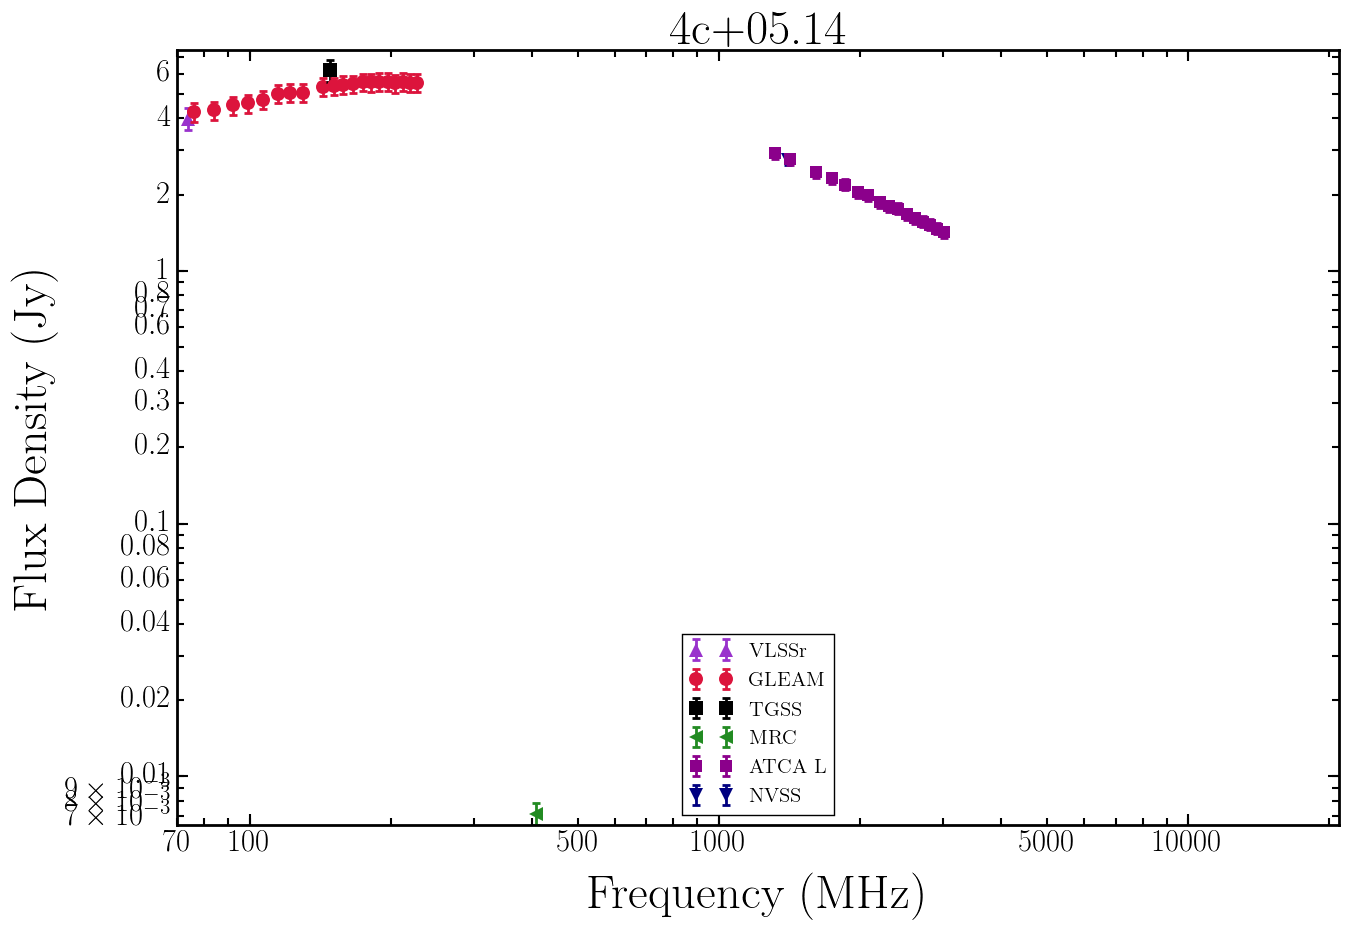

0834-196


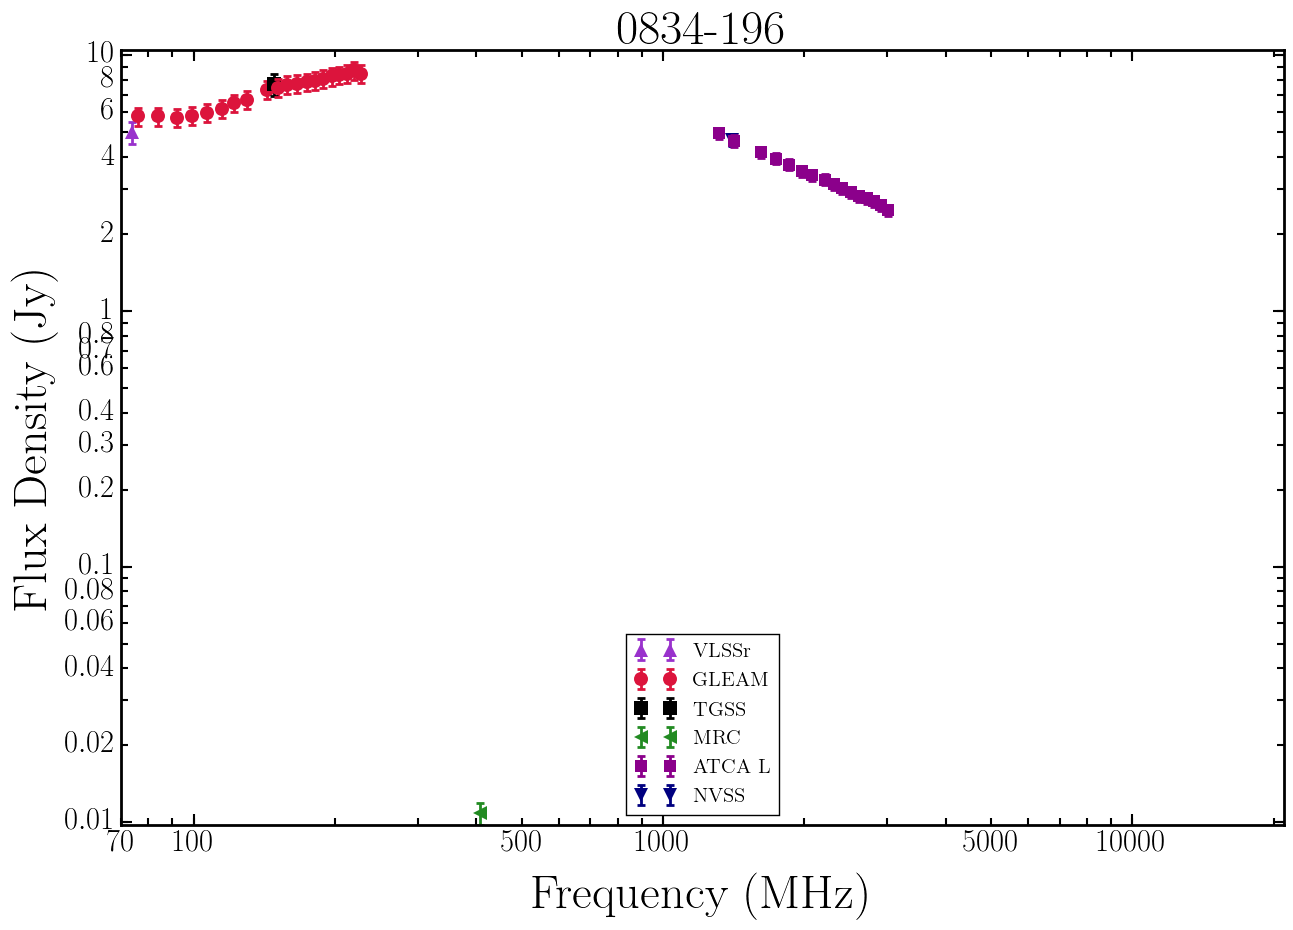

4c-00.45


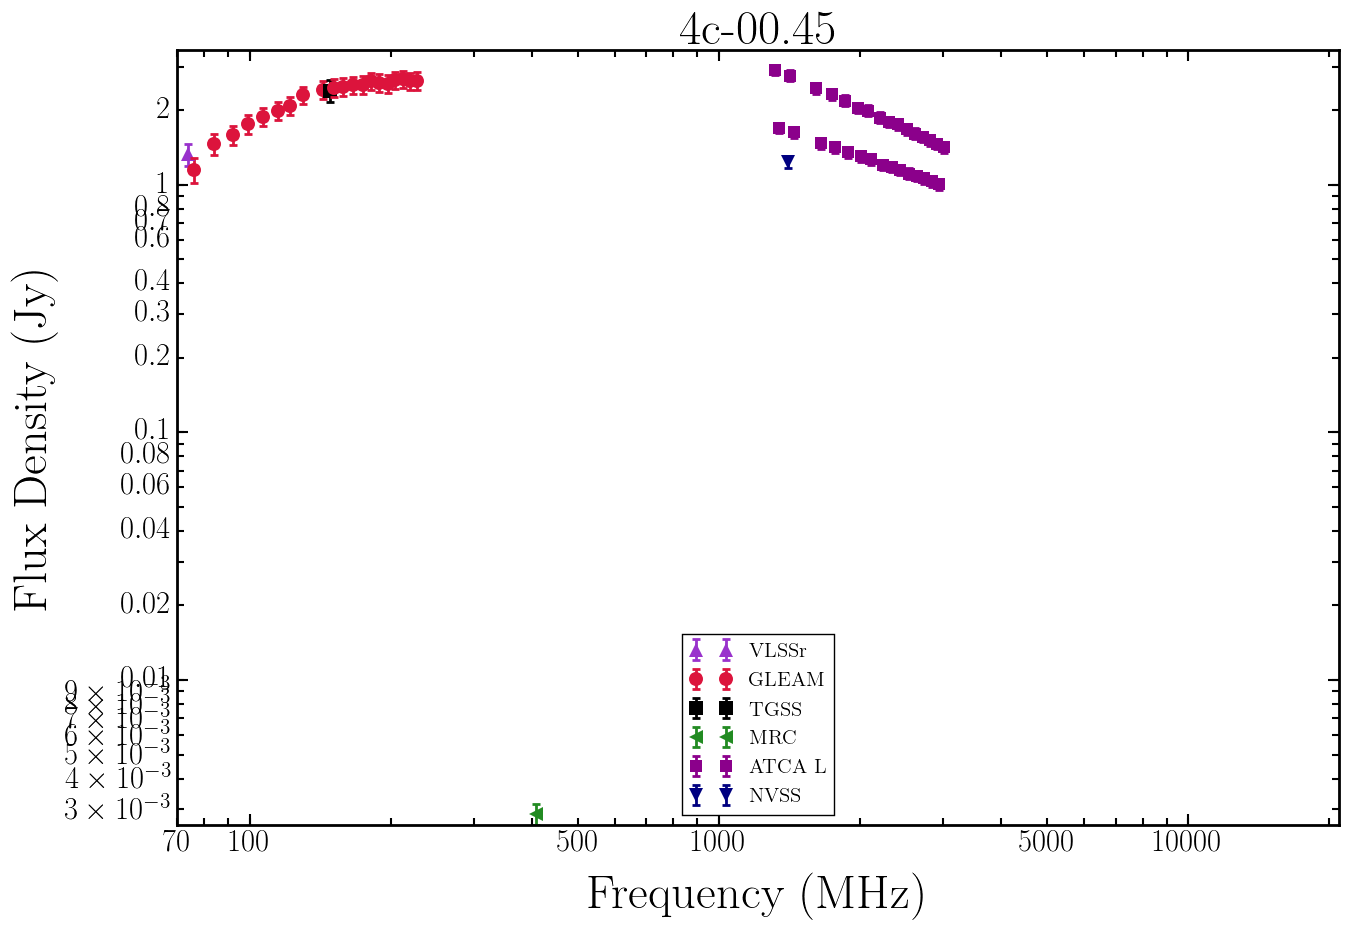

1549-790


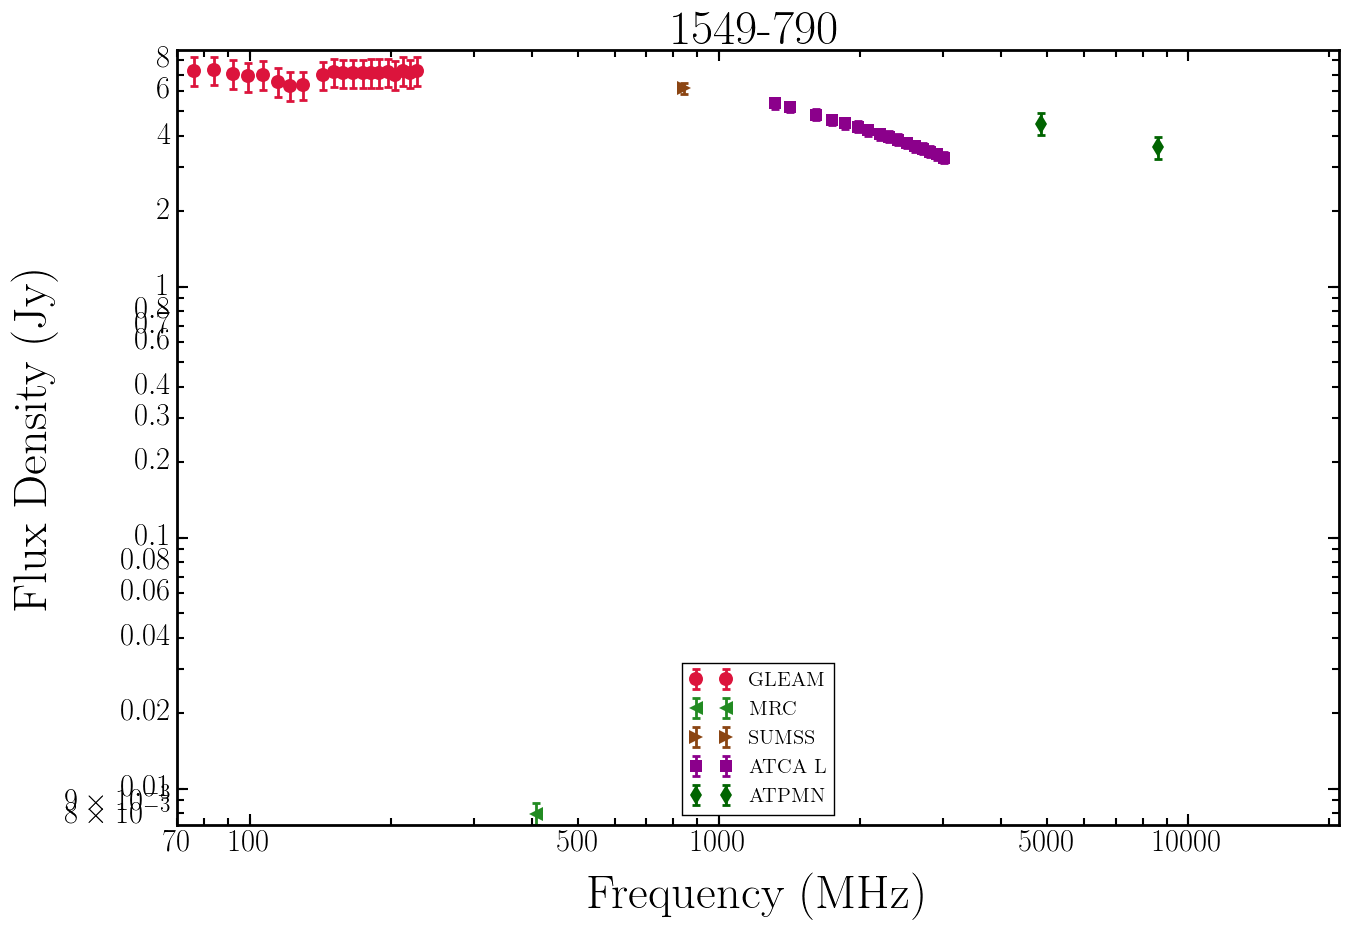

pks1444-339


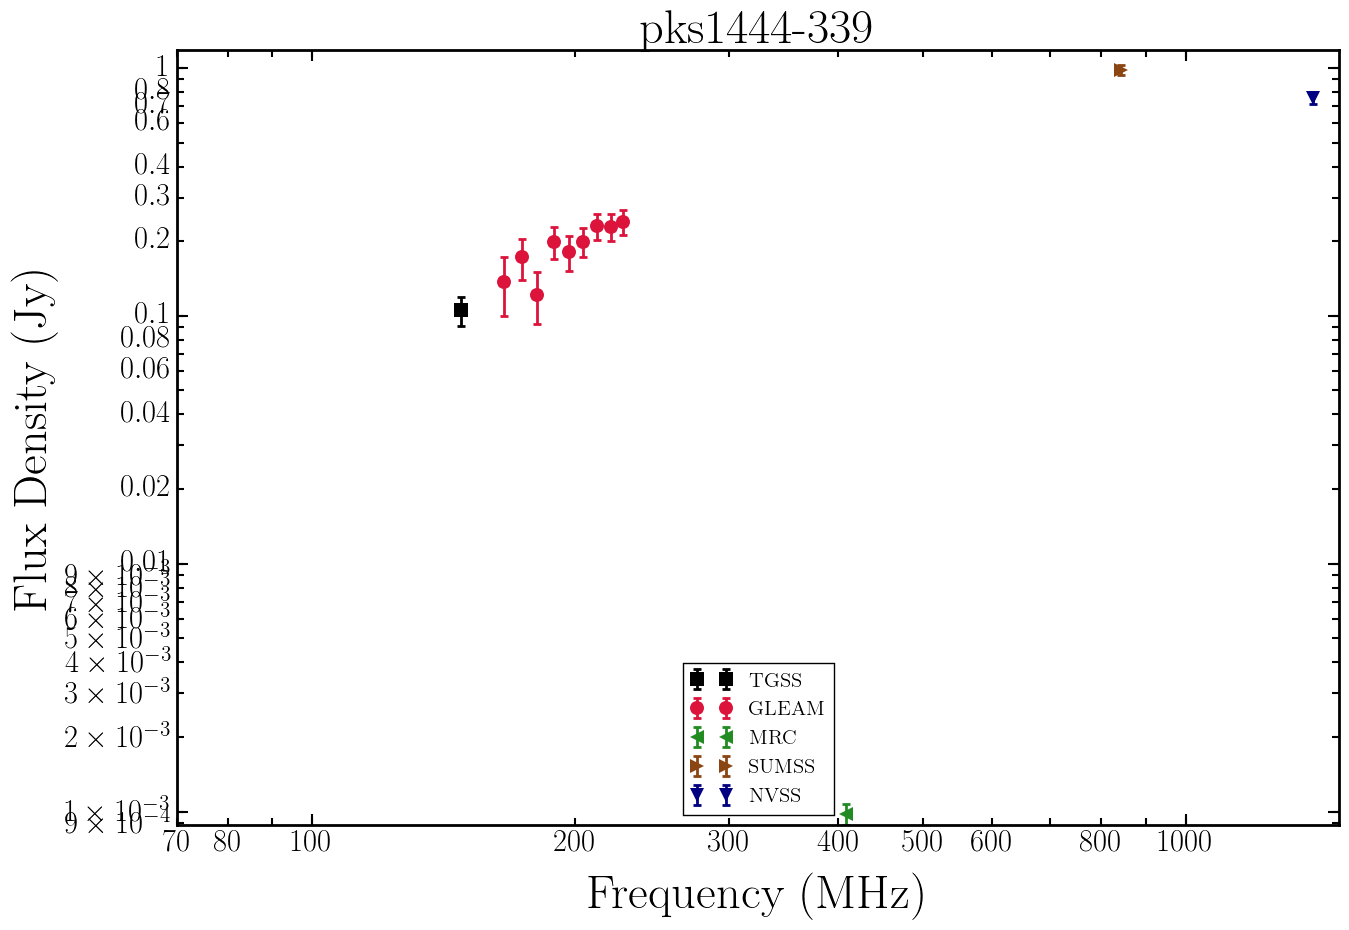

pks1543+005


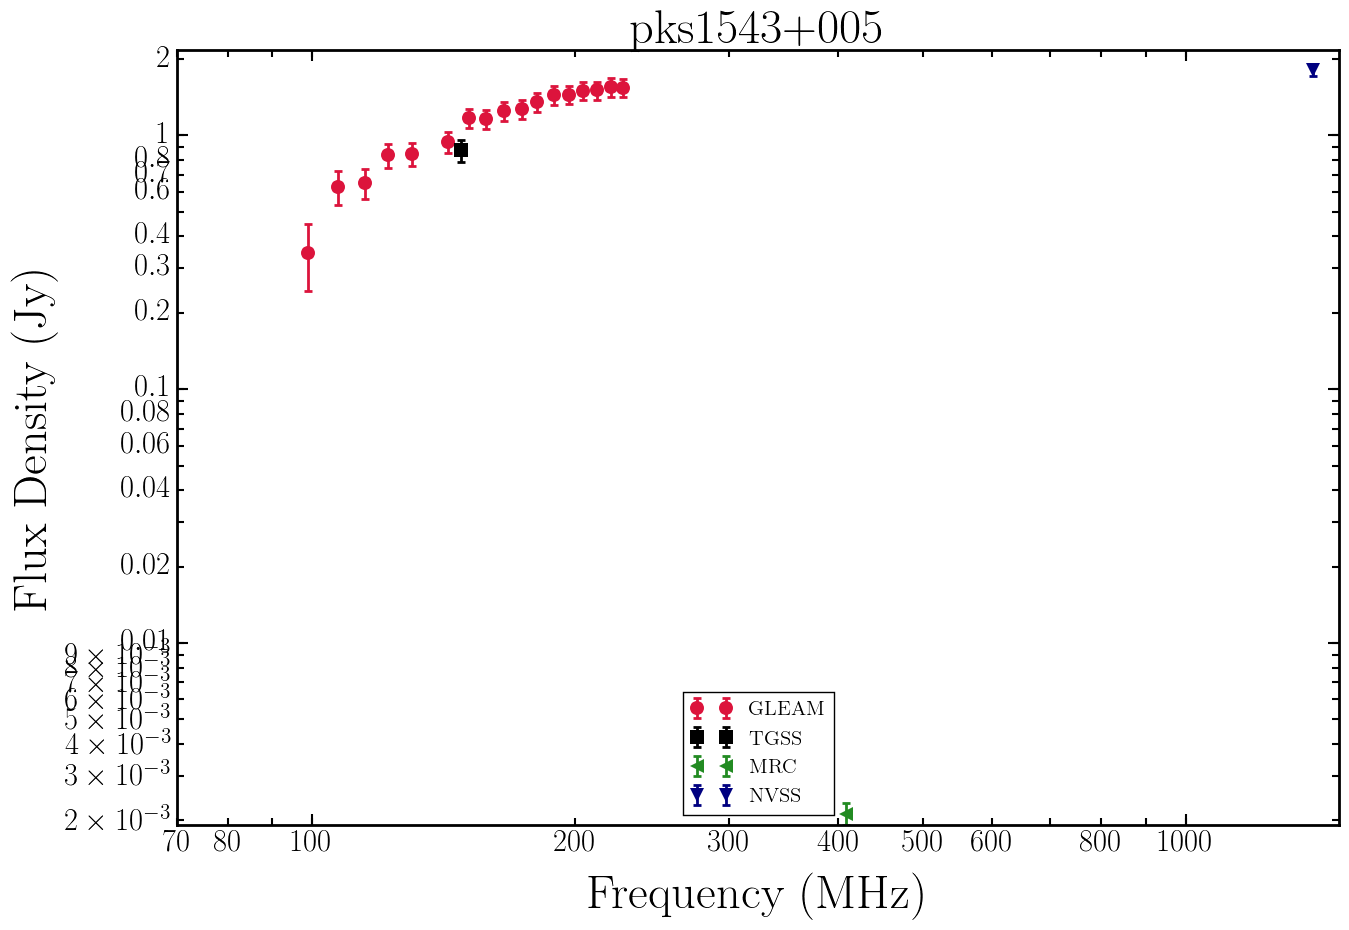

4c+01.69


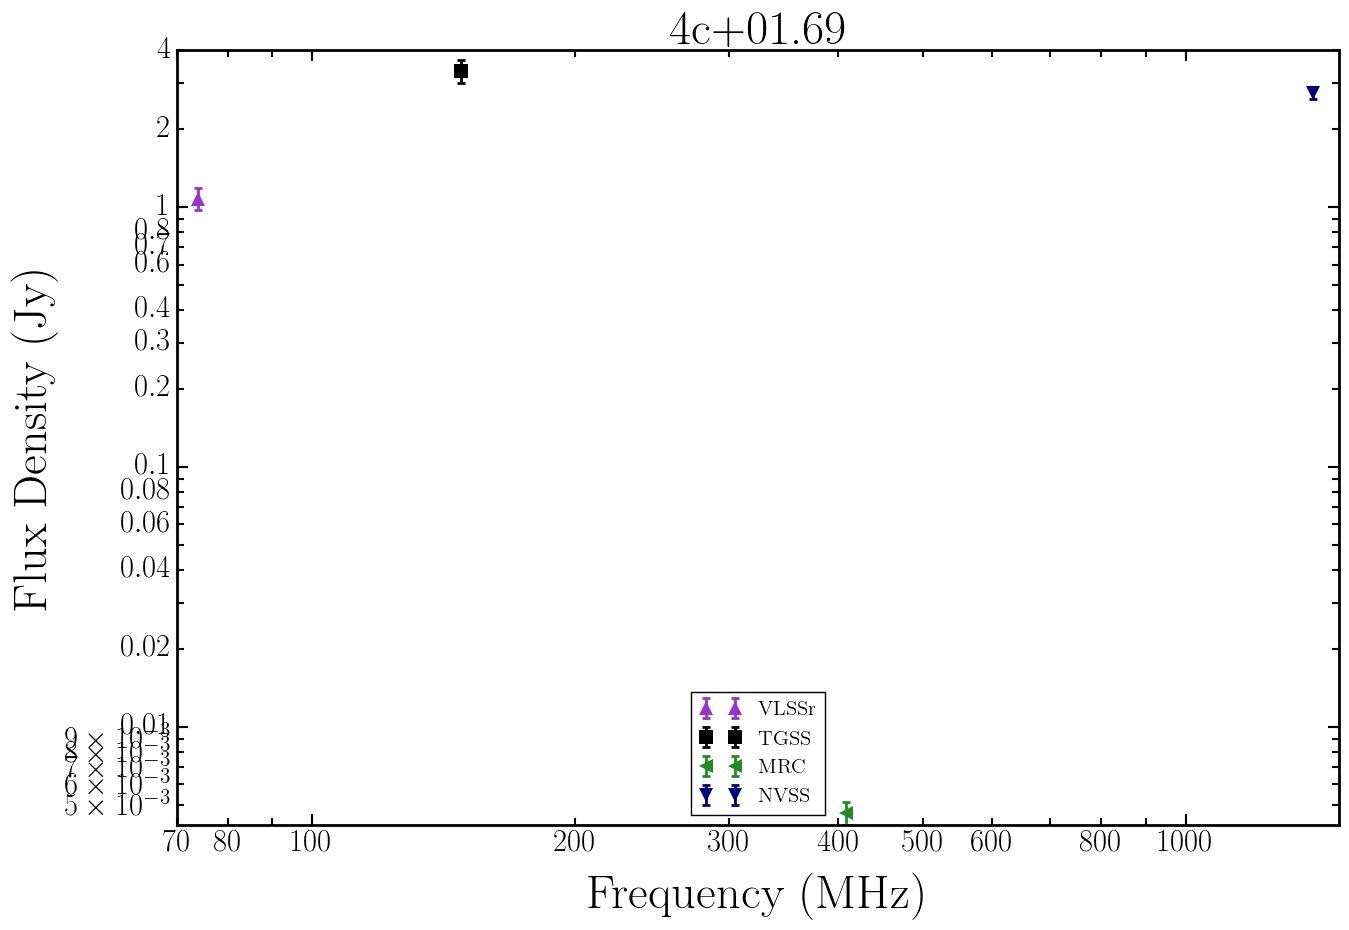

4c+05.78


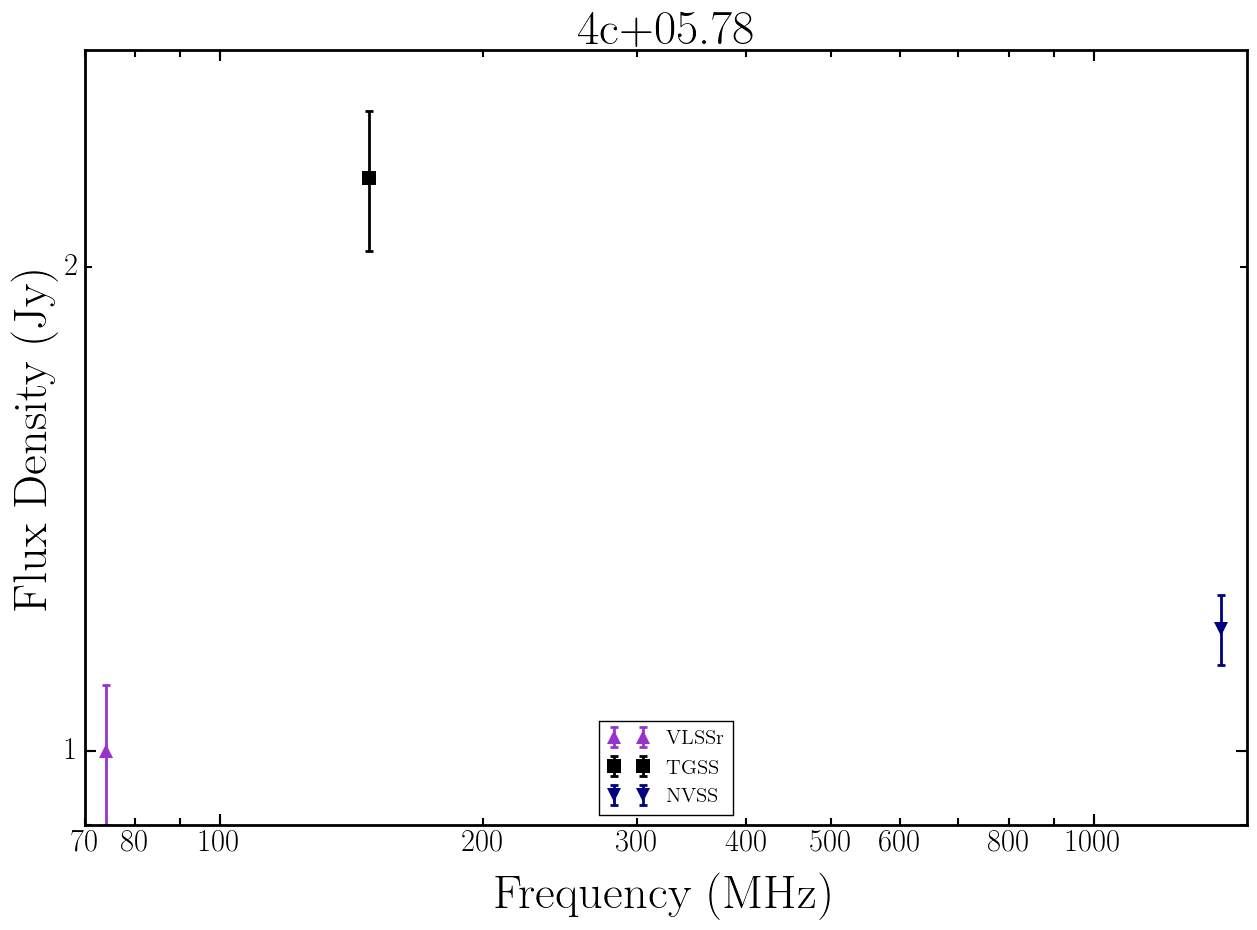

pks0252-71


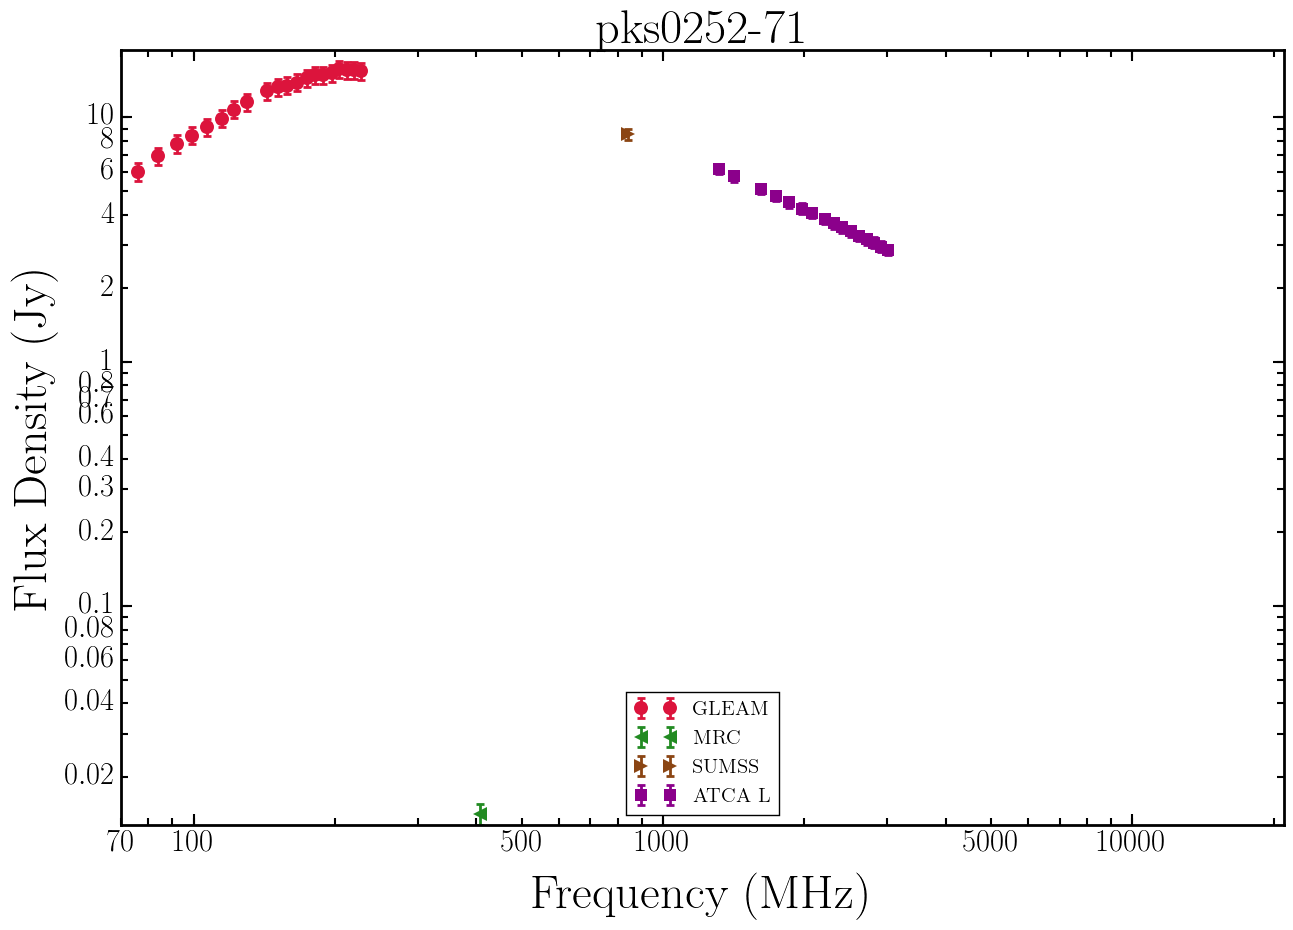

4c+00.02


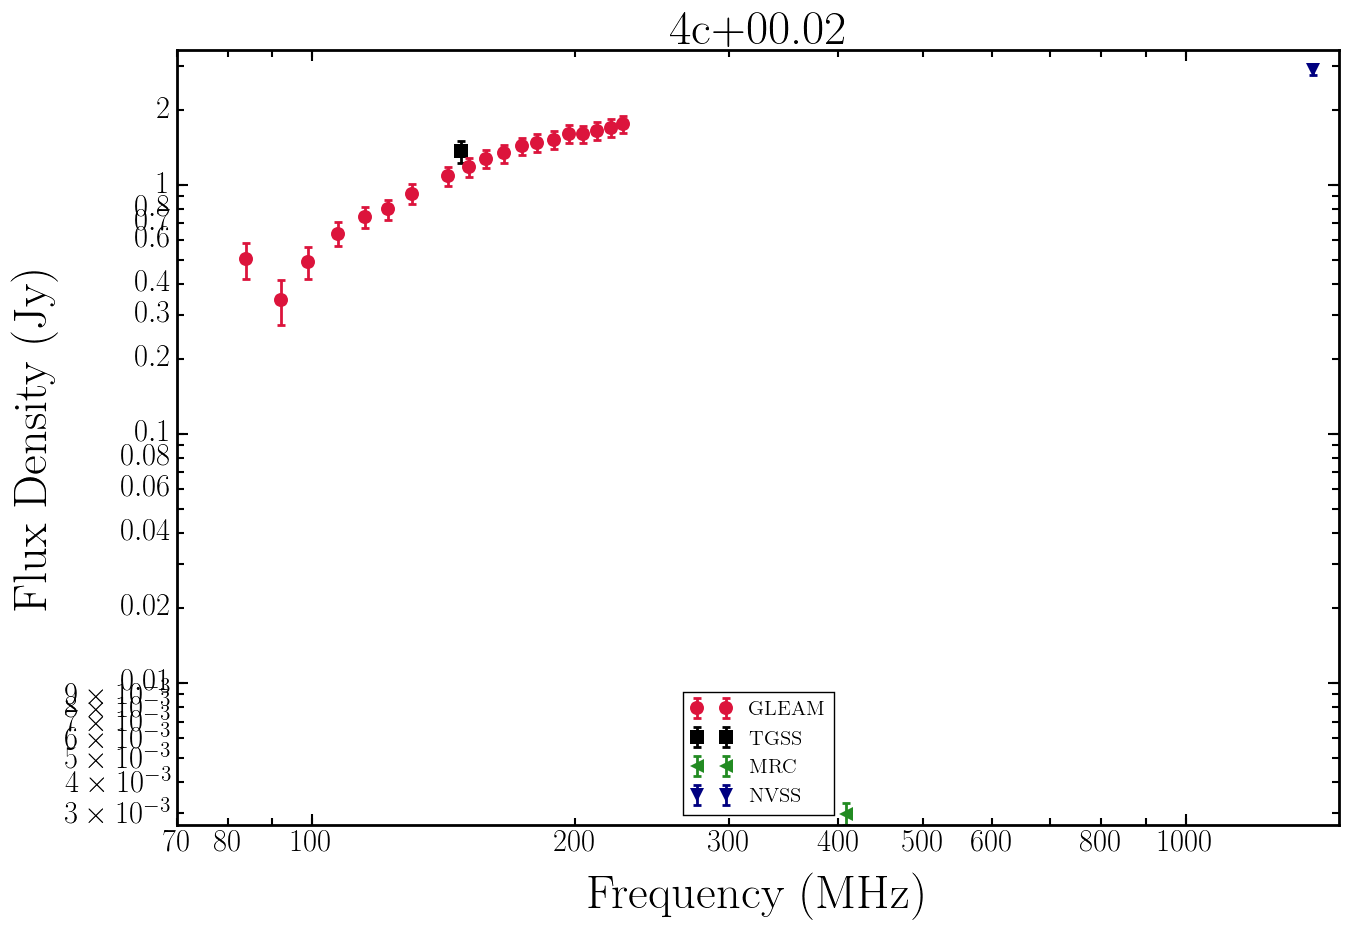

0859-140


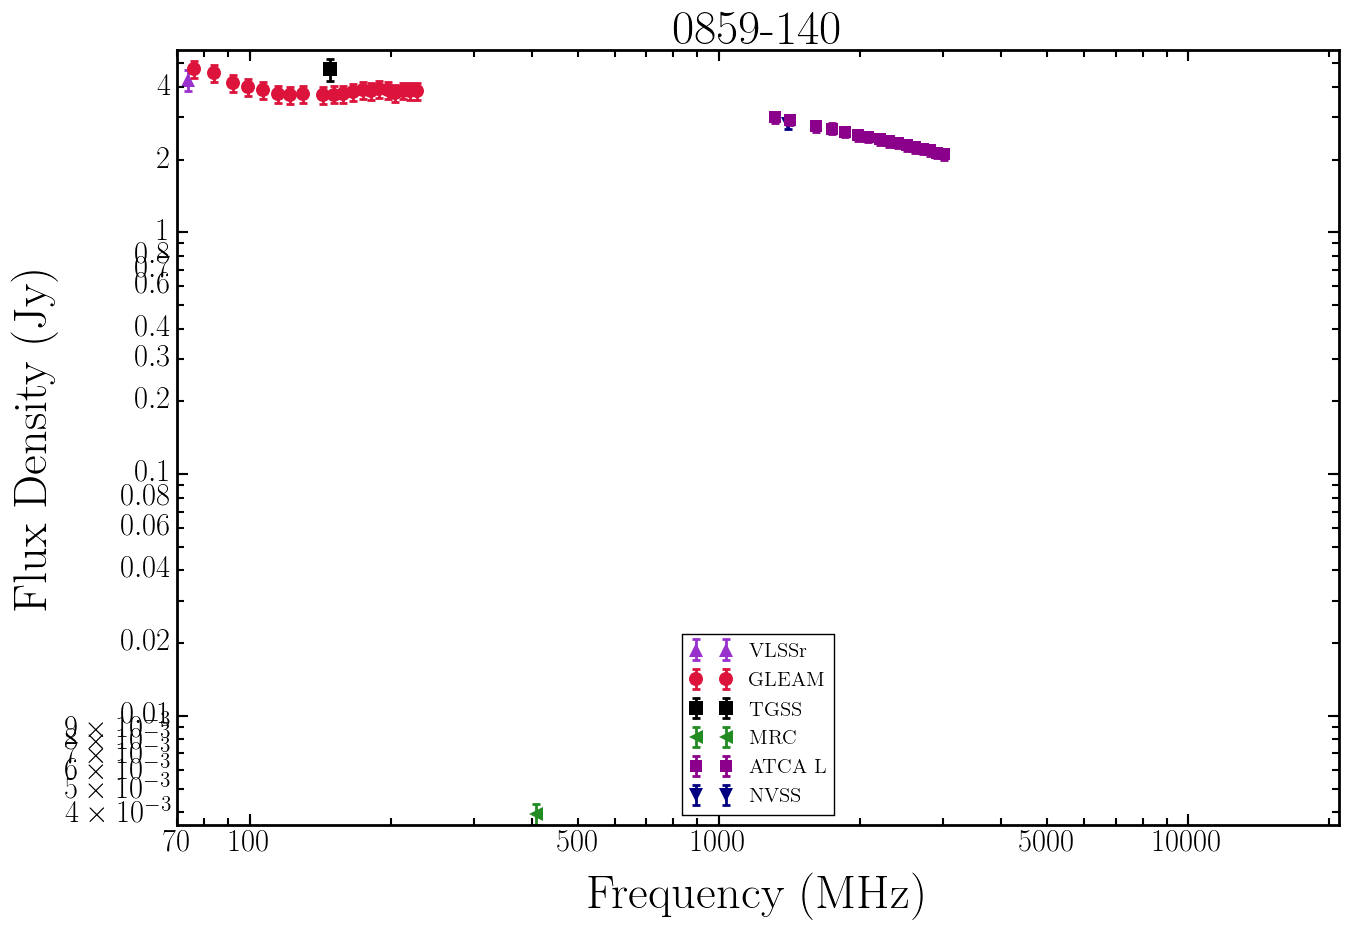

pmnj1726-6427


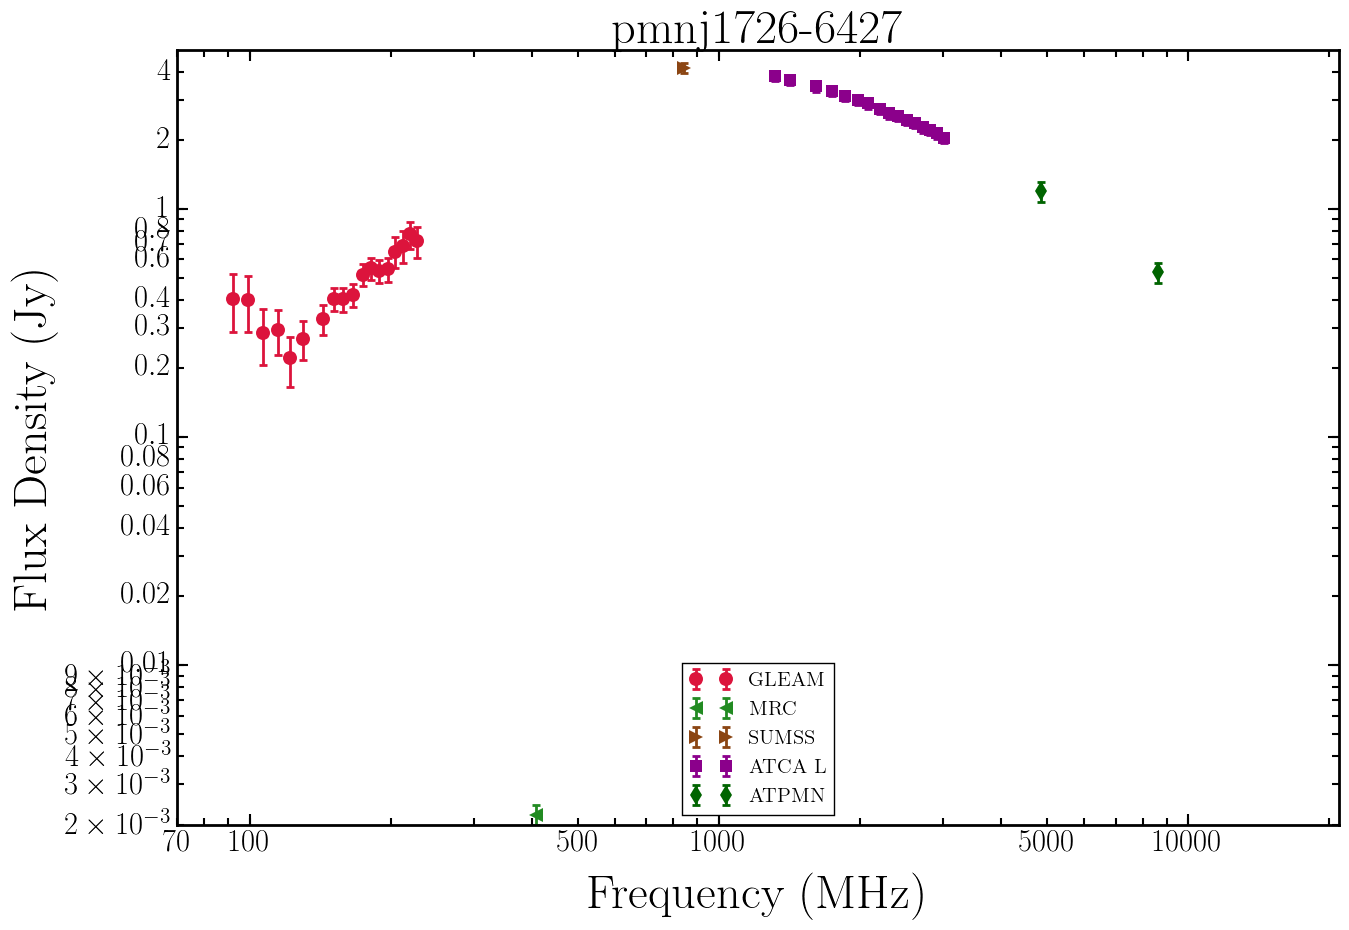

0741-063


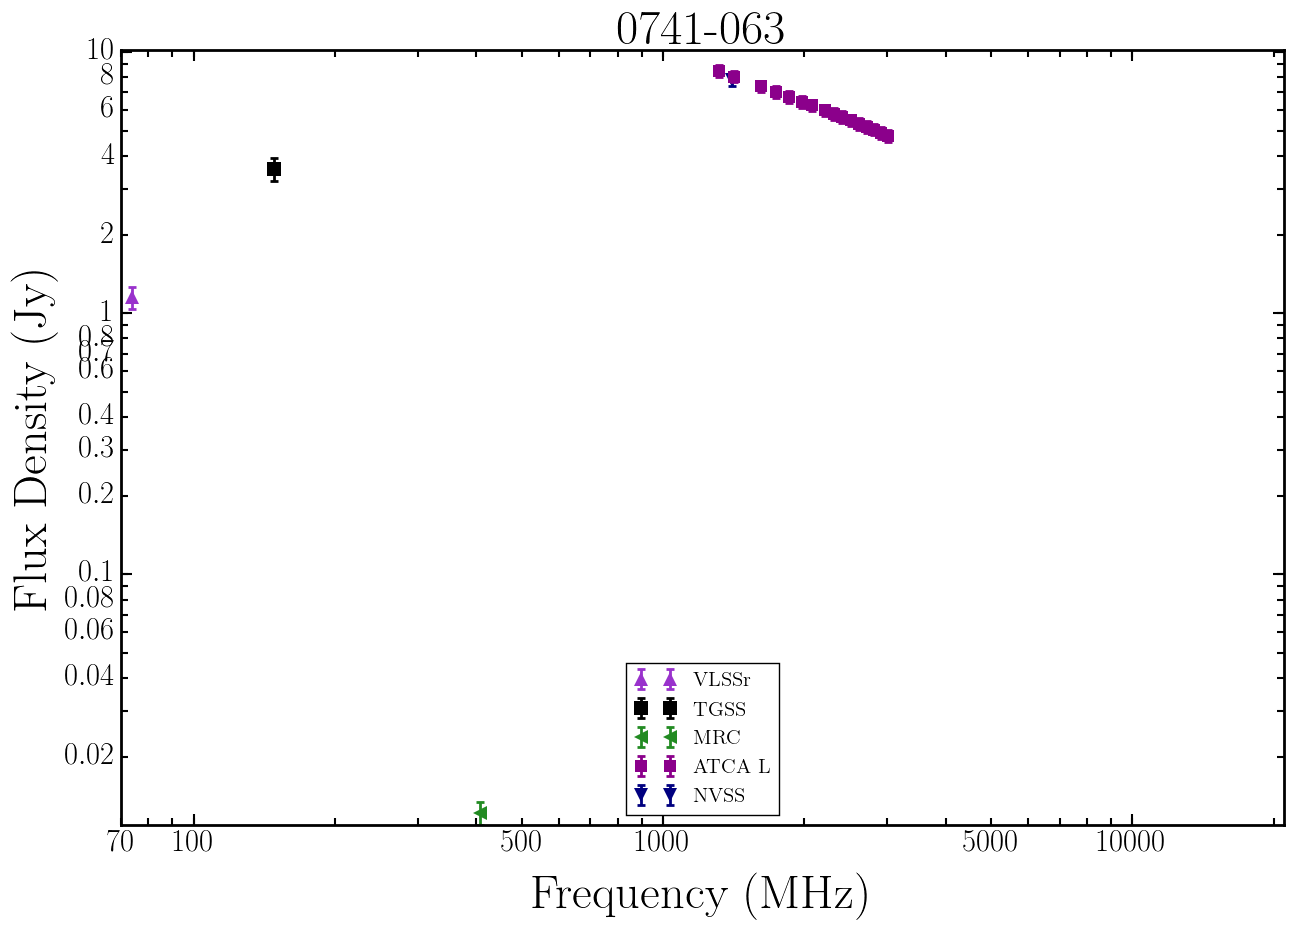

mwacsj2352.4-3316


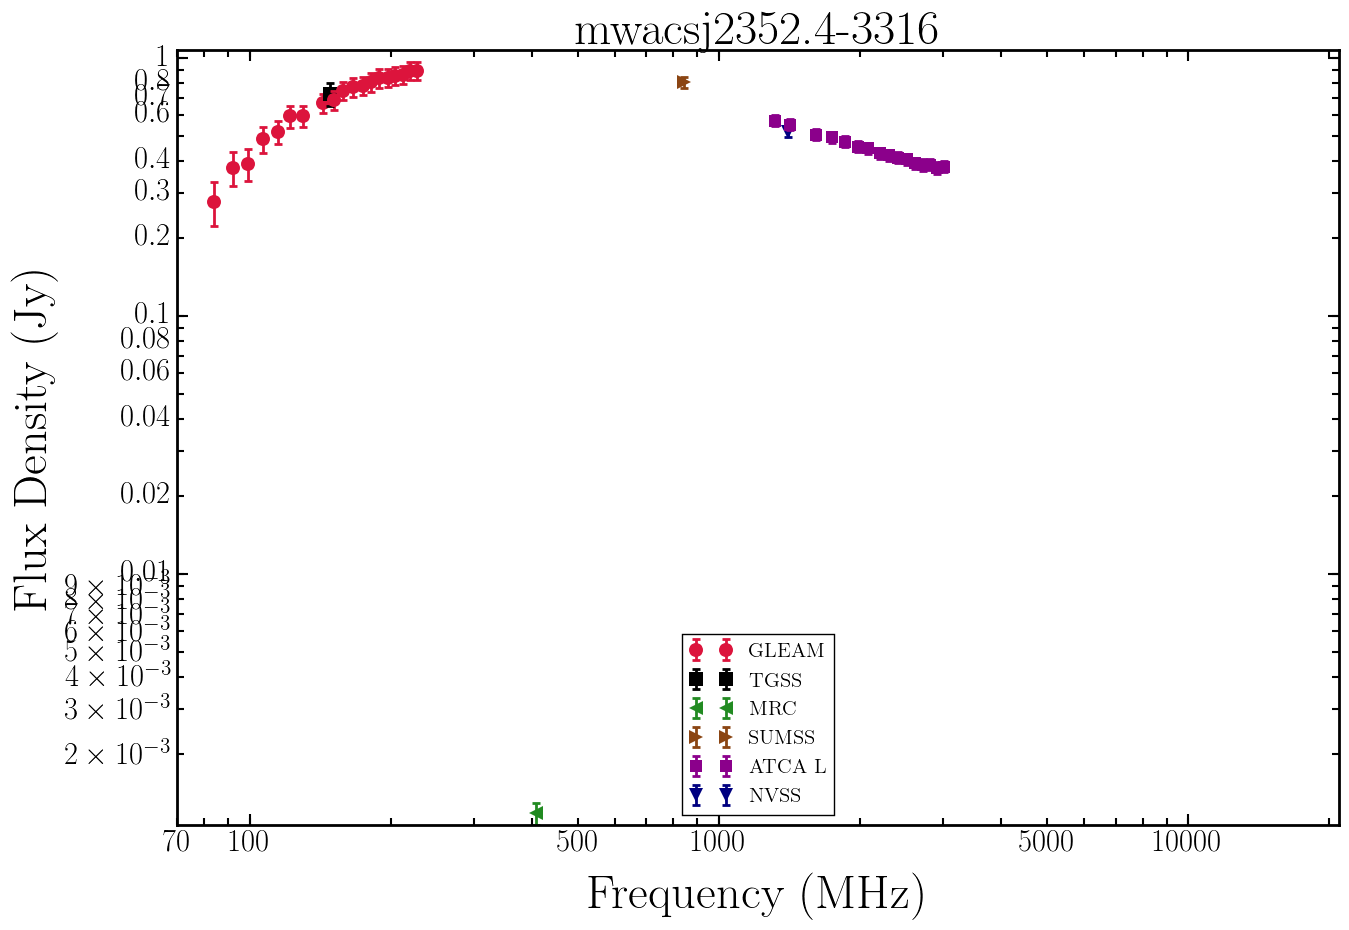

pks1347-218


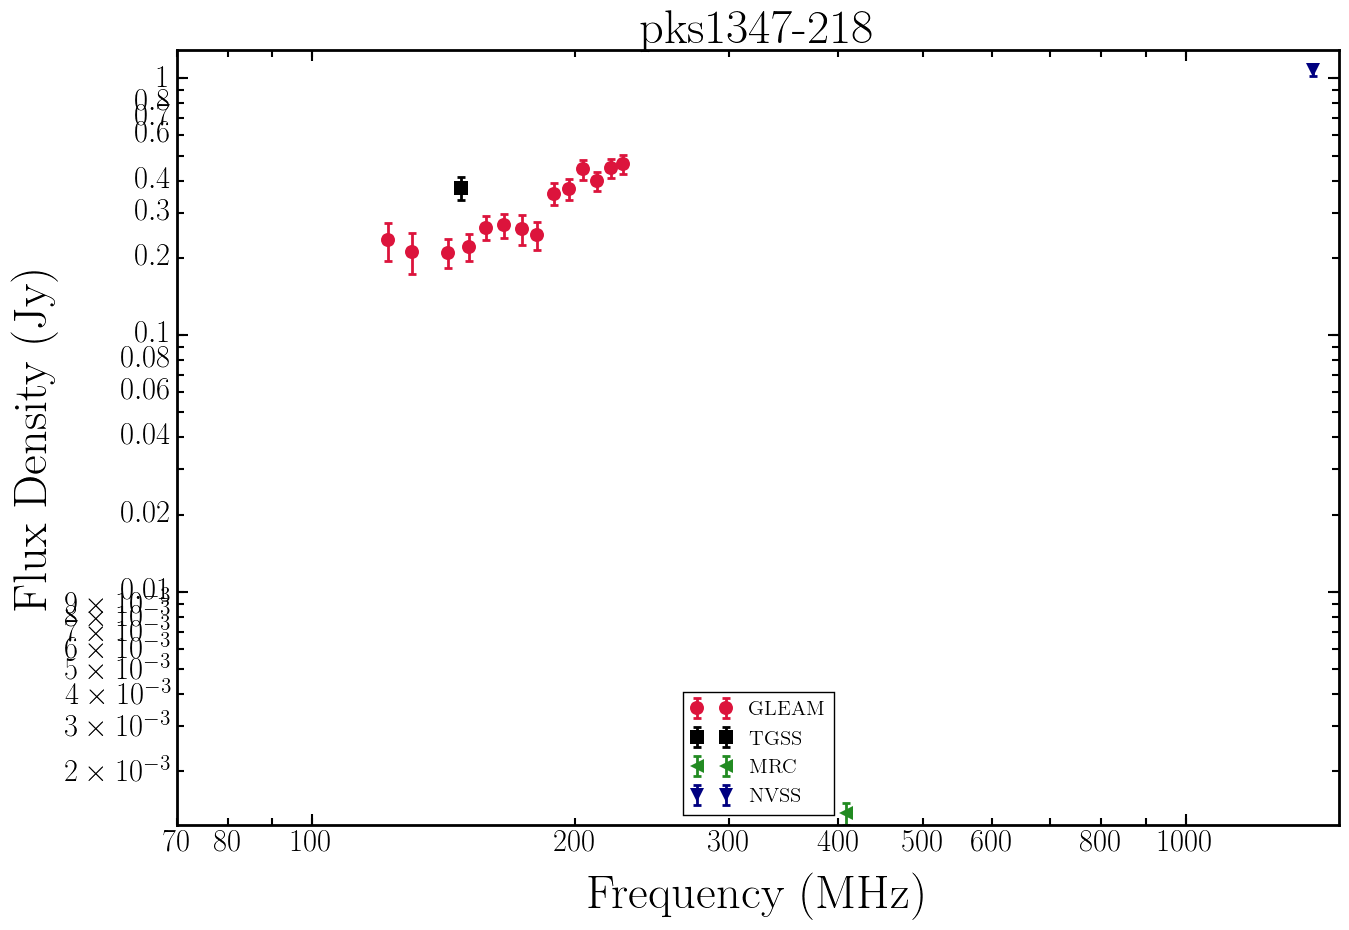

pks1545-120


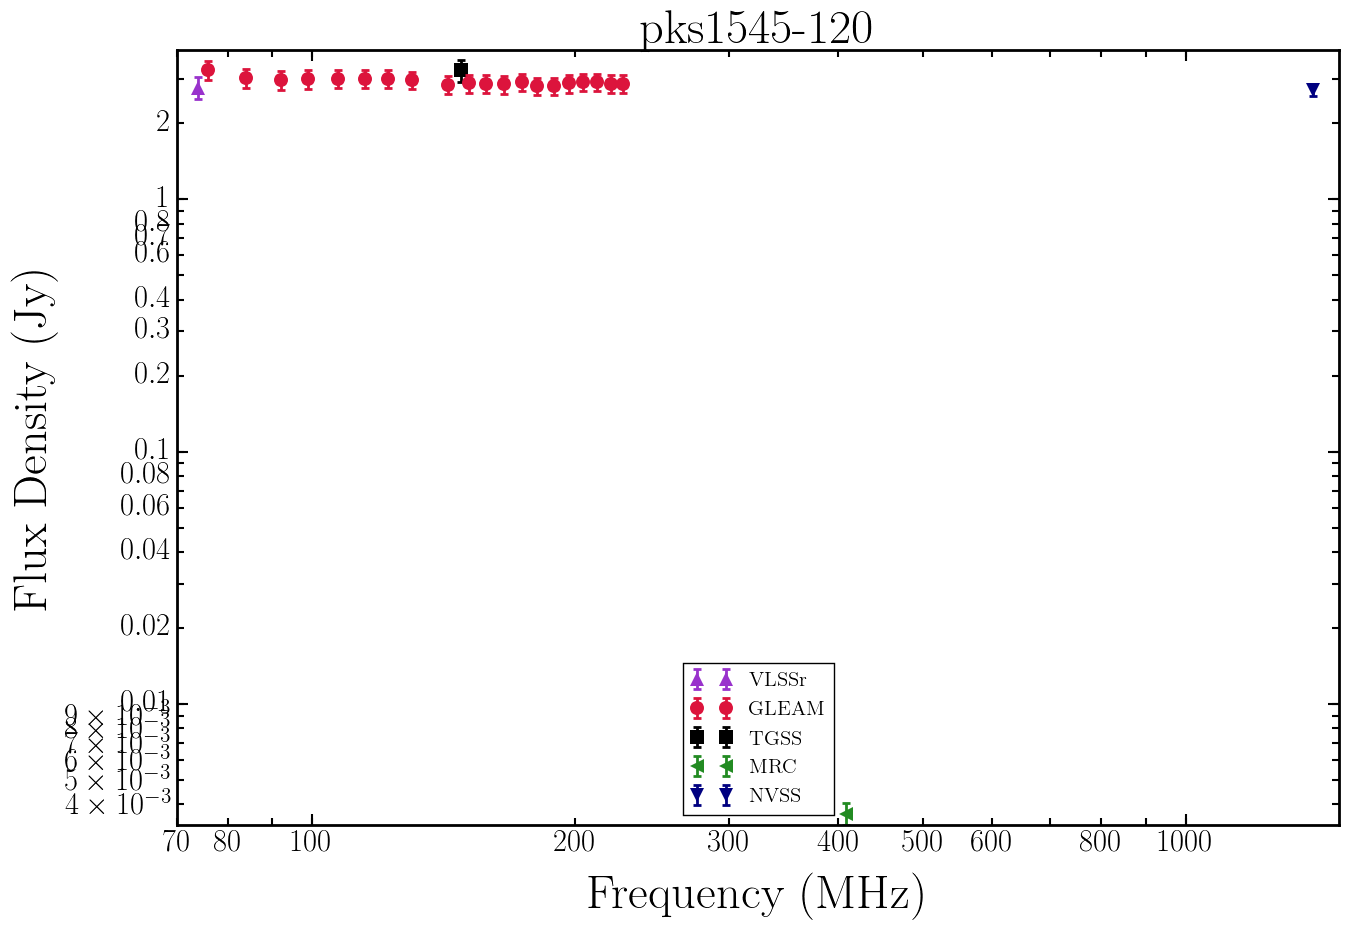

mwacsj0216.4-3009


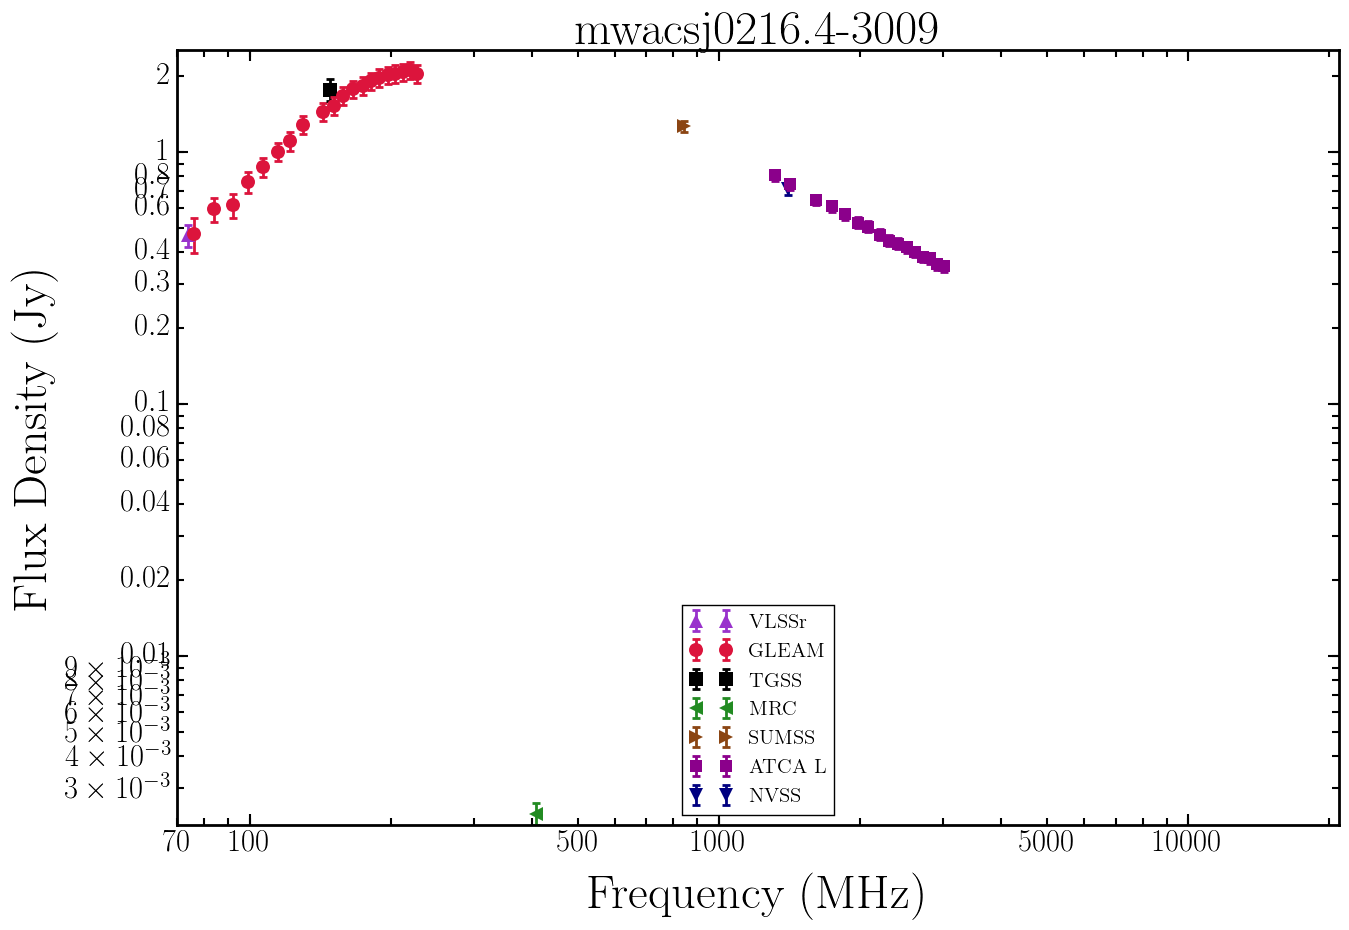

mwacsj0728.9-3052


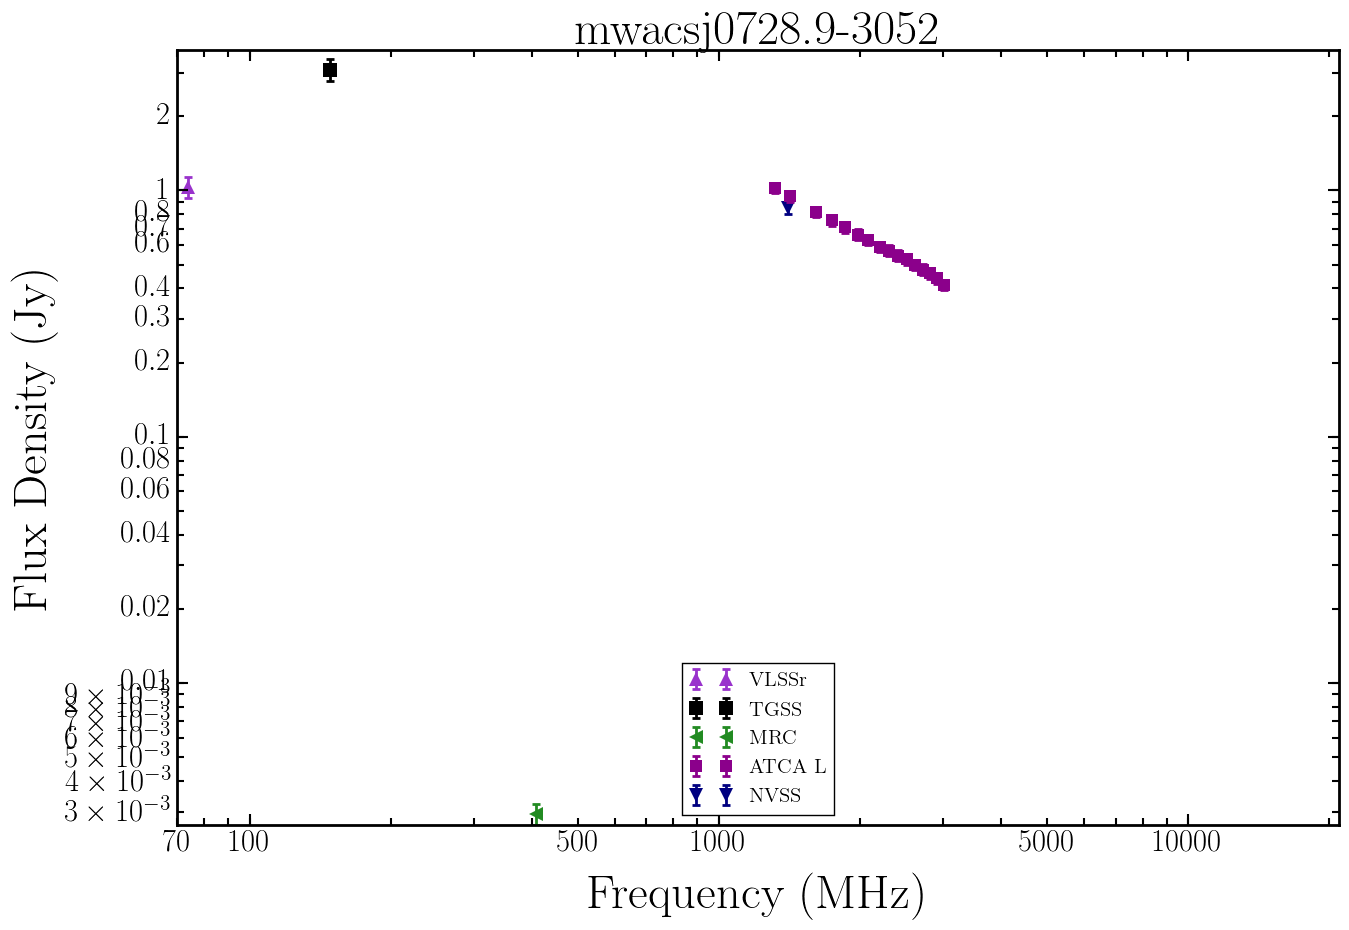

4c+12.50


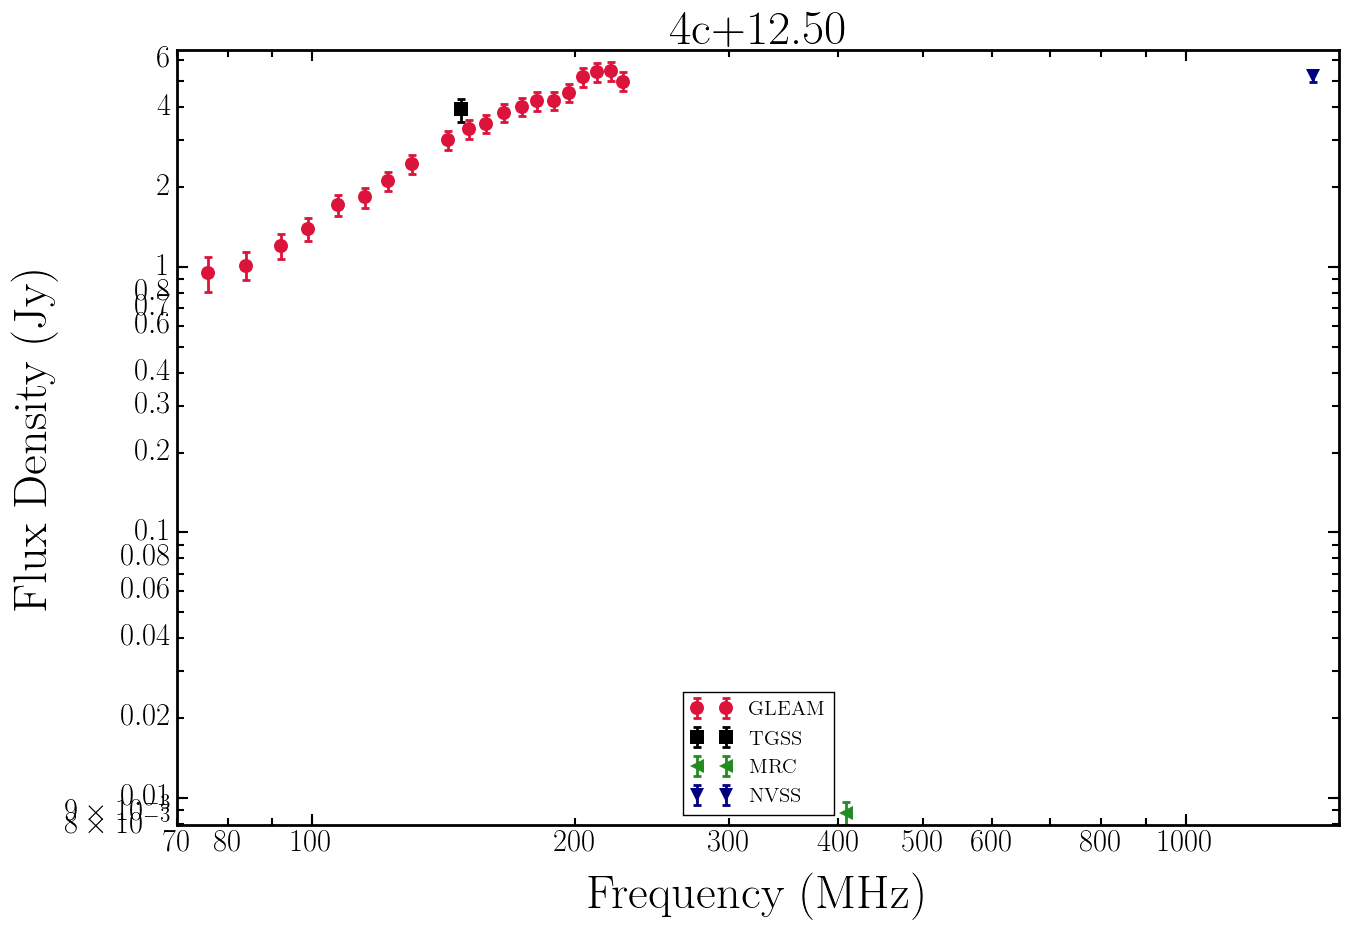

In [109]:
# fancy plotting 

for i in sed_df.index.tolist():
    
    freq_arr = sed_df.loc[i]["freq"]*1000 # in MHz
    flux_arr = sed_df.loc[i]["flux"]
    flux_err_arr = sed_df.loc[i]["flux_err"]
    name = sed_df.loc[i]["name"]
    print(name)
    try:

        seds_plot_func.sed(gpscssmodels.powlaw,[1,1],freq_arr,
                           flux_arr,flux_err_arr, name, 
                           freq_labels = True, savefig = False)

    except:
        print('error plotting ' + name)
        pass


In [63]:
[s for s in list(df["ID_1"]) if "07" in s]

['0743-673',
 'PKS1540-077',
 'PKS0207-224',
 'MWACSJ2157.5-1807',
 'PKS 1107+10',
 'PKS 1107-187']

In [ ]:
           ''' # check if monotonically decreasing
            dx= np.diff(np.asarray(temp_freq_arr,dtype=float))
            all_decreasing = np.all(dx <= 0)

            # I don't think this really matters for matplotlib
            # but it bothered me
            if not all_decreasing: 
                # reverse the lists
                temp_freq_arr = temp_freq_arr[::-1]
                temp_flux_arr = temp_flux_arr[::-1]
                temp_freq_err_arr = temp_freq_err_arr[::-1]
                temp_flux_err_arr = temp_flux_err_arr[::-1]'''